# Functional Comparison of ASN with WS and C. Elegans

This notebook generates 24 different ASN networks with 300 nodes, each of which has differing parameters (Average Path length, Wire Dispersion and Centroid Dispersion). 

We then find the average degree for each ASN network, and use that as 2k to generate corresponding grid-like, small-world and random Watts-Strogatz networks.

We also load a sample C. Elegans network for comparison.

In [2]:
!jupyter notebook --version
!python --version
!conda --version
# !jupyter trust RunTasksDifferentNetworks_MultipleNetworks.ipynb

5.7.8
Python 3.7.3
conda 4.8.3


In [3]:
cd

/suphys/aloe8475


In [4]:
cd "Documents/edamame"

/import/silo2/aloe8475/Documents/edamame


In [5]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
import nct
import bct

#warnings.filterwarnings('ignore')

## Functions:

In [6]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

In [7]:
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [8]:
# this_seed2=700
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [9]:
#Select Largest Components
def select_largest_component_new(wires_dict):
    """
    Find and select largest connected component of the original graph G.
    Throws away unconnected components and updates all the keys in wires_dict 
    """
#     def connected_component_subgraphs(G):
#         for c in nx.connected_components(G):
#             yield G.subgraph(c)
    
    wires_dict['G'] = max(connected_component_subgraphs(wires_dict['G']), key=len)
#     set_trace()
    nw = len(wires_dict['G'].nodes())
    nj = len(wires_dict['G'].edges())   
    
    logging.info("The largest component has %5d nodes and %6d edges", nw, nj)

    # Replace values in the dictionary
    wires_dict['number_of_wires']     = nw
    wires_dict['number_of_junctions'] = nj
    wires_dict['xa'] = wires_dict['xa'][wires_dict['G'].nodes()] 
    wires_dict['ya'] = wires_dict['ya'][wires_dict['G'].nodes()] 
    wires_dict['xb'] = wires_dict['xb'][wires_dict['G'].nodes()] 
    wires_dict['yb'] = wires_dict['yb'][wires_dict['G'].nodes()]
    wires_dict['xc'] = wires_dict['xc'][wires_dict['G'].nodes()] 
    wires_dict['yc'] = wires_dict['yc'][wires_dict['G'].nodes()]
 
    # Keep old edge_list
    old_edge_list = [(ii, kk) for ii, kk in  zip(wires_dict['edge_list'][:, 0], wires_dict['edge_list'][:, 1])]
    # Remove old edge list
    wires_dict = wires.remove_key(wires_dict, 'edge_list') 
    # Save indices of intersections in the old graph
    ind_dict = {key:value for value,key in enumerate(old_edge_list)}
    new_edge_list = sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0])
    # Find intersection between the two sets
    inter = set(ind_dict).intersection(new_edge_list)
    # Retrieve edge indices/positions from the old list
    edges_idx = [ind_dict[idx] for idx in inter]
       
    # These have length equal to number of junctions -- only get the ones we need
    wires_dict['xi'] = wires_dict['xi'][edges_idx] 
    wires_dict['yi'] = wires_dict['yi'][edges_idx] 
    
    # Get contiguous numbering of nodes
    # Build node mapping 
    node_mapping    = {key:value for value, key in enumerate(sorted(wires_dict['G'].nodes()))}
    # This  step also renames edges list
    wires_dict['G'] =  nx.relabel_nodes(wires_dict['G'] , node_mapping)

    # Swap node vertices if vertex 0 is larger than vertex 1, then sort by first element
    wires_dict['edge_list'] = np.asarray(sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0]))
    
    # Save adjacency matrix of new graph
    wires_dict = wires.remove_key(wires_dict, 'adj_matrix') 
    wires_dict = wires.generate_adj_matrix(wires_dict)

    wire_distances = wires.cdist(np.array([wires_dict['xc'], wires_dict['yc']]).T, np.array([wires_dict['xc'], wires_dict['yc']]).T, metric='euclidean')    
    wires_dict['wire_distances'] = wire_distances

    return wires_dict 

## Generate 300nw ASN + C. Elegans:

In [10]:
cElegans=loadmat("../CODE/Data/Organic Networks Connectomes/celegans277neurons.mat")

    #C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Data\Organic Networks Connectomes\

In [11]:
#set up dictionary for celegans:
Elegans={'adj_matrix':[],'G':[],'Accuracy':{'Linear Transformation':[],'Mackey Glass':{'Cheat Steps':[],'Accuracy Value':[]},'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}}

In [12]:
elegansMat=cElegans['celegans277matrix']
elegansGraph = nx.from_numpy_array(elegansMat)
Elegans['adj_matrix']=elegansMat
Elegans['G']=elegansGraph

In [13]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [14]:
if (not os.path.isfile('networks_LinearTransformation.pkl')): #if we haven't saved the file
    print('Creating Parameters')
    #Set Paramaters for network generation: Centroid Dispersion, Wire Dispersion + Length of Wires
    params={'Centroid':np.arange(150,400,25),'Wire Dispersion':[1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 80.0, 90.0, 100.0],'Length':np.arange(100,350,25)}
    numNetworks=len(params['Centroid'])+len(params['Wire Dispersion'])+len(params['Length']) #all parameters)
    if 'ASN300' in locals():
        loaded=True
    else:
        loaded=False
        ASN300=[[None]*10 for i in range(numNetworks)]
#         cluster1=[[None]*10 for i in range(len(params['Centroid']))] #change in Centroid Dispersion
#         cluster2=[[None]*10 for i in range(len(params['Wire Dispersion']))] #change in Wire Dispersion
#         cluster3=[[None]*10 for i in range(len(params['Length']))] #change in average wire length


    #loop through these:
    centroid2=params['Centroid']
    length2=params['Length']
    disp2=params['Wire Dispersion']
    for i in range(49):
        temp=params['Centroid']
        temp2=params['Length']
        temp3=params['Wire Dispersion']
        centroid2=np.concatenate((centroid2,temp))
        length2=np.concatenate((length2,temp2))
        disp2=np.concatenate((disp2,temp3))
    print('Parameters Saved')
else:
    print('Parameters Loaded')

Parameters Loaded


In [15]:
#This loops through 30 different parameters, and for each parameter generates networks until we find 10 networks with 277+ nodes,
# for a total of 300 networks of 277+ nodes with different parameters.


#I create 30 sets of networks. For each set, i generate networks, changing 2 parameters, 
# until i've found 10 networks with >277 nodes. 
# For each parameter, if we have <277, we loop through 10 more networks with different random seeds (same parameter), 
# to see if we can get >277 nodes, then we move on to next parameter

#This way I generate 300 networks with varying parameters.

if (not os.path.isfile('networks_LinearTransformation.pkl')): #if we haven't saved the file
    print('Networks not loaded, creating now')
    count1=0
    count2=0
    count3=0
    this_seed=1779#np.random.randint(10000)
#     seed2=range(1, 6001, 20)
    for i in range(numNetworks):
        #loop through different parameter sets:
        x=0
        for j in range(500): #for each parameter, create 100 different networks
            if i < len(params['Centroid']):
#                 seed2=np.random.randint(100000)
                #Change centroid dispersion + avg wire length, but keep dispersion constant
                if x < 10:
                    print('Parameter: ' + str(i+1) + ' , Network: ' + str(j+1))
                    print('Parameter 1: Centroid ' +str(params['Centroid'][i])+ ' , Parameter 2: Avg Length ' + str(length2[j]))
                    temp=wires.generate_wires_distribution(300,this_seed=np.random.randint(100000),wire_dispersion=10,centroid_dispersion=params['Centroid'][i],wire_av_length=length2[j])
                    temp=wires.detect_junctions(temp)
                    temp=wires.generate_adj_matrix(temp)
                    temp=wires.generate_graph(temp)
                    temp=select_largest_component_new(temp)
                    counter1=0
                    
                while temp['G'].number_of_nodes() <277 and counter1<=10: #if nodes are less than 277, try the same parameters again for 10 more times before moving on to the next parameter
                    print(str(counter1) +': Parameter 1: Centroid ' +str(params['Centroid'][i])+ ' , Parameter 2: Avg Length ' + str(length2[j]))
                    temp=wires.generate_wires_distribution(300,this_seed=np.random.randint(100000),wire_dispersion=10,centroid_dispersion=params['Centroid'][i],wire_av_length=length2[j])
                    temp=wires.detect_junctions(temp)
                    temp=wires.generate_adj_matrix(temp)
                    temp=wires.generate_graph(temp)
                    temp=select_largest_component_new(temp)
                    counter1=counter1+1
                    
                if temp['G'].number_of_nodes()>=277: #only networks with more than 277 nodes
                    if x < 10: #only store 10 networks of each type
                        ASN300[i][x]=temp         
                        cluster1[count1][x]=temp    
                    x = x+1
                else:
                    print('saved networks ' + str(x))

                #only increase count if it's the last j value in the loop
                if j == 499:
                    count1=count1+1

            elif i >= len(params['Centroid']) and i < len(params['Centroid'])+len(params['Wire Dispersion']):
                #Change centroid dispersion + wire dispersion, keep avg wire length constant
                if x < 10:
                    print('Parameter: ' + str(i+1) + ' , Network: ' + str(j+1))
                    print('Parameter 1: Wire Disp ' +str(params['Wire Dispersion'][i-len(params['Centroid'])])+ ' , Parameter 2: Centroid ' + str(centroid2[j]))
                    temp=wires.generate_wires_distribution(300,this_seed=np.random.randint(100000),centroid_dispersion=centroid2[j],wire_dispersion=params['Wire Dispersion'][i-len(params['Centroid'])],wire_av_length=110)
                    temp=wires.detect_junctions(temp)
                    temp=wires.generate_adj_matrix(temp)
                    temp=wires.generate_graph(temp)
                    temp=select_largest_component_new(temp)
                    
                    counter2=0
                while temp['G'].number_of_nodes() <277 and counter2<=10:
                    print(str(counter2) +': Parameter 1: Wire Disp ' +str(params['Wire Dispersion'][i-len(params['Centroid'])])+ ' , Parameter 2: Centroid ' + str(centroid2[j]))
                    temp=wires.generate_wires_distribution(300,this_seed=np.random.randint(100000),centroid_dispersion=centroid2[j],wire_dispersion=params['Wire Dispersion'][i-len(params['Centroid'])],wire_av_length=110)
                    temp=wires.detect_junctions(temp)
                    temp=wires.generate_adj_matrix(temp)
                    temp=wires.generate_graph(temp)
                    temp=select_largest_component_new(temp)
                    counter2=counter2+1
                    
                if temp['G'].number_of_nodes()>=277: #only networks with more than 250 nodes
                    if x < 10: #only store 10 networks of each type
                        ASN300[i][x]=temp         
                        cluster2[count2][x]=temp
                    x = x+1
                else:
                    print('saved networks ' + str(x))

                #only increase count if it's the last j value in the loop
                if j == 499:
                    count2=count2+1        
            else:
               #Change  wire dispersion +  avg wire length, keep centroid dispersion constant
                if x < 10:
                    print('Parameter: ' + str(i+1) + ' , Network: ' + str(j+1))
                    print('Parameter 1 Avg Length:  ' +str(params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))])+ ' , Parameter 2: Wire Disp ' + str(disp2[j]))
                    temp=wires.generate_wires_distribution(300,this_seed=np.random.randint(100000),centroid_dispersion=300,wire_dispersion=disp2[j],wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))])
                    temp=wires.detect_junctions(temp)
                    temp=wires.generate_adj_matrix(temp)
                    temp=wires.generate_graph(temp)
                    temp=select_largest_component_new(temp)
                    
                    counter3=0
                while temp['G'].number_of_nodes() <277  and counter3<=10:
                    print(str(counter3) +': Parameter 1 Avg Length:  ' +str(params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))])+ ' , Parameter 2: Wire Disp ' + str(disp2[j]))
                    temp=wires.generate_wires_distribution(300,this_seed=np.random.randint(100000),centroid_dispersion=300,wire_dispersion=disp2[j],wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))])
                    temp=wires.detect_junctions(temp)
                    temp=wires.generate_adj_matrix(temp)
                    temp=wires.generate_graph(temp)
                    temp=select_largest_component_new(temp)
                    counter3=counter3+1
                    
                if temp['G'].number_of_nodes()>=277: #only networks with more than 250 nodes
                    if x < 10: #only store 10 networks of each type
                        ASN300[i][x]=temp   
                        cluster3[count3][x]=temp
                    x = x+1
                else:
                    print('saved networks ' + str(x))
    #             ASN300[i][j]=wires.generate_wires_distribution(300,this_seed=seed2[j],centroid_dispersion=300,wire_dispersion=params['Wire Dispersion'][j],wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))],)
    #             count = 0;
    #             cluster3[count3][j]=wires.generate_wires_distribution(300,this_seed=seed2[j],centroid_dispersion=300,wire_dispersion=params['Wire Dispersion'][j],wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))],)

                #only increase count if it's the last j value in the loop
                if j == 499:
                    count3=count3+1
                    
    #Save networks so we don't have to run this every time
    name='networks_LinearTransformation.pkl'
    with open(name, 'wb') as f:
        pickle.dump([ASN300,cluster1,cluster2,cluster3], f)
        
else: #load pickle file + communicability matrix calculated in Linear Transformation section 
    name='networks_LinearTransformation.pkl'
    print('Loading Networks + Linear Transformation Results')
    file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
    [ASN300] = pickle.load(file)

    print('Loaded')

Loading Networks + Linear Transformation Results
Loaded


In [16]:
#set up accuracy dictionary for ASN

numberOfNodeTests=6
numberOfCheatSteps=6
if (not os.path.isfile('networks_LinearTransformation.pkl')): #if we haven't saved the file
    count1=0
    count2=0
    count3=0
    for i in range(len(ASN300)):
        for j in range(len(ASN300[i])):
            ASN300[i][j].update({'Accuracy':{'Linear Transformation':[None]*numberOfNodeTests,'Mackey Glass':{'Cheat Steps':[],'Accuracy Value':[None]*numberOfCheatSteps},'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
#         #set up accuracy dictionary for ASN Clusters
#             if i < len(cluster1):
#                 cluster1[count1][j].update({'Accuracy':{'Linear Transformation':[None]*numberOfNodeTests,'Mackey Glass':{'Cheat Steps':[],'Accuracy Value':[None]*numberOfCheatSteps},'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
#                 if j == len(ASN300[i]):
#                     count1=count1+1
#             elif i >= len(cluster1) and i < len(cluster1)+len(cluster2):
#                 cluster2[count2][j].update({'Accuracy':{'Linear Transformation':[None]*numberOfNodeTests,'Mackey Glass':{'Cheat Steps':[],'Accuracy Value':[None]*numberOfCheatSteps},'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
#                 if j == len(ASN300[i]):
#                     count2=count2+1
#             else:
#                 cluster3[count3][j].update({'Accuracy':{'Linear Transformation':[None]*numberOfNodeTests,'Mackey Glass':{'Cheat Steps':[],'Accuracy Value':[None]*numberOfCheatSteps},'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
#                 if j == len(ASN300[i]):
#                     count3=count3+1

In [17]:
# # nwEdges100=np.array(np.sum(ASN100['adj_matrix'])/2)

# #Detect junctions, create adj matrix and graph, and store number of junctions
nwEdges300=[]
numNodes=[]
# count1=0
# count2=0
# count3=0
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
#         print('Network ' + str(i) +', Iteration ' +str(j))
#         ASN300[i][j]=wires.detect_junctions(ASN300[i][j])
#         ASN300[i][j]=wires.generate_adj_matrix(ASN300[i][j])
#         ASN300[i][j]=wires.generate_graph(ASN300[i][j])
#         ASN300[i][j]=select_largest_component_new(ASN300[i][j])
        nwEdges300.append(np.sum(ASN300[i][j]['adj_matrix'])/2)
        numNodes.append(ASN300[i][j]['number_of_wires'])
#         if i < len(cluster1):
#             print('Cluster 1')
#             cluster1[count1][j]=ASN300[i][j]
#             if j == len(ASN300[i])-1:
#                 count1=count1+1
#         elif i >= len(cluster1) and i < (len(cluster2) + len(cluster1)):
#             print('Cluster 2')
#             cluster2[count2][j]= ASN300[i][j]
#             if j == len(ASN300[i])-1:
#                 count2=count2+1
#         elif i >= (len(cluster2) + len(cluster1)) and i < (len(cluster1)+len(cluster2)+len(cluster3)):
#             print('Cluster 3')
#             cluster3[count3][j]= ASN300[i][j]
#             if j == len(ASN300[i])-1:
#                 count3=count3+1

In [18]:
# # fwASN100=nx.floyd_warshall_numpy(ASN100['G']) #Find all-pairs shortest path lengths using Floyd’s algorithm
# fwASN300=[None]*len(ASN300)
# for i in range(len(ASN300)):
#     fwASN300[i]=nx.floyd_warshall_numpy(ASN300[i]['G'])

In [19]:
# #export adj matrices to calculate small worldness in matlab:
# adj_mats={"AdjMat":[[None]*len(ASN300[0]) for i in range(len(ASN300))]}
# for i in range(len(ASN300)):
#     for j in range(len(ASN300[i])):
#         adj_mats['AdjMat'][i][j]=(ASN300[i][j]['adj_matrix'])
# savemat('300nwASN_multipleNetworks.mat',adj_mats)
# #C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\

## Graph Theory Measures:

### ASN

In [20]:
if (not os.path.isfile('networks_LinearTransformation.pkl')): #if we haven't saved the file
    print('Setting up Graph Theory')
    for i in range(len(ASN300)):
        for j in range(len(ASN300[i])):
            ASN300[i][j].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
    for i in range(len(cluster1)):
            for j in range(len(cluster1[i])):
                cluster1[i][j].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
    for i in range(len(cluster2)):
            for j in range(len(cluster2[i])):
                cluster2[i][j].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
    for i in range(len(cluster3)):
            for j in range(len(cluster3[i])):
                cluster3[i][j].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
else:
    print('Graph Theory Already Loaded')

Graph Theory Already Loaded


In [21]:
# Small Worldness: 
# ------------------------------------
# CALCULATED IN MATLAB: smallworldness.m 
# found in C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks
# ------------------------------------
temp=loadmat(r'300nwASN_multipleNetworks_smallworld.mat')
smallworld=temp['smallworld']
del temp

In [22]:
# #Plot Networks
# %matplotlib inline
# fig1=plt.figure(figsize=(150,150))
# numNetworks=len(ASN300)*len(ASN300[0])
# ax=[None]*numNetworks
# axBig = fig1.add_subplot(111)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# axBig.set_frame_on(False)
# # plt.title('300nw ASN Sample Networks',fontsize=30,pad=30)
# # plt.xlabel('PCoeff',fontsize=30,labelpad=15)
# # plt.ylabel('MZ',fontsize=30,labelpad=15)
# count1=0
# count2=0
# count3=0
# countAxis=0
# for i in range(len(ASN300)):
#     print(i)
#     for j in range(len(ASN300[0])):
#         ax[countAxis]=fig1.add_subplot(numNetworks/15, numNetworks/20, countAxis+1) #change rows and columns to be factors of ASN300 length
#         nx.draw_networkx(ASN300[i][j]['G'],node_size=20,with_labels=False)
#         ax[countAxis].set_yticklabels([])
#         ax[countAxis].set_xticklabels([])
# #         if i < len(cluster1):
# #             ax[countAxis].set_title('Cluster 1 Parameter ' + str(count1+1),fontsize=5)
# #             if j == len(ASN300[0])-1:
# #                 count1=count1+1
# #         elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
# #             ax[countAxis].set_title('Cluster 2 Parameter ' + str(count2+1),fontsize=5)
# #             if j == len(ASN300[0])-1:
# #                 count2=count2+1
# #         else:
# #             ax[countAxis].set_title('Cluster 3 Parameter ' + str(count3+1),fontsize=5)
# #             if j == len(ASN300[0])-1:
# #                 count3=count3+1
#         plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(smallworld[i][j]),transform=ax[countAxis].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
#         countAxis=countAxis+1
#     #     ax[i].set_ylim(-1.5,1.5)
#     #     ax[i].set_xlim(-1.5,1.5)
    
    
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Networks',dpi=100)    

In [23]:
if (not os.path.isfile('networks_LinearTransformation.pkl')): #if we haven't saved the file
    # Modularity, PCoeff, Small Worldness & MZ:
    ci = []
    pcoeff= []
    mz= []
    clustering = []
    count1=0
    count2=0
    count3=0
    for i in tqdm(range(len(ASN300))):
        for j in tqdm(range(len(ASN300[i]))):
            ci,q=nct.community_louvain(ASN300[i][j]['adj_matrix'])
            pcoeff=bct.participation_coef(ASN300[i][j]['adj_matrix'],ci)
            mz=bct.module_degree_zscore(ASN300[i][j]['adj_matrix'],ci)
            clustering=nx.clustering(ASN300[i][j]['G'])
            ASN300[i][j]['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(ASN300[i][j]['G']))
            ASN300[i][j]['Graph Theory']['Modularity']=ci
            ASN300[i][j]['Graph Theory']['Modularity Score']=q
            ASN300[i][j]['Graph Theory']['PCoeff']=pcoeff
            ASN300[i][j]['Graph Theory']['MZ']=mz
            ASN300[i][j]['Graph Theory']['Small World']=smallworld[i][j]
            ASN300[i][j]['Graph Theory']['CCoeff']=clustering
            ASN300[i][j]['Graph Theory']['Degree']=nx.degree(ASN300[i][j]['G'])
            ASN300[i][j]['Graph Theory']['AvgPL']=nx.average_shortest_path_length(ASN300[i][j]['G'])
    #Save networks so we don't have to run this every time
    name='networks_LinearTransformation.pkl'
    with open(name, 'wb') as f:
        pickle.dump([ASN300], f)   
else:
    print('Graph Theory Already Loaded')

Graph Theory Already Loaded


In [24]:
#More Graph Theory:
#Number of Junctions
junctions=[]
#Number of Nodes:
nodes=[]
avgPL=[]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        junctions.append(ASN300[i][j]['number_of_junctions'])
        nodes.append(ASN300[i][j]['number_of_wires'])

junctions=np.asarray(junctions)
nodes=np.asarray(nodes)

In [25]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [26]:
# ### MODULARITY
# from community import community_louvain

# fig1=plt.figure(figsize=(30,30))

# numNetworks=len(ASN300)*len(ASN300[0])
# ax=[None]*numNetworks
# axBig = fig1.add_subplot(111)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# axBig.set_frame_on(False)
# plt.title('300nw ASN Sample Networks',fontsize=30,pad=30)
# # plt.xlabel('PCoeff',fontsize=30,labelpad=15)
# # plt.ylabel('MZ',fontsize=30,labelpad=15)
# count1=0
# count2=0
# count3=0
# for i in range(len(ax)):
#     countAxis=0
# for i in range(len(ASN300)):
#     print(i)
#     for j in range(len(ASN300[0])):
#         ax[countAxis]=fig1.add_subplot(numNetworks/5, numNetworks/6, i+1) #change rows and columns to be factors of ASN300 length
#         g=ASN300[i][j]['G']
#         if i < len(cluster1):
#             ax[countAxis].set_title('Cluster 1 Parameter ' + str(count1+1),fontsize=15)
#             if j == len(ASN300[0])-1:
#                 count1=count1+1
#         elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#             ax[countAxis].set_title('Cluster 2 Parameter ' + str(count2+1),fontsize=15)
#             if j == len(ASN300[0])-1:
#                 count2=count2+1
#         else:
#             ax[countAxis].set_title('Cluster 3 Parameter ' + str(count3+1),fontsize=15)
#             if j == len(ASN300[0])-1:
#                 count3=count3+1
                
#             partition = community_louvain.best_partition(g)
#             pos = community_layout(g, partition)
#             nx.draw(g, node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=40);
#             plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(smallworld[i][j]),transform=ax[countAxis].transAxes,fontsize=15) #this plots Smallworldness as text in a relative position on each subplot
#             countAxis=countAxis+1
    
    
    
#     if i < len(cluster1):
#         ax[i].set_title('Cluster 1 Parameter ' + str(count1+1),fontsize=15)
#         count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Parameter ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Parameter ' + str(count3+1),fontsize=15)
#         count3=count3+1   
   


In [27]:
# #Plot Participation Coefficient vs MZ
# fig1=plt.figure(figsize=(150,150))


# from edamame.analysis.misc import draw_zp_space

# # fig, ax = plt.subplots()    
# # line = ax.scatter(pcoeff,mz)
# # ax.set_title('C Elegans',fontsize=30)
# # ax.set_xlabel('PCoeff',fontsize=30,labelpad=15)
# # ax.set_ylabel('MZ',fontsize=30,labelpad=15)
# # plt.text(0.7,8,'SW:'+"{0:.2f}".format(smallworld_elegans[0]),fontsize=15)
# # ax.set_ylim(-3, 10)
# # ax.set_xlim(0,1)


# ax=[None]*300
# axBig = fig1.add_subplot(111)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# axBig.set_frame_on(False)
# # plt.title('300nw ASN Networks',fontsize=30,pad=30)
# # plt.xlabel('PCoeff',fontsize=30,labelpad=15)
# # plt.ylabel('MZ',fontsize=30,labelpad=15)
# countAX=0
# from edamame.analysis.misc import draw_zp_space
# for i in range(len(ASN300)):
#     print(i)
#     for j in range(len(ASN300[i])):
#         fig1.suptitle('Network '+str(countAX+1))
#         ax[countAX]=plt.subplot(20, 15, countAX+1)
#         line = ax[countAX].scatter(ASN300[i][j]['Graph Theory']['PCoeff'],ASN300[i][j]['Graph Theory']['MZ'],c='k')
#     #     ax[i].set_title('Max Accuracy ',fontsize=30)
# #         ax[countAX].set_xlabel('PCoeff')#,labelpad=5)
# #         ax[countAX].set_ylabel('MZ')#,labelpad=5)
#         plt.text(0.7,8,'SW:'+"{0:.2f}".format(ASN300[i][j]['Graph Theory']['Small World']),fontsize=15)
#     #     plt.text(0.7,7,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation'])),fontsize=15)
#         ax[countAX].set_ylim(-3, 10)
#         ax[countAX].set_xlim(0,1)
#         draw_zp_space(ax = ax[countAX])
#         countAX=countAX+1

# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmaralPlane',dpi=100)    

In [28]:
#Plot Degree Histogram:

fig1=plt.figure(figsize=(150,150))

ax=[None]*(len(ASN300)*len(ASN300[0]))
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
plt.title('Degree Distribution\nASN',fontsize=30,pad=30)
plt.ylabel('Frequency',fontsize=30,labelpad=15)
plt.xlabel('Degree',fontsize=30,labelpad=15)

# plt.ylabel('MZ',fontsize=30,labelpad=15)
countAX=0
fig1.subplots_adjust(hspace=.3)

for i in range(len(ASN300)):
    print(i)
    for j in range(len(ASN300[i])):
        fig1.suptitle('Network '+str(countAX+1))
        ax[countAX]=plt.subplot(20, 15, countAX+1)
        dictionary=dict(ASN300[i][j]['Graph Theory']['Degree'])
        meanDeg=np.mean(list(dictionary.values()))
        plt.text(0.5,0.6,'Avg DEG:'+"{0:.2f}".format(meanDeg),transform=ax[countAX].transAxes) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.525,'Wire Disp:'+"{0:.2f}".format(ASN300[i][j]['dispersion']),transform=ax[countAX].transAxes) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.45,'Avg Len:'+"{0:.2f}".format(ASN300[i][j]['avg_length']),transform=ax[countAX].transAxes) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.375,'Cent Disp:'+"{0:.2f}".format(ASN300[i][j]['centroid_dispersion']),transform=ax[countAX].transAxes) #this plots Smallworldness as text in a relative position on each subplot       
        plt.hist(dictionary.values(), color='r',label='ASN')
        countAX=countAX+1

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Degree All Networks',dpi=100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f88c30e27b8> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f88c30ed268> (for post_execute):


KeyboardInterrupt: 

### C. Elegans

In [29]:
#Small world calculated on C Elegans Matrix in smallworld.m in MATLAB
temp=loadmat(r'cElegans_smallworld.mat')
smallworld_elegans=temp['cElegansSW'][0]
del temp

Text(0.7, 0.1, 'SW:0.55')

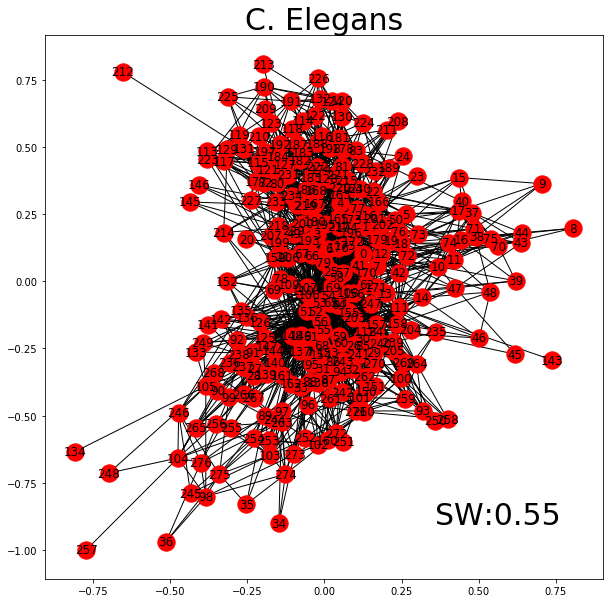

In [30]:
#Plot Networks
fig1=plt.figure(figsize=(10,10))

ax=fig1.gca()
plt.title('C. Elegans',fontsize=30)
nx.draw_networkx(elegansGraph)
plt.text(0.7,0.1,'SW:'+"{0:.2f}".format(smallworld_elegans[0]),transform=ax.transAxes,fontsize=30) #this plots Smallworldness as text in a relative position on each subplot
#     ax[i].set_ylim(-1.5,1.5)
#     ax[i].set_xlim(-1.5,1.5)

In [68]:
# Modularity, PCoeff, Small Worldness & MZ:
ci = []
pcoeff= []
mz= []

ci,q=nct.community_louvain(elegansMat)
pcoeff=bct.participation_coef(elegansMat,ci)
mz=bct.module_degree_zscore(elegansMat,ci)
Elegans['Graph Theory']['MZ']=mz
Elegans['Graph Theory']['PCoeff']=pcoeff
Elegans['Graph Theory']['Modularity']=ci
Elegans['Graph Theory']['Modularity Score']=q
Elegans['Graph Theory']['Small World']=smallworld_elegans
Elegans['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(elegansGraph))
Elegans['Graph Theory']['CCoeff']=nx.clustering(elegansGraph)
Elegans['Graph Theory']['Degree']=nx.degree(elegansGraph)



In [32]:
Elegans['Graph Theory']['Small World'][0]

0.5490216892760263

ValueError: zero-size array to reduction operation maximum which has no identity

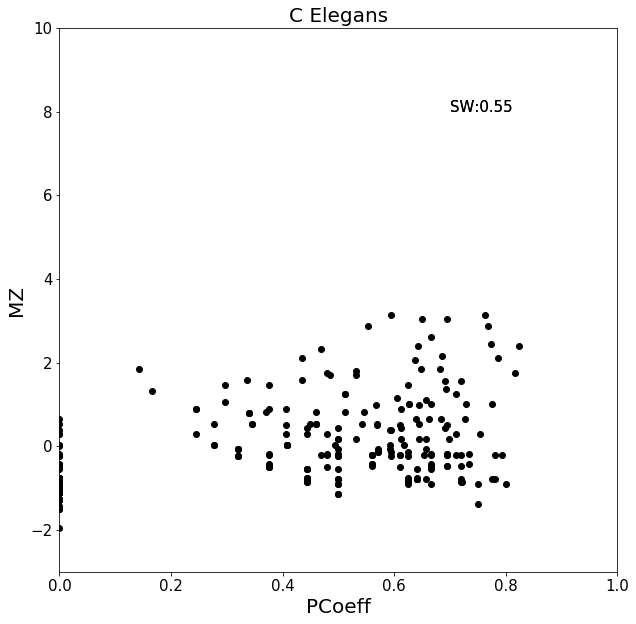

In [33]:
# fig1=plt.figure()
from edamame.analysis.misc import draw_zp_space

fig,  ax = plt.subplots(figsize=(10,10))    
line = ax.scatter(pcoeff,mz,c='k')
ax.set_title('C Elegans',fontsize=20)
ax.set_xlabel('PCoeff',fontsize=20)
ax.set_ylabel('MZ',fontsize=20)
plt.text(0.7,8,'SW:'+"{0:.2f}".format(smallworld_elegans[0]),fontsize=15)
ax.set_ylim(-3, 10)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)
plt.text(0.7,8,'SW:'+"{0:.2f}".format(Elegans['Graph Theory']['Small World'][0]),fontsize=15)
plt.text(0.7,7.5,'Accuracy:'+"{0:.2f}".format(np.max(Elegans['Accuracy']['Linear Transformation'])),fontsize=15)
 
draw_zp_space(ax = ax)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/PCoeff vs Module Z Elegans',dpi=300)

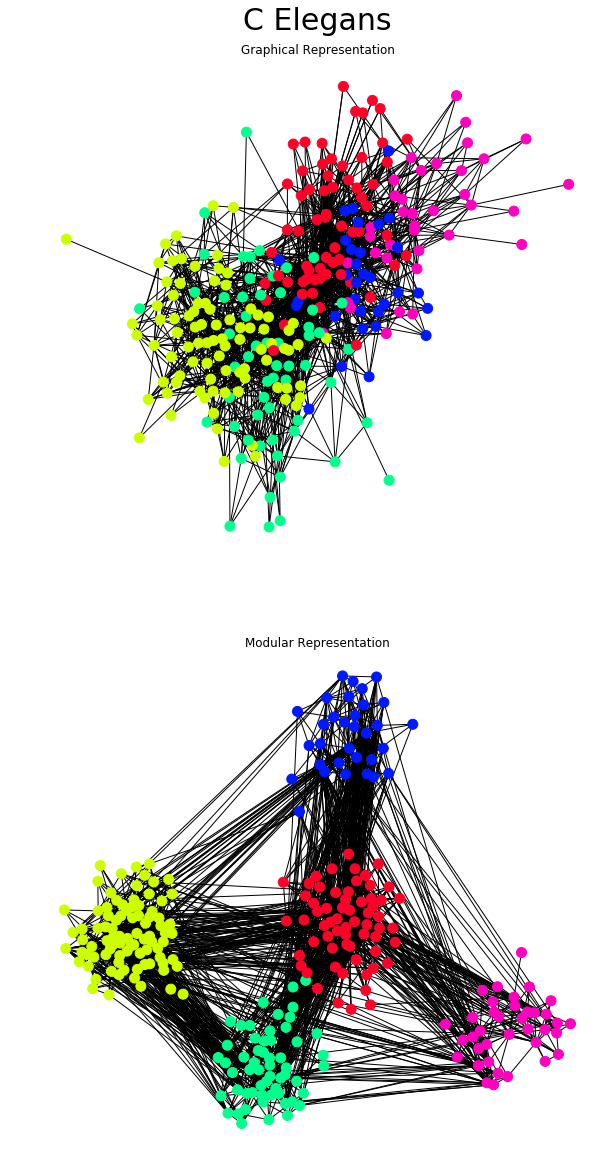

In [34]:
### MODULARITY
from community import community_louvain
fig2=plt.figure(figsize=(10,20))
plt.title('C Elegans',fontsize=30,pad=30)

ax=[None]*2
axBig = fig2.add_subplot(111)
axBig.set_yticklabels([])
plt.xticks([], [])
plt.yticks([], [])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
g=Elegans['G']
partition = community_louvain.best_partition(g)
pos = community_layout(g, partition)

ax[0]=fig2.add_subplot(2, 1, 1)
ax[0].set_title('Graphical Representation')
nx.draw(g,node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=100);
ax[1]=fig2.add_subplot(2, 1, 2)
ax[1].set_title('Modular Representation')
nx.draw(g, pos,node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=100);

# Task 1: Linear  Transformation

In [35]:
#Regression
def NOKEVregression(target,absV): 
    inputx=np.vstack((np.ones(len(target)),absV)).T
    a1=np.linalg.lstsq(inputx,target)
    return a1

In [36]:
#Subgraph AdjMat

#Threshold by conductance - when tunnelling becomes appreciable (offResistance * 10)

def getOnGraph(network, this_TimeStamp = 0):
    edgeList = network.connectivity.edge_list
    adjMat = np.zeros((network.numOfWires, network.numOfWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = (1/network.junctionResistance[this_TimeStamp,:])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = (1/network.junctionResistance[this_TimeStamp,:])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    onGraph = nx.from_numpy_array(adjMat)
    onGraph=nx.DiGraph.to_undirected(onGraph)
    
    return onGraph

In [37]:
def getSubGraphComm(network, this_TimeStamp = 0):
    onGraph = getOnGraph(network, this_TimeStamp)
    components = [i for i in nx.connected_components(onGraph)]
    giant_component = components[np.argmax([len(i) for i in nx.connected_components(onGraph)])]
    nodes = list(giant_component)
    commMat = np.zeros((network.numOfWires, network.numOfWires))
    subComm = nx.communicability(onGraph.subgraph(giant_component))
    for i in nodes:
        for j in nodes:
            commMat[i,j] = subComm[i][j]
    return commMat

In [38]:
#Communicability + Current Matrices
def commCurr(sim):
    startTime=500
    timeSteps=50
    endTime=1500
    time_index=[startTime,endTime,timeSteps]#]len(sim.junctionResistance),timeSteps]
    currMat=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    nodesListFull=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    commu_Mat=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    new_currGraph=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    count = 0
    for i in tqdm(range(startTime,endTime,timeSteps)):#startTime,len(sim.junctionResistance),timeSteps)): #for each timestep
        currMat[count] = np.zeros((sim.numOfWires,sim.numOfWires))
        edgeList = sim.connectivity.edge_list
        currMat[count][edgeList[:,0], edgeList[:,1]] = sim.junctionVoltage[i,:]/sim.junctionResistance[i,:] #-1,:
        currMat[count] = currMat[count] + currMat[count].T
        currGraph = nx.from_numpy_array(currMat[count])
        subGraph = getOnGraph(sim, this_TimeStamp=i)
        commu_Mat[count]=getSubGraphComm(sim, this_TimeStamp=i)
        
        components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

        max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
        currGraph = nx.subgraph(currGraph, components[max_ind])
        new_currGraph[count] = currGraph
        currMat[count] = np.array(nx.adjacency_matrix(new_currGraph[count]).todense())

#         commu = nx.communicability(new_currGraph[count])
#         commu_Edges[count]=commu
#         subSize = len(currGraph)
        nodesList=list(currGraph.nodes)
        nodesListFull[count]=nodesList

#         commu_Mat[count] = np.array([commu[k][j] for k in nodesList for j in nodesList]).reshape(subSize,subSize)
        count = count+1
        
    return nodesListFull,commu_Mat, currMat, new_currGraph, time_index

## ASN Networks:

In [39]:
onAmp=[[] for i in range(len(ASN300))]
shortestPath=[[None]*10 for i in range(len(ASN300))]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        temp=getFarthestPairing(ASN300[i][j]['adj_matrix'])
        shortestPath[i][j]=nx.shortest_path_length(ASN300[i][j]['G'],temp[0],temp[1])
        onAmp[i].append(shortestPath[i][j]/5)

In [40]:
shortestPath

[[9, 7, 5, 5, 4, 4, 3, 3, 3, 3],
 [10, 7, 8, 5, 5, 4, 4, 4, 3, 3],
 [13, 9, 9, 6, 5, 5, 5, 4, 4, 3],
 [13, 11, 8, 8, 6, 6, 5, 4, 4, 4],
 [17, 13, 9, 9, 8, 6, 5, 5, 4, 4],
 [19, 15, 13, 10, 8, 7, 6, 7, 5, 5],
 [24, 15, 13, 10, 9, 7, 8, 6, 5, 5],
 [18, 13, 13, 9, 8, 7, 8, 6, 6, 18],
 [22, 14, 16, 11, 9, 8, 7, 6, 6, 21],
 [26, 16, 14, 11, 11, 11, 9, 8, 7, 26],
 [8, 9, 13, 14, 14, 21, 19, 24, 33, 10],
 [8, 10, 11, 15, 16, 16, 19, 25, 8, 9],
 [8, 10, 11, 12, 15, 17, 19, 23, 8, 8],
 [8, 9, 11, 13, 13, 17, 19, 21, 8, 10],
 [8, 8, 10, 12, 16, 15, 22, 21, 20, 6],
 [6, 8, 10, 12, 10, 14, 14, 6, 9, 8],
 [6, 6, 8, 10, 10, 12, 8, 7, 8, 8],
 [6, 8, 7, 7, 10, 9, 7, 7, 8, 9],
 [5, 6, 8, 8, 7, 12, 7, 6, 7, 8],
 [6, 7, 8, 8, 6, 6, 6, 8, 9, 6],
 [26, 31, 27, 18, 23, 25, 22, 24, 19, 27],
 [21, 15, 16, 18, 15, 12, 12, 11, 9, 17],
 [14, 13, 12, 12, 11, 15, 11, 9, 8, 9],
 [12, 12, 10, 11, 9, 10, 8, 8, 8, 7],
 [9, 8, 9, 9, 10, 9, 7, 7, 8, 7],
 [8, 8, 9, 8, 7, 7, 7, 8, 6, 6],
 [6, 8, 7, 6, 6, 7, 7, 6, 6, 5],
 

In [41]:
onAmp

[[1.8, 1.4, 1.0, 1.0, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6],
 [2.0, 1.4, 1.6, 1.0, 1.0, 0.8, 0.8, 0.8, 0.6, 0.6],
 [2.6, 1.8, 1.8, 1.2, 1.0, 1.0, 1.0, 0.8, 0.8, 0.6],
 [2.6, 2.2, 1.6, 1.6, 1.2, 1.2, 1.0, 0.8, 0.8, 0.8],
 [3.4, 2.6, 1.8, 1.8, 1.6, 1.2, 1.0, 1.0, 0.8, 0.8],
 [3.8, 3.0, 2.6, 2.0, 1.6, 1.4, 1.2, 1.4, 1.0, 1.0],
 [4.8, 3.0, 2.6, 2.0, 1.8, 1.4, 1.6, 1.2, 1.0, 1.0],
 [3.6, 2.6, 2.6, 1.8, 1.6, 1.4, 1.6, 1.2, 1.2, 3.6],
 [4.4, 2.8, 3.2, 2.2, 1.8, 1.6, 1.4, 1.2, 1.2, 4.2],
 [5.2, 3.2, 2.8, 2.2, 2.2, 2.2, 1.8, 1.6, 1.4, 5.2],
 [1.6, 1.8, 2.6, 2.8, 2.8, 4.2, 3.8, 4.8, 6.6, 2.0],
 [1.6, 2.0, 2.2, 3.0, 3.2, 3.2, 3.8, 5.0, 1.6, 1.8],
 [1.6, 2.0, 2.2, 2.4, 3.0, 3.4, 3.8, 4.6, 1.6, 1.6],
 [1.6, 1.8, 2.2, 2.6, 2.6, 3.4, 3.8, 4.2, 1.6, 2.0],
 [1.6, 1.6, 2.0, 2.4, 3.2, 3.0, 4.4, 4.2, 4.0, 1.2],
 [1.2, 1.6, 2.0, 2.4, 2.0, 2.8, 2.8, 1.2, 1.8, 1.6],
 [1.2, 1.2, 1.6, 2.0, 2.0, 2.4, 1.6, 1.4, 1.6, 1.6],
 [1.2, 1.6, 1.4, 1.4, 2.0, 1.8, 1.4, 1.4, 1.6, 1.8],
 [1.0, 1.2, 1.6, 1.6, 1.4, 2.4, 1.4, 1.2, 1.4,

In [42]:
#Run Simulations
dt = 1e-2
f=0.5
Time=5
period=1/f
if (not os.path.isfile(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_29')):
   #Instantiate Variables    
    print('Running Linear Transformation Simulations')
    stimulus=[[[] for i in range(len(ASN300))],[[] for i in range(len(ASN300))]]
    accSqu=[]
    #    accTri=[]
    #    accSaw=[]
    #    accDbl=[]
    maxSqu=[]
    #    maxTri=[]
    #    maxSaw=[]
    #    maxDbl=[]
    dt = 1e-2
    f=0.5
    Time=5
    #figure out voltage for each network:

    #Choose Electrode Pattern
    for i in range(len(onAmp)): #for each parameter
        for j in range(len(onAmp[i])): #for each network
            stimulus[0][i].append((stimulus__(biasType='AC',onAmp=onAmp[i][j],TimeVector=np.arange(0,Time,dt),f=f)))
            stimulus[1][i].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

    #Initialise Output Variables
    period=[]
    TimeVector=[]
    voltage=[]
    conductance=[]
    switches=[]


    #Run Simulations
    count1=0
    count2=0
    count3=0
    for i in range(3,len(ASN300)): #for each parameter
        results_ASN=[None]*10 #for i in range(len(ASN300))]
        for j in range(len(ASN300[i])): #for each network:
            print('Parameter ' + str(i+1), ', Network ' + str(j+1))
            #Run Simulations
        #     results=[]
            # Connectivity=connectivity__('700nw_14533junctions.mat')
            stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
        #     set_trace()
            results_ASN[j]=runSim(connectivity__(wires_dict=ASN300[i][j]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp[i][j], biasType='AC',f=f,junctionMode='tunneling')
            #wires_dict=newNetworkTest[chosenNetwork])
            results_ASN[j].frequency=f
            results_ASN[j].dt=0.001
            period=1/f

        name= r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_' + str(i)
        print('Saving 10 Simulations for Parameter ' +str(i+1))
        compressed_pickle([results_ASN],name)
        
#     del nwSqu,ResultSqu,TimeVector
else:
    print('Simulations Loaded')

Simulations Loaded


In [43]:
#Run Regressions:
if (not os.path.isfile(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_29')):
    print('Running Regression Analysis')
    nodesList=[[None]*10 for i in range(len(ASN300))]
    count1=0
    count2=0
    count3=0
    for i in range(len(ASN300)): #for each parameter
        print('Loading Parameter ' + str(i+1) +' - All Networks')
        check_memory()
        [results_ASN]=decompress_pickle(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_'+str(i))
#         del temp
        print('Loaded Parameter ' + str(i+1) +' - All Networks')
        check_memory()
        for j in range(len(ASN300[i])): #for each network:
            nwSqu =[None]*numberOfNodeTests
            print('Regressing Parameter ' + str(i+1), ', Network ' + str(j+1))
            TimeVector=results_ASN[j].TimeVector
            voltage=results_ASN[j].wireVoltage
            conductance=results_ASN[j].conductance
            switches=results_ASN[j].junctionSwitch

            target1= (onAmp[i][j] * (-np.sign(TimeVector % period - period/2)))
    #             target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
    #             target3[j] = (onAmp[i]/period * (TimeVector % period))
    #             target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))

            if len(ASN300[i][j]['G']) >= 250:
                nodesList[i][j]=[50,100,150,200,250,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)
            elif len(ASN300[i][j]['G']) >= 200 and len(ASN300[i][j]['G']) < 250:
                nodesList[i][j]=[50,100,150,200,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
            elif len(ASN300[i][j]['G']) >= 150 and len(ASN300[i][j]['G']) < 200:
                nodesList[i][j]=[50,100,150,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
            elif len(ASN300[i][j]['G']) >= 100 and len(ASN300[i][j]['G']) < 150:
                nodesList[i][j]=[50,100,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)

            countK=0
            for k in nodesList[i][j]: #loop through sets of nodes for regression
                print('Running Regression: ' + str(k) + ' nodes')
                ResultSqu=[]
                ResultSqu = nonLinearTrans(results_ASN[j],'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)

            # OLD WAY: NOKEVregression(target1[j],nwOutputs[j].T)[0]
            # OLD WAY: outputx=np.vstack((np.ones(len(target1[j])),nwOutputs[j].T)).T
            # temp=np.dot(outputx,ResultSqu)
            # MSE=np.mean((target1[j]-temp)**2)
            # rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
                nwSqu[countK]=ResultSqu['accuracy']
                ASN300[i][j]['Accuracy']['Linear Transformation'][countK]=nwSqu[countK]
                if i < len(cluster1):
                    cluster1[count1][j]['Accuracy']['Linear Transformation'][countK]=nwSqu[countK]
                    if j == len(ASN300[i]): #only increase count on the last 'j' network
                        count1=count1+1
                elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
                    cluster2[count2][j]['Accuracy']['Linear Transformation'][countK]=nwSqu[countK]
                    if j == len(ASN300[i]): #only increase count on the last 'j' network
                        count2=count2+1
                else:
                    cluster3[count3][j]['Accuracy']['Linear Transformation'][countK]=nwSqu[countK]
                    if j == len(ASN300[i]): #only increase count on the last 'j' network            
                        count3=count3+1
                countK=countK+1
                    #Save networks so we don't have to run this every time
                    
else:
    print('Regression Analysis Loaded')

Regression Analysis Loaded


In [44]:
#Calculate nodesList
nodesList=[[None]*10 for i in range(len(ASN300))]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])): #for each network:
        if len(ASN300[i][j]['G']) >= 250:
            nodesList[i][j]=[50,100,150,200,250,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)
        elif len(ASN300[i][j]['G']) >= 200 and len(ASN300[i][j]['G']) < 250:
            nodesList[i][j]=[50,100,150,200,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
        elif len(ASN300[i][j]['G']) >= 150 and len(ASN300[i][j]['G']) < 200:
            nodesList[i][j]=[50,100,150,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
        elif len(ASN300[i][j]['G']) >= 100 and len(ASN300[i][j]['G']) < 150:
            nodesList[i][j]=[50,100,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)

#### DO NOT DELETE COMMENTS BELOW

In [45]:
# #Current and Communicability Matrices:
# if ( os.path.isfile(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_29')):
#     print('Running Communicability Analysis')
#     time_index=[[None]*10 for i in range(len(ASN300))]
#     junctions=[[None]*10 for i in range(len(ASN300))]
#     sources=[[None]*10 for i in range(len(ASN300))]
#     drains=[[None]*10 for i in range(len(ASN300))]
#     count1=0
#     count2=0
#     count3=0
#     for i in tqdm(range(len(ASN300))):
#         check_memory()
#         #load corresponding results_ASN file
#         print('Loading Parameter ' + str(i+1) +' - All Networks')
#         [results_ASN]=decompress_pickle(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_'+str(i))
#         print('Loaded Parameter ' + str(i+1) +' - All Networks')
#         check_memory()
#         for j in range(len(results_ASN)):
#             print('Calculating COMM Matrix for Parameter ' + str(i+1) +', Network ' + str(j+1))
#             nodesListASN_LT,commuMatASN_LT,currMatASN_LT,currGraphASN_LT,time_index[i][j]=commCurr(results_ASN[j]) #calculate communicability every 500 time steps for each network
#             junctions[i][j]=results_ASN[j].junctionSwitch #save junction switch
#             sources[i][j]=results_ASN[j].sources[0]
#             drains[i][j]=results_ASN[j].drains[0]
#               ASN300[i][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#               ASN300[i][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#               ASN300[i][j][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#               ASN300[i][j][j]['Graph Theory']['Subgraph']=currGraphASN_LT


#             if i < len(cluster1):
#                 cluster1[count1][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#                 cluster1[count1][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#                 cluster1[count1][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#                 cluster1[count1][j]['Graph Theory']['Subgraph']=currGraphASN_LT
#                 if j == len(results_ASN)-1:
#                     count1=count1+1
#             elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#                 cluster2[count2][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#                 cluster2[count2][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#                 cluster2[count2][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#                 cluster2[count2][j]['Graph Theory']['Subgraph']=currGraphASN_LT
#                 if j == len(results_ASN)-1: 
#                     count2=count2+1
#             else:
#                 cluster3[count3][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#                 cluster3[count3][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#                 cluster3[count3][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#                 cluster3[count3][j]['Graph Theory']['Subgraph']=currGraphASN_LT
#                 if j == len(results_ASN)-1:                
#                     count3=count3+1
#         del results_ASN, commuMatASN_LT, nodesListASN_LT, currMatASN_LT, currGraphASN_LT
        
# else:
#     print('Communicability Analysis Loaded')

In [46]:
# #Save Communicability Matrices so we don't have to load it all again:
# #Update pickle file:
# # if ( os.path.isfile(r'C:/Users/61424/Documents/GitHub/CODE/Analysis/Functional Connectivity/Functional Tasks/networks_LinearTransformation.pkl')):
# name='networks_LinearTransformation.pkl'
# with open(name, 'wb') as f:
#     pickle.dump([ASN300,cluster1,cluster2,cluster3,time_index,nodesList], f)

In [47]:
# #network junctions switches:
# fig1=plt.figure(figsize=(15,15))
# ax=[None]*numNetworks
# axBig = fig1.add_subplot(111)
# axBig.set_frame_on(False)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# plt.xlabel('Time',fontsize=30,labelpad=15)
# plt.ylabel('Num On Switches',fontsize=30,labelpad=15)
# count1=0
# count2=0
# count3=0

# for i in range(numNetworks):
#     ax[i]=fig1.add_subplot(numNetworks/4, numNetworks/6, i+1)
#     fig1.subplots_adjust(hspace=.4)
#     if i < len(cluster1):
#         ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
#         count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1
#     plt.plot(np.sum(junctions[i][j],1))
#     #votlage as title 

In [48]:
# i=3000

# sim=results_ASN[0]
# subGraph=getOnGraph(sim,i)
# components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

# currMat = np.zeros((sim.numOfWires,sim.numOfWires))
# edgeList = sim.connectivity.edge_list
# currMat[edgeList[:,0], edgeList[:,1]] = sim.junctionVoltage[i,:]/sim.junctionResistance[i,:] #-1,:
# currMat = currMat + currMat.T
# currGraph = nx.from_numpy_array(currMat)
# subGraph = getOnGraph(sim, this_TimeStamp=i)

# components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

# max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
# currGraph = nx.subgraph(currGraph, components[max_ind])

# commu = nx.communicability(currGraph)
# commu_Edges=commu
# subSize = len(currGraph)
# nodesList=list(currGraph.nodes)
# commu_Mat = np.array([commu[k][j] for k in nodesList for j in nodesList]).reshape(subSize,subSize)


## C. Elegans

In [49]:
#On Amp as a function of shortestPath
onAmp=[]
shortestPathElegans=[]
temp=getFarthestPairing(Elegans['adj_matrix'])
shortestPathElegans=nx.shortest_path_length(Elegans['G'],temp[0],temp[1])
onAmpElegans=shortestPathElegans/5

In [50]:
#Instantiate Variables       
stimulus_E=[[],[]]
accSqu=[]
#    accTri=[]
#    accSaw=[]
#    accDbl=[]
maxSqu=[]
#    maxTri=[]
#    maxSaw=[]
#    maxDbl=[]
dt = 1e-2
f=0.5
Time=5
# onAmp=2#[1.5,2,4,4,4,6,6,6,6,6,6,6,4,4,4,4,6,4,4,4,4,3,2,1.5]

#Choose Electrode Pattern

stimulus_E[0].append((stimulus__(biasType='AC',onAmp=onAmpElegans,TimeVector=np.arange(0,Time,dt),f=f)))
stimulus_E[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

#Initialise Output Variables
period=[]
TimeVector=[]
voltage=[]
conductance=[]
switches=[]
results=[None]*len([elegansGraph])
# Voltage=[None]*len(ASN300)
# Switches=[None]*len(ASN300)


nwSqu = []*len([elegansGraph])

#Run Simulations
# for i in range(len(ASN300)): #for each network
print('Network C.Elegans')
#Run Simulations
#     results=[]
# Connectivity=connectivity__('700nw_14533junctions.mat')
stimulus2 = [item for item in stimulus_E] #go through each list in the list and find the ith item
#     set_trace()
results=runSim(connectivity__(graph=elegansGraph),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmpElegans, biasType='AC',f=f,junctionMode='tunneling')
#wires_dict=newNetworkTest[chosenNetwork])
results.frequency=f
results.dt=0.001
period=1/f

TimeVector=results.TimeVector
voltage=results.wireVoltage
conductance=results.conductance
switches=results.junctionSwitch

stepNodes=len(elegansGraph)-1 #first use all nodes
sizes2=len(elegansGraph)
nwOutputs = [None]* int(sizes2/stepNodes)

outputNodes2=[]

for k in range(stepNodes,sizes2+1,stepNodes): #stepping up nodes
    np.random.seed(69)

    outputNodes2.append(voltage[:,np.random.choice(len(voltage[0,:]),size=k,replace=False)]) #take all the times (:) for a random j nodes

    nwOutputs=outputNodes2 #Length of nwOutputs is k (list)

target1=[None]*len(nwOutputs)
#     target2=[None]*len(nwOutputs)
#     target3=[None]*len(nwOutputs)
#     target4=[None]*len(nwOutputs)
#     target5=[None]*len(nwOutputs)

for j in range(len(nwOutputs)):
    target1[j] = (onAmpElegans * (-np.sign(TimeVector % period - period/2)))
#         target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
#         target3[j] = (onAmp[i]/period * (TimeVector % period))
#         target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))


#        nwTri     = np.zeros(len(nwOutputs))
#        nwSaw     = np.zeros(len(nwOutputs))
#        nwDbl     = np.zeros(len(nwOutputs))
#     nwMG      = [[None]*networksLoad,[None]*len(nwOutputs[0])]

ResultSqu=[]
#        ResultTri=[]
#        ResultSaw=[]
accuracy=[]
#        accuracyTri=[]
#        accuracySaw=[]
#        accuracyDbl=[]
output=[]
mSqu=[]
#        mTri=[]
#        mSaw=[]
#        mDbl=[]

# RUN LINEAR TRANSFORMATION
nodesListElegans=[50,100,150,200,250,len(Elegans['G'])]
for j in nodesListElegans: #range(50, len(Elegans['G'])+1,50): #loop through sets of nodes 
    print('Running Regression: ' + str(j) + ' nodes')
    
    ResultSqu=nonLinearTrans(results,'Square',j, repeats=50) #NOKEVregression(target1[j],nwOutputs[j].T)[0]
    
    nwSqu.append(ResultSqu['accuracy'])#(1 - rnMSE)
    
    
#THRESHOLD FOR COMMUNICABILITY MEASURE
results=[results]
# # From Matlab:
# resistance=results.junctionResistance
# for i in range(len(resistance)):
#     if resistance[i]<10000:
#         resistance[i][resistance[i]<10000]=1
# else:
#     resistance[i]=0

Network C.Elegans


2020-05-18 12:28:38,129:INFO:First current path [9, 38, 16, 169, 105, 98, 36] formed at time = 0.773 s.



Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 277 nodes


In [51]:
#Current and Communicability Matrices
commuMatElegans_LT=[None]*len(results)
currMatElegans_LT=[None]*len(results)
# for i in tqdm(range(len(results))):
nodesListElegans_LT,commuMatElegans_LT,currMatElegans_LT,new_currGraphElegans_LT,time_indexElegans=commCurr(results[0])

Elegans['Graph Theory']['COMM Mat']=commuMatElegans_LT
Elegans['Graph Theory']['Nodes List']=nodesListElegans_LT
Elegans['Graph Theory']['Current Matrix']=currMatElegans_LT
Elegans['Graph Theory']['Subgraph']=new_currGraphElegans_LT

In [52]:
Elegans['Accuracy']['Linear Transformation']=nwSqu

In [53]:
Elegans['Accuracy']['Linear Transformation']

[0.67917410314415,
 0.7271123224520396,
 0.7349033824572143,
 0.7430098111058204,
 0.7520294824991544,
 0.7529223938922438]

## Plot Accuracies

In [54]:
Elegans.keys()

dict_keys(['adj_matrix', 'G', 'Accuracy', 'Graph Theory'])

In [55]:
# WS_Random[0].keys()

In [56]:
# WS_Grid[0].keys()

In [57]:
ASNaccuracy=[[[None]*len(ASN300[0]) for j in range(len(ASN300))] for i in range(len(nodesList[0][-1]))]
# cluster1accuracy=[[[None]*len(cluster1[0]) for j in range(len(cluster1))] for i in range(len(nodesList[0][-1]))]
# cluster2accuracy=[[[None]*len(cluster2[0]) for j in range(len(cluster2))] for i in range(len(nodesList[0][-1]))]
# cluster3accuracy=[[[None]*len(cluster3[0]) for j in range(len(cluster3))] for i in range(len(nodesList[0][-1]))]

for i in range(len(ASN300)): #for each parameter
    temp=[]
    for j in range(len(ASN300[i])): # for each network
        for k in range(len(ASN300[i][j]['Accuracy']['Linear Transformation'])):
            temp=ASN300[i][j]['Accuracy']['Linear Transformation'][k]
            if k == 0:
                ASNaccuracy[k][i][j]=temp
            elif k == 1:
                ASNaccuracy[k][i][j]=temp
            elif k == 2:
                ASNaccuracy[k][i][j]=temp
            elif k == 3:
                ASNaccuracy[k][i][j]=temp
            elif k == 4:
                ASNaccuracy[k][i][j]=temp
            elif k == 5:
                ASNaccuracy[k][i][j]=temp

# for i in range(len(ASNaccuracy)): 
#     count1=0
#     count2=0
#     count3=0
#     for j in range(len(ASNaccuracy[i])):
#         if j < len(cluster1):
#             cluster1accuracy[i][count1]=ASNaccuracy[i][j]
#             count1=count1+1
#         elif j >= len(cluster1) and j < (len(cluster1) + len(cluster2)):
#             cluster2accuracy[i][count2]=ASNaccuracy[i][j]
#             count2=count2+1
#         else:
#             cluster3accuracy[i][count3]=ASNaccuracy[i][j]
#             count3=count3+1

In [58]:
# WS_Randomaccuracy=[[None]*len(WS_Random) for i in range(len(nodesListWS))]
# for i in range(len(ASN300)):
#     temp=[]
#     for j in range(len(WS_Random[i]['Accuracy']['Linear Transformation'])):
#         temp=WS_Random[i]['Accuracy']['Linear Transformation'][j]
#         if j == 0:
#             WS_Randomaccuracy[0][i]= temp
#         elif j == 1:
#             WS_Randomaccuracy[1][i]= temp
#         elif j == 2:
#             WS_Randomaccuracy[2][i]= temp
#         elif j == 3:
#             WS_Randomaccuracy[3][i]= temp
#         elif j == 4:
#             WS_Randomaccuracy[4][i]= temp
#         elif j == 5:
#             WS_Randomaccuracy[5][i]= temp

In [59]:
# WS_Gridaccuracy=[[None]*len(WS_Grid) for i in range(len(nodesListWS))]
# for i in range(len(ASN300)):
#     temp=[]
#     for j in range(len(WS_Grid[i]['Accuracy']['Linear Transformation'])):
#         temp=WS_Grid[i]['Accuracy']['Linear Transformation'][j]
#         if j == 0:
#             WS_Gridaccuracy[0][i]= temp
#         elif j == 1:
#             WS_Gridaccuracy[1][i]= temp
#         elif j == 2:
#             WS_Gridaccuracy[2][i]= temp
#         elif j == 3:
#             WS_Gridaccuracy[3][i]= temp
#         elif j == 4:
#             WS_Gridaccuracy[4][i]= temp
#         elif j == 5:
#             WS_Gridaccuracy[5][i]= temp

In [60]:
Elegans_Accuracy=Elegans['Accuracy']['Linear Transformation']

In [61]:
# #300nw ASN

# labels=['50 Nodes', '100 Nodes', '150 Nodes', '200 Nodes', '250 Nodes', '280-300 Nodes']

# fig1=plt.figure(figsize=(15,15))
# ax=[None]*4
# axBig = fig1.add_subplot(111)
# axBig.set_frame_on(False)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# axBig.set_xticks([])
# axBig.set_yticks([])
# fig1.subplots_adjust(hspace=.4)
# ax[0]=fig1.add_subplot(2, 2, 1)
# for i in range(len(cluster1accuracy)):
#     plt.title('Linear Transformation Accuracy | 300nw Cluster 1')
#     plt.plot(cluster1accuracy[i],'-o',label=labels[i])
# # plt.plot(WS_Rand_Accuracy,label='WS Random')
# # plt.plot(WS_Grid_Accuracy,label='WS Grid')
# # plt.hlines(Elegans_Accuracy,0,24,label='Elegans')
# plt.legend()
# plt.ylabel('Accuracy')
# plt.xlabel('Network')


# ax[1]=fig1.add_subplot(2, 2, 2)
# for i in range(len(cluster2accuracy)):
#     plt.title('Linear Transformation Accuracy | 300nw Cluster 2')
#     plt.plot(cluster2accuracy[i],'-o',label=labels[i])
# # plt.plot(WS_Rand_Accuracy,label='WS Random')
# # plt.plot(WS_Grid_Accuracy,label='WS Grid')
# # plt.hlines(Elegans_Accuracy,0,24,label='Elegans')
# plt.legend()
# plt.ylabel('Accuracy')


# ax[2]=fig1.add_subplot(2, 2, 3)
# for i in range(len(cluster3accuracy)):
#     plt.title('Linear Transformation Accuracy | 300nw Cluster 3')
#     plt.plot(cluster3accuracy[i],'-o',label=labels[i])
# # plt.plot(WS_Rand_Accuracy,label='WS Random')
# # plt.plot(WS_Grid_Accuracy,label='WS Grid')
# # plt.hlines(Elegans_Accuracy,0,24,label='Elegans')
# plt.legend()
# plt.ylabel('Accuracy')


# # #WS RANDOM
# # ax[3]=fig1.add_subplot(3, 2, 4)

# # for i in range(len(WS_Randomaccuracy)):
# #     plt.title('Linear Transformation Accuracy | WS Random')
# #     plt.plot(WS_Randomaccuracy[i],'-o',label=labels[i])

# # plt.legend()
# # plt.ylabel('Accuracy')
# # plt.xlabel('Network')


# # #WS RANDOM
# # ax[4]=fig1.add_subplot(3, 2, 5)

# # for i in range(len(WS_Gridaccuracy)):
# #     plt.title('Linear Transformation Accuracy | WS Grid')
# #     plt.plot(WS_Gridaccuracy[i],'-o',label=labels[i])

# # plt.legend()
# # plt.ylabel('Accuracy')
# # plt.xlabel('Network')

# #Elegans 
# ax[3]=fig1.add_subplot(2, 2, 4)

# for i in range(len(Elegans_Accuracy)):
#     plt.title('Linear Transformation Accuracy | C. Elegans')
#     plt.plot(Elegans_Accuracy[i],'-o',label=labels[i])

# plt.legend()
# plt.ylabel('Accuracy')
# plt.xlabel('Network')


## Network Level Measures

### Accuracy vs Parameters

<IPython.core.display.Javascript object>


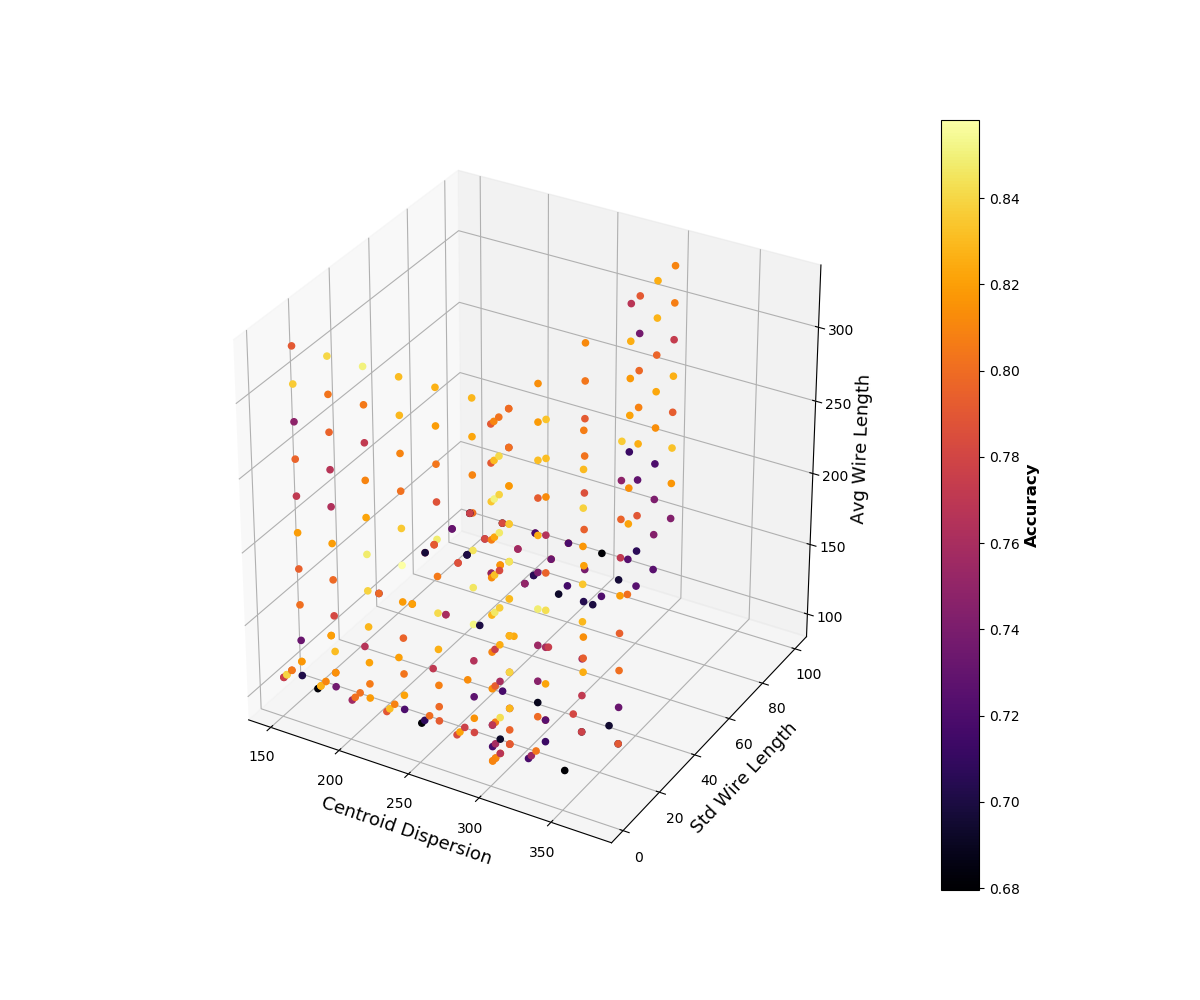

In [62]:
#3D Surface Plot of Parameters vs Accuracy:
%matplotlib notebook  

from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
X=[]#[[None]*10 for i in range(len(ASN300))]
Y=[]#[[None]*10 for i in range(len(ASN300))]
Z=[]#[[None]*10 for i in range(len(ASN300))]
col=[]
for i in range(len(ASN300)):
    temp=[]
    for j in range(len(ASN300[i])):
        Z.append(ASN300[i][j]['avg_length'])
        Y.append(ASN300[i][j]['dispersion'])
        X.append(ASN300[i][j]['centroid_dispersion'])
        col.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        
X=np.asanyarray(X)
Y=np.asanyarray(Y)
Z=np.asanyarray(Z) 

p=ax.scatter(X, Y, Z,cmap=plt.cm.inferno, c=col,s=20,alpha=1)
cb=fig.colorbar(p)
ax.set_xlabel('Centroid Dispersion',fontsize=13)
ax.set_ylabel('Std Wire Length',fontsize=13)
ax.set_zlabel('Avg Wire Length',fontsize=13)

cb.set_label(label='Accuracy', size='large', weight='bold')
plt.show();

<IPython.core.display.Javascript object>


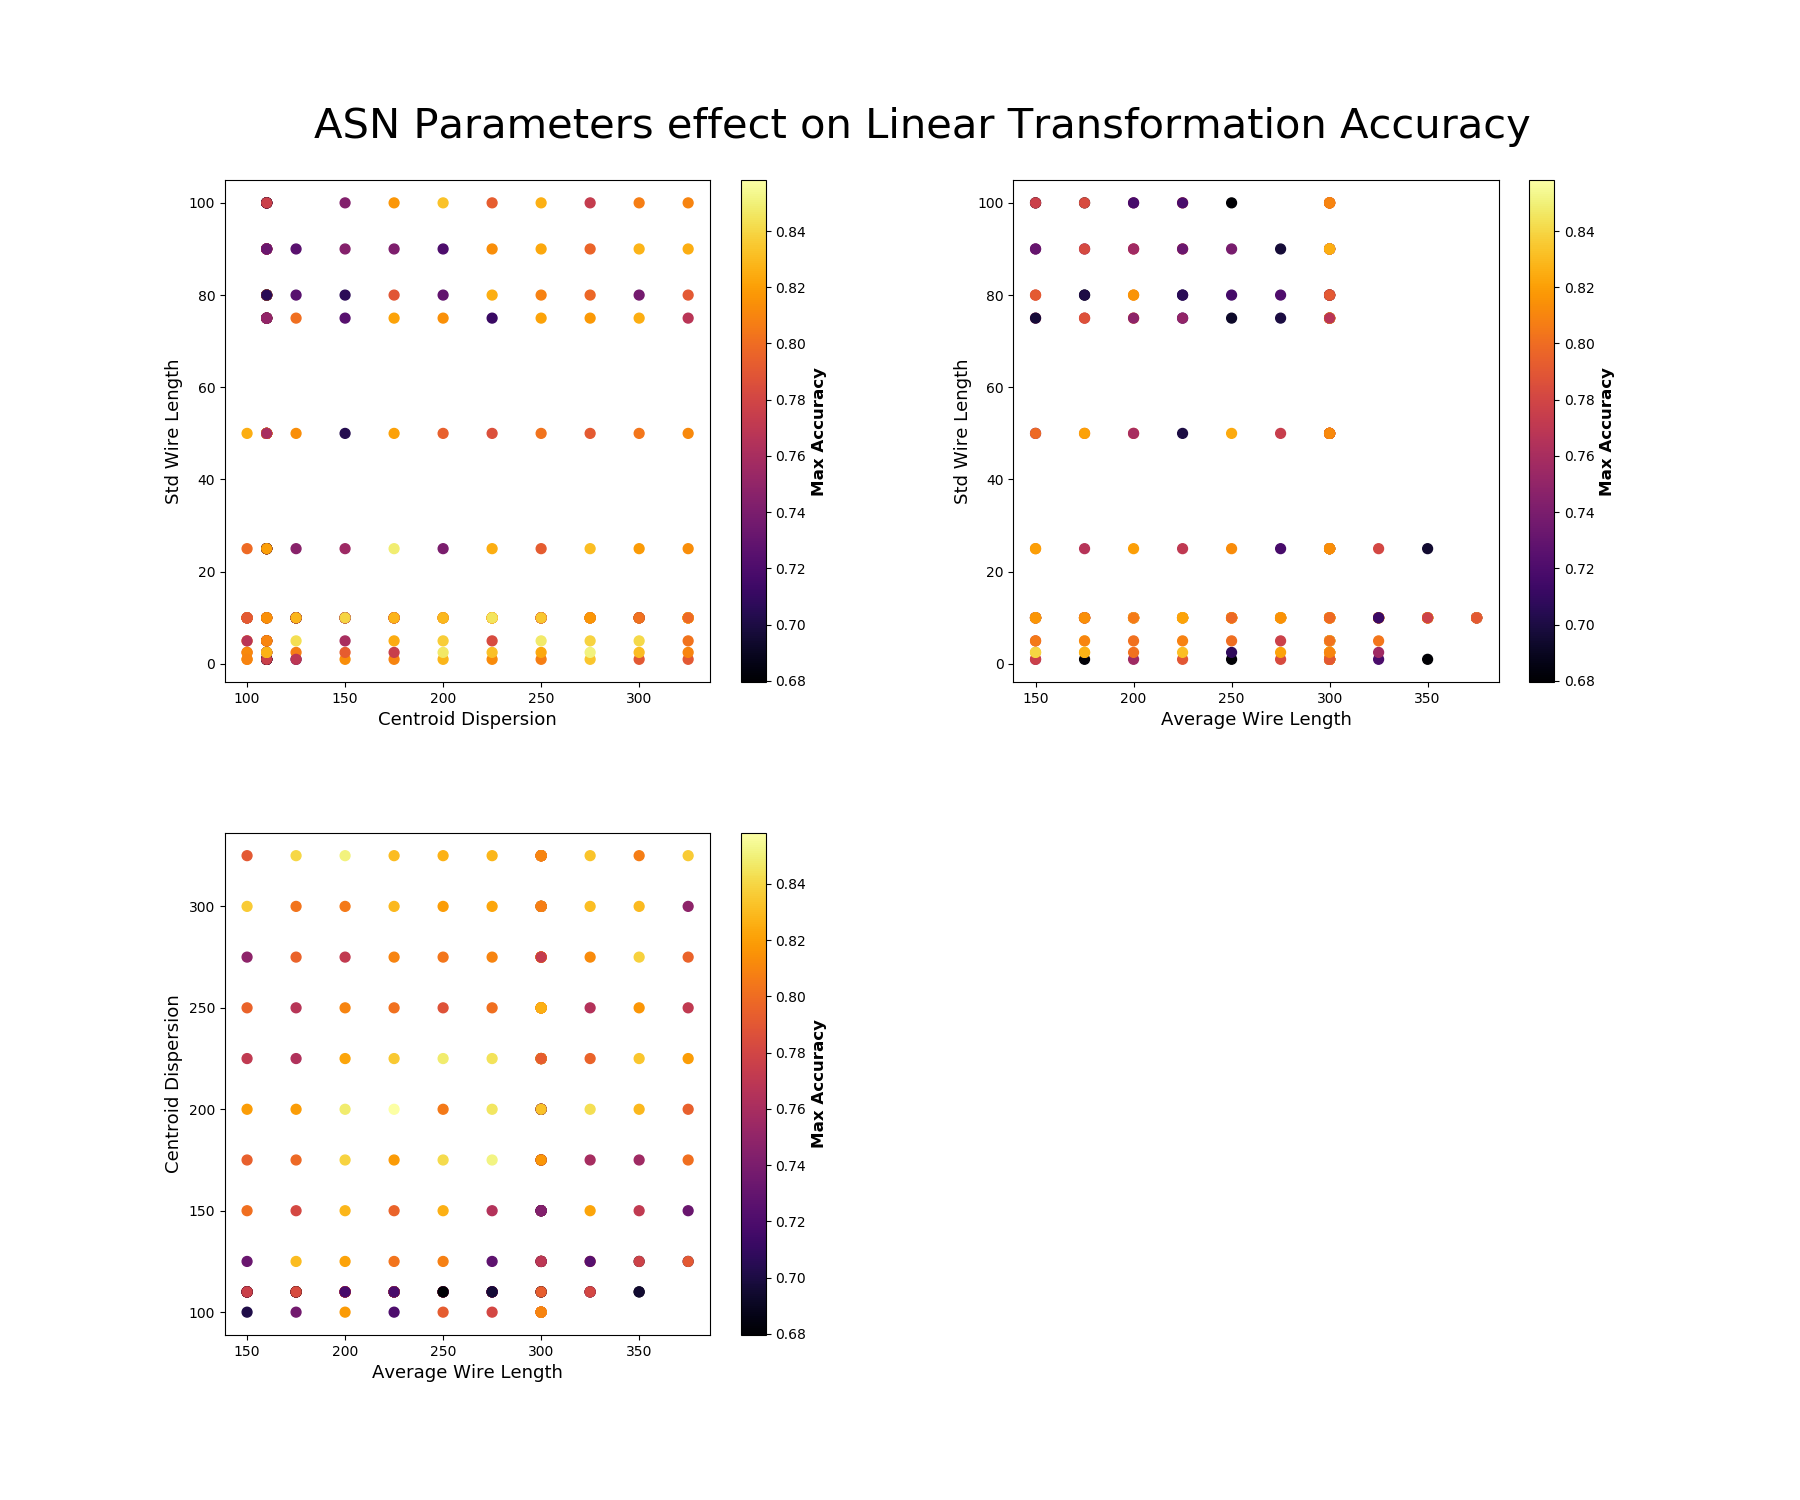

In [62]:
#3D Surface Plot of Parameters vs Accuracy:
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig1=plt.figure(figsize=(18,15))

ax=[None]*4
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_xticks([])
axBig.set_yticks([])
axBig.set_frame_on(False)
plt.title('ASN Parameters effect on Linear Transformation Accuracy',fontsize=30,pad=30)


X=[]#[[None]*10 for i in range(len(ASN300))]
Y=[]#[[None]*10 for i in range(len(ASN300))]
Z=[]#[[None]*10 for i in range(len(ASN300))]
col=[]

for i in range(len(ASN300)):
    temp=[]
    for j in range(len(ASN300[i])):
        Z.append(ASN300[i][j]['avg_length'])
        Y.append(ASN300[i][j]['dispersion'])
        X.append(ASN300[i][j]['centroid_dispersion'])
#         Z[i][j]=(np.max(ASN300[i][j]['Accuracy']['Linear Transformation']))
        col.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))

X=np.asanyarray(X)
Y=np.asanyarray(Y)
Z=np.asanyarray(Z)



ax[0]=fig1.add_subplot(2, 2, 1)

fig1.subplots_adjust(wspace=.3)
fig1.subplots_adjust(hspace=.3)
p2=plt.scatter(Z,Y,cmap=plt.cm.inferno,c=col,s=50,alpha=1)
plt.xlabel('Centroid Dispersion',fontsize=13)
plt.ylabel('Std Wire Length',fontsize=13)
cb=fig.colorbar(p2,ax=ax[0])


cb.set_label(label='Max Accuracy', size='large', weight='bold')

ax[1]=fig1.add_subplot(2, 2, 2)
p2=plt.scatter(X, Y,cmap=plt.cm.inferno,c=col,s=50,alpha=1)
plt.xlabel('Average Wire Length',fontsize=13)
plt.ylabel('Std Wire Length',fontsize=13)
cb=fig.colorbar(p2,ax=ax[1])

# ax.set_zlabel('Accuracy',fontsize=13)

cb.set_label(label='Max Accuracy', size='large', weight='bold')
ax[2]=fig1.add_subplot(2, 2, 3)
p1=plt.scatter(X, Z,cmap=plt.cm.inferno,c=col,s=50,alpha=1)
plt.xlabel('Average Wire Length',fontsize=13)
plt.ylabel('Centroid Dispersion',fontsize=13)
cb=fig.colorbar(p1,ax=ax[2])

# ax.set_zlabel('Accuracy',fontsize=13)

cb.set_label(label='Max Accuracy', size='large', weight='bold')


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Parameters_vs_LinearTransformationAccuracy',dpi=300)    
    

### Small Worldness & Degree

<IPython.core.display.Javascript object>


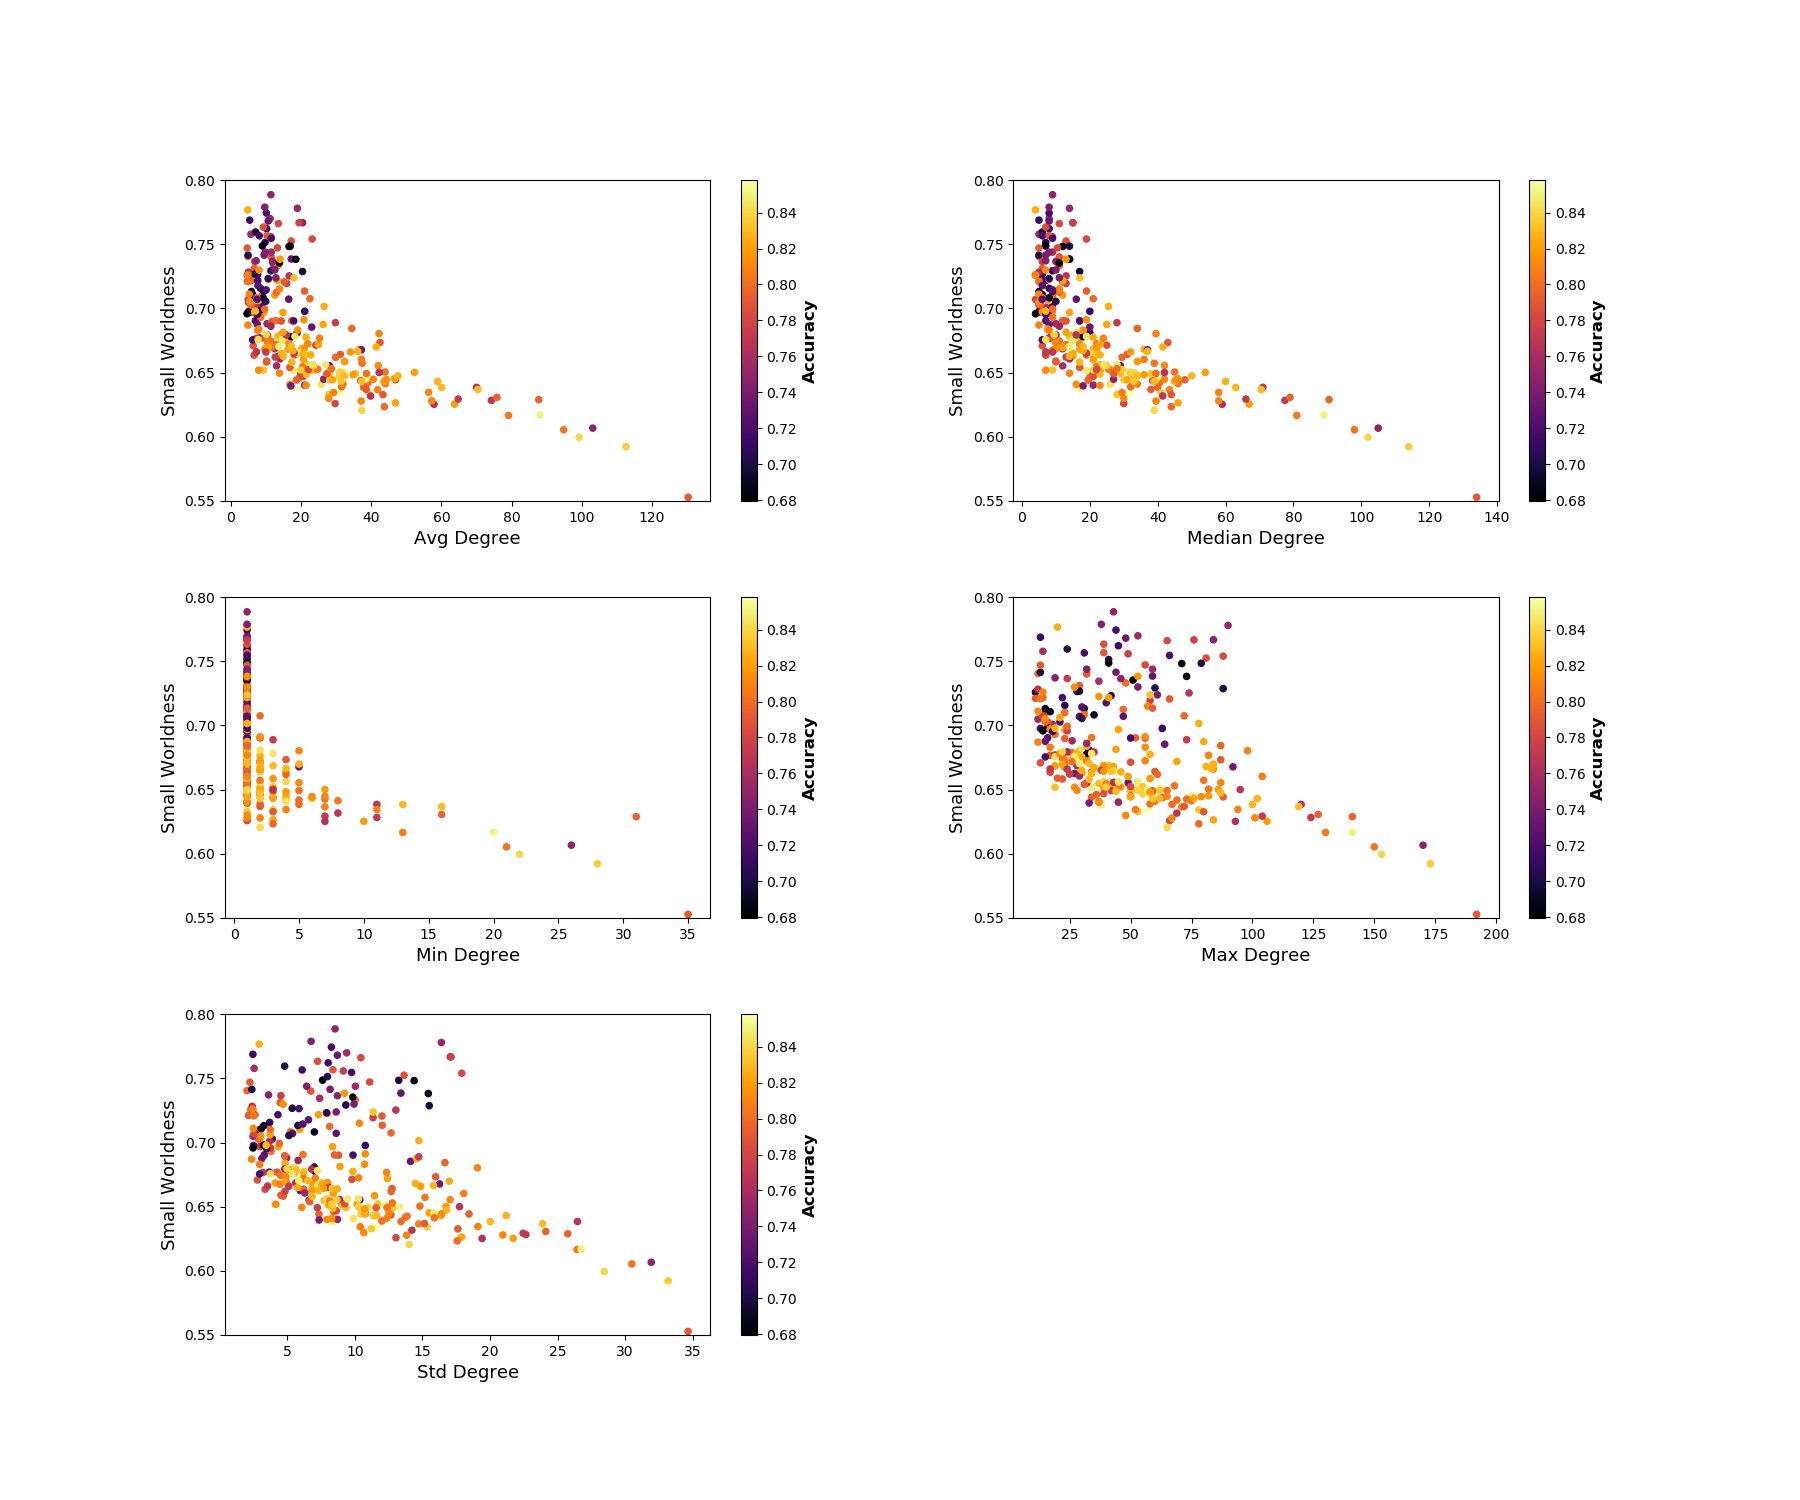

In [63]:
# 2D Plots of Avg Degree vs Small Worldness vs Accuracy
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig1=plt.figure(figsize=(18,15))

ax=[None]*5
# ax = fig.gca(projection='3d')
Y=[]#[[None]*10 for i in range(len(ASN300))]
X={'Mean': [], 'Median': [], 'Min': [], 'Max': [],'Std':[]}#[[None]*10 for i in range(len(ASN300))]
acc=[]


fig1.subplots_adjust(wspace=.3)
fig1.subplots_adjust(hspace=.3)

ax[0]=fig1.add_subplot(3, 2, 1)

for i in range(len(ASN300)):
    temp=[]
    for j in range(len(ASN300[i])):
        degree = [val for (node, val) in ASN300[i][j]['G'].degree()]
        Y.append(ASN300[i][j]['Graph Theory']['Small World'])
        X['Mean'].append(np.mean(degree))
        X['Median'].append(np.median(degree))
        X['Min'].append(np.min(degree))
        X['Max'].append(np.max(degree))
        X['Std'].append(np.std(degree))
        acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        
Y=np.asanyarray(Y)
X0=np.asanyarray(X['Mean'])
X1=np.asanyarray(X['Median'])
X2=np.asanyarray(X['Min'])
X3=np.asanyarray(X['Max'])
X4=np.asanyarray(X['Std'])

p=plt.scatter(X0, Y,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylabel('Small Worldness (swp))',fontsize=13)
plt.xlabel('Avg Degree',fontsize=13)
plt.ylim(0.55,0.80)
cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)

cb.set_label(label='Accuracy', size='large', weight='bold')

ax[1]=fig1.add_subplot(3, 2, 2)
        
p1=plt.scatter(X1, Y,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylim(0.55,0.80)
plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Median Degree',fontsize=13)
cb1=fig.colorbar(p1,ax=ax[1])
# ax.set_zlabel('Accuracy',fontsize=13)
cb1.set_label(label='Accuracy', size='large', weight='bold')


ax[2]=fig1.add_subplot(3, 2, 3)

p2=plt.scatter(X2, Y,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylim(0.55,0.80)
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8])
plt.xlabel('Min Degree',fontsize=13)
plt.ylabel('Small Worldness' (swp),fontsize=13)
cb2=fig.colorbar(p2,ax=ax[2])

# ax.set_zlabel('Accuracy',fontsize=13)
cb2.set_label(label='Accuracy', size='large', weight='bold')


ax[3]=fig1.add_subplot(3, 2, 4)

p3=plt.scatter(X3, Y,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylim(0.55,0.80)
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8])
plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Max Degree',fontsize=13)
cb3=fig.colorbar(p3,ax=ax[3])
# plt.ylabel('Avg Degree',fontsize=13)
# ax.set_zlabel('Accuracy',fontsize=13)
cb3.set_label(label='Accuracy', size='large', weight='bold')

ax[4]=fig1.add_subplot(3, 2, 5)

p4=plt.scatter(X4, Y,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylim(0.55,0.80)
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8])
plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Std Degree',fontsize=13)
cb4=fig.colorbar(p4,ax=ax[4])
# plt.ylabel('Avg Degree',fontsize=13)
# ax.set_zlabel('Accuracy',fontsize=13)
cb4.set_label(label='Accuracy', size='large', weight='bold')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Degree_vs_SmallWorldness_vs_LinearTransformationAccuracy',dpi=600)    

<IPython.core.display.Javascript object>


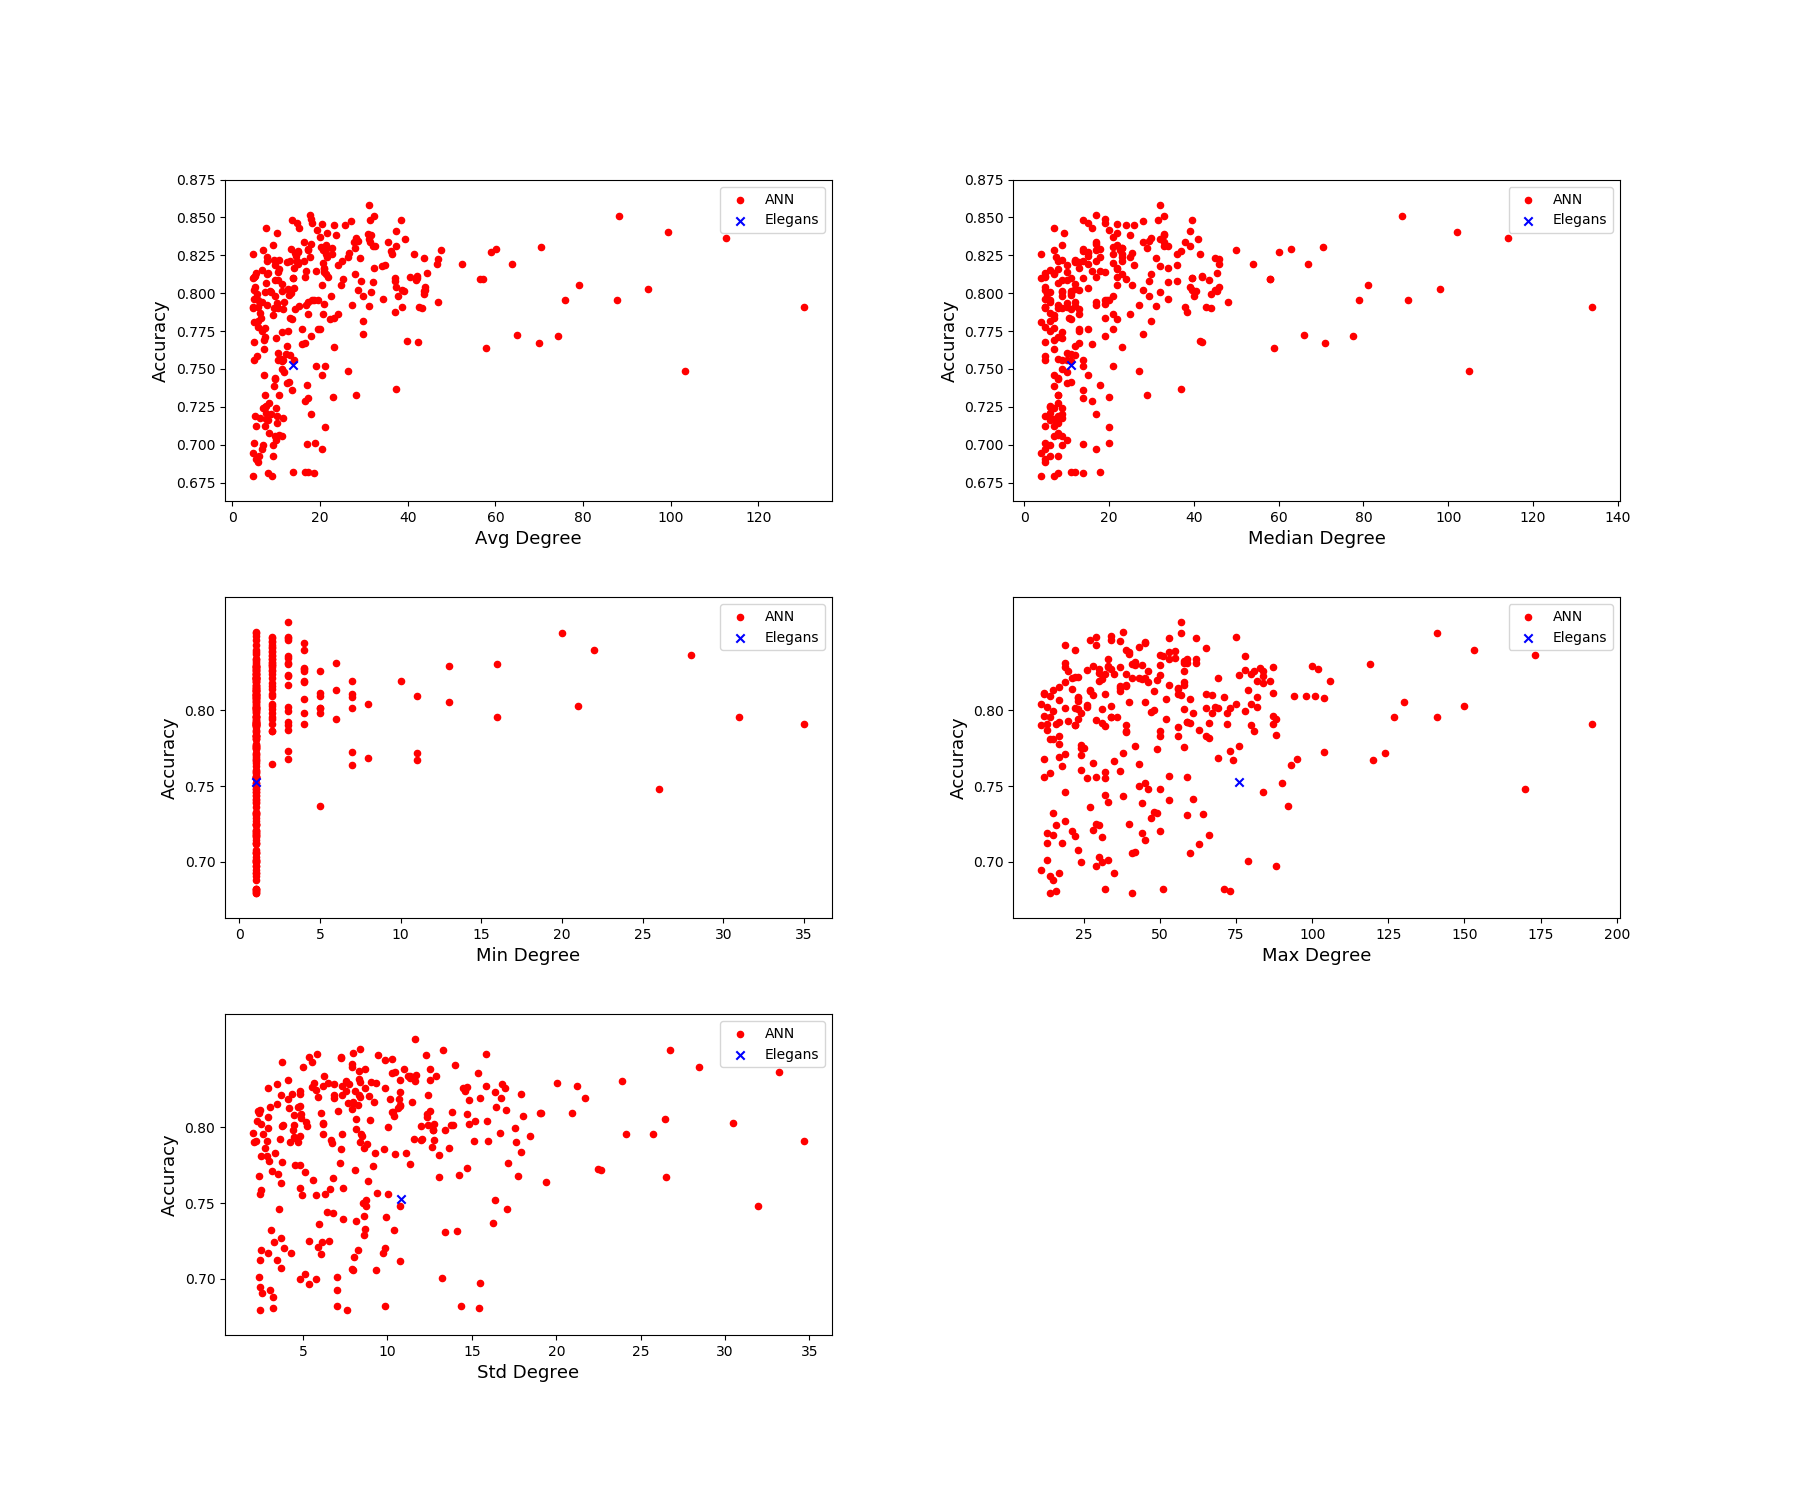

In [64]:
# 2D Plots of Degree vs Accuracy
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig1=plt.figure(figsize=(18,15))

ax=[None]*5
# ax = fig.gca(projection='3d')
Y=[]#[[None]*10 for i in range(len(ASN300))]
X={'Mean': [], 'Median': [], 'Min': [], 'Max': [],'Std':[]}#[[None]*10 for i in range(len(ASN300))]
acc=[]


fig1.subplots_adjust(wspace=.3)
fig1.subplots_adjust(hspace=.3)

ax[0]=fig1.add_subplot(3, 2, 1)

elegansDegree=[val for (node, val) in Elegans['G'].degree()]

for i in range(len(ASN300)):
    temp=[]
    for j in range(len(ASN300[i])):
        degree = [val for (node, val) in ASN300[i][j]['G'].degree()]
        Y.append(ASN300[i][j]['Graph Theory']['Small World'])
        X['Mean'].append(np.mean(degree))
        X['Median'].append(np.median(degree))
        X['Min'].append(np.min(degree))
        X['Max'].append(np.max(degree))
        X['Std'].append(np.std(degree))
        acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        
Y=np.asanyarray(Y)
X0=np.asanyarray(X['Mean'])
X1=np.asanyarray(X['Median'])
X2=np.asanyarray(X['Min'])
X3=np.asanyarray(X['Max'])
X4=np.asanyarray(X['Std'])

p=plt.scatter(X0, acc,cmap=plt.cm.inferno,c='r',s=20,alpha=1,label='ANN')
plt.ylabel('Accuracy',fontsize=13)
plt.xlabel('Avg Degree',fontsize=13)
# plt.ylim(0.55,0.80)
# ax.set_zlabel('Accuracy',fontsize=13)


plt.scatter(np.mean(elegansDegree),np.nanmax(Elegans_Accuracy),label='Elegans',marker='x',color='b')#,0,24,label='Elegans')
plt.legend()


ax[1]=fig1.add_subplot(3, 2, 2)
        
p1=plt.scatter(X1, acc,cmap=plt.cm.inferno,c='r',s=20,alpha=1,label='ANN')
# plt.ylim(0.55,0.80)
plt.ylabel('Accuracy',fontsize=13)
plt.xlabel('Median Degree',fontsize=13)
# ax.set_zlabel('Accuracy',fontsize=13)

plt.scatter(np.median(elegansDegree),np.nanmax(Elegans_Accuracy),label='Elegans',marker='x',color='b')#,0,24,label='Elegans')
plt.legend()



ax[2]=fig1.add_subplot(3, 2, 3)

p2=plt.scatter(X2, acc,cmap=plt.cm.inferno,c='r',s=20,alpha=1,label='ANN')
# plt.ylim(0.55,0.80)
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8])
plt.xlabel('Min Degree',fontsize=13)
plt.ylabel('Accuracy',fontsize=13)

plt.scatter(np.min(elegansDegree),np.nanmax(Elegans_Accuracy),label='Elegans',marker='x',color='b')#,0,24,label='Elegans')
plt.legend()

# ax.set_zlabel('Accuracy',fontsize=13)


ax[3]=fig1.add_subplot(3, 2, 4)

p3=plt.scatter(X3, acc,cmap=plt.cm.inferno,c='r',s=20,alpha=1,label='ANN')
# plt.ylim(0.55,0.80)
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8])
plt.ylabel('Accuracy',fontsize=13)
plt.xlabel('Max Degree',fontsize=13)
# plt.ylabel('Avg Degree',fontsize=13)
# ax.set_zlabel('Accuracy',fontsize=13)

plt.scatter(np.max(elegansDegree),np.nanmax(Elegans_Accuracy),label='Elegans',marker='x',color='b')#,0,24,label='Elegans')
plt.legend()
# cb.set_label(label='Accuracy', size='large', weight='bold')

ax[3]=fig1.add_subplot(3, 2, 5)

p4=plt.scatter(X4, acc,cmap=plt.cm.inferno,c='r',s=20,alpha=1,label='ANN')
# plt.ylim(0.55,0.80)
plt.yticks([0.55,0.6,0.65,0.7,0.75,0.8])
plt.ylabel('Accuracy',fontsize=13)
plt.xlabel('Std Degree',fontsize=13)
# plt.ylabel('Avg Degree',fontsize=13)
# ax.set_zlabel('Accuracy',fontsize=13)

plt.scatter(np.std(elegansDegree),np.nanmax(Elegans_Accuracy),label='Elegans',marker='x',color='b')#,0,24,label='Elegans')
plt.legend()
# cb.set_label(label='Accuracy', size='large', weight='bold')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Degree_vs_LinearTransformationAccuracy',dpi=600)    

### Modularity

<IPython.core.display.Javascript object>


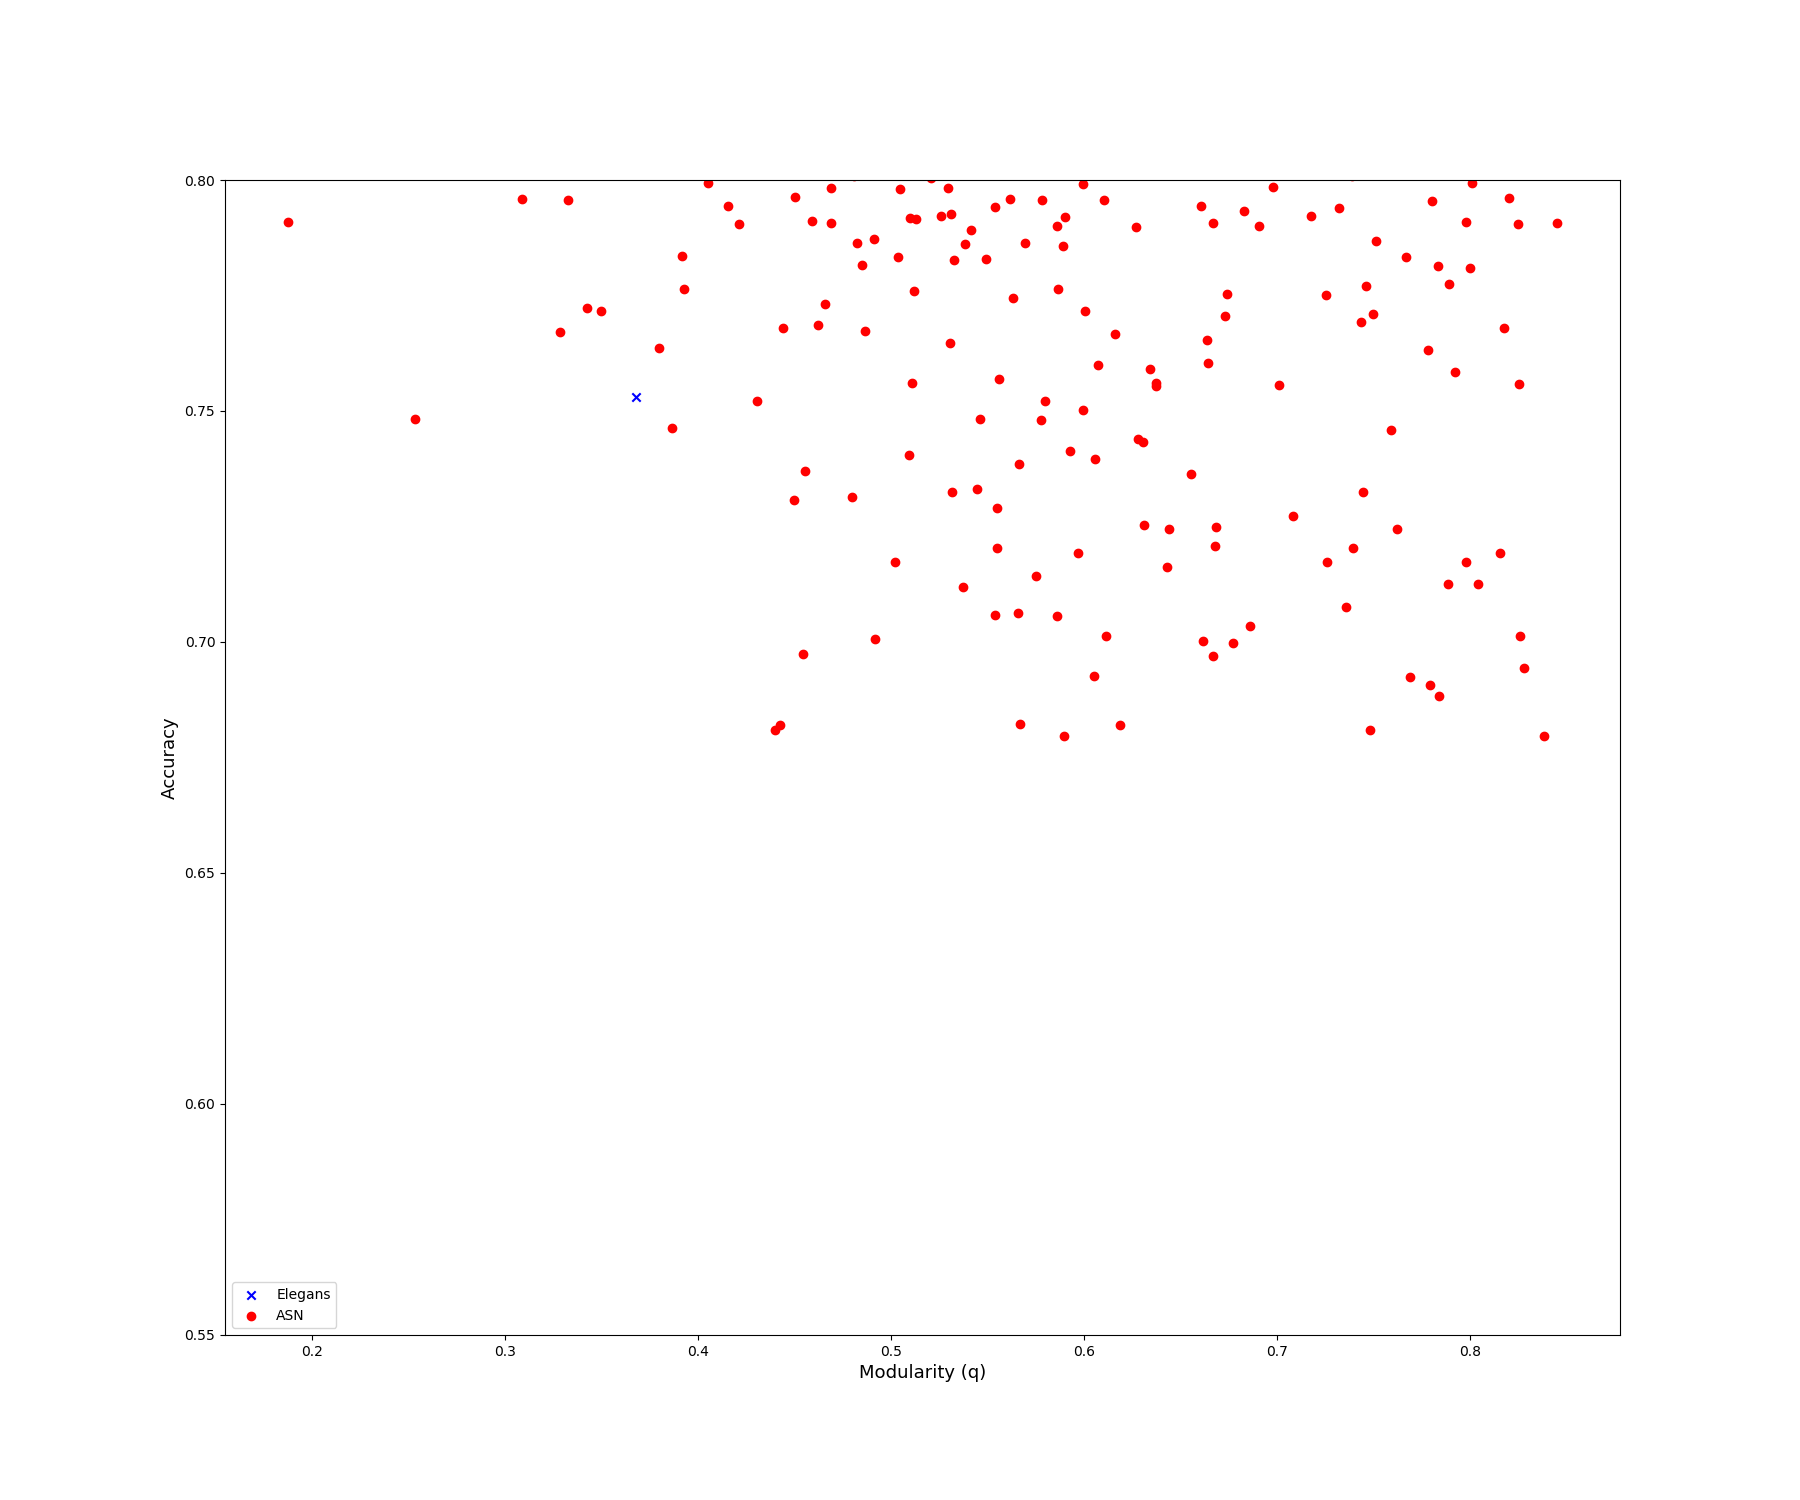

In [70]:
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig1=plt.figure(figsize=(18,15))

# ax = fig.gca(projection='3d')
Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]

for i in range(len(ASN300)):
    temp=[]
    for j in range(len(ASN300[i])):
        degree = [val for (node, val) in ASN300[i][j]['G'].degree()]
        Y.append(ASN300[i][j]['Graph Theory']['Small World'])
        X.append(ASN300[i][j]['Graph Theory']['Modularity Score'])    
        acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        
Y=np.asanyarray(Y)
X=np.asanyarray(X)

plt.scatter(Elegans['Graph Theory']['Modularity Score'],np.nanmax(Elegans_Accuracy),label='Elegans',marker='x',color='b')#,0,24,label='Elegans')


p=plt.scatter(X, acc,color='r',label='ASN')#,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylabel('Accuracy',fontsize=13)
plt.xlabel('Modularity (q)',fontsize=13)
plt.ylim(0.55,0.80)
# cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)
plt.legend()
# cb.set_label(label='Accuracy', size='large', weight='bold')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/ASN_ModularityQ_vs_LinearTransformationAccuracy',dpi=600)    

<IPython.core.display.Javascript object>


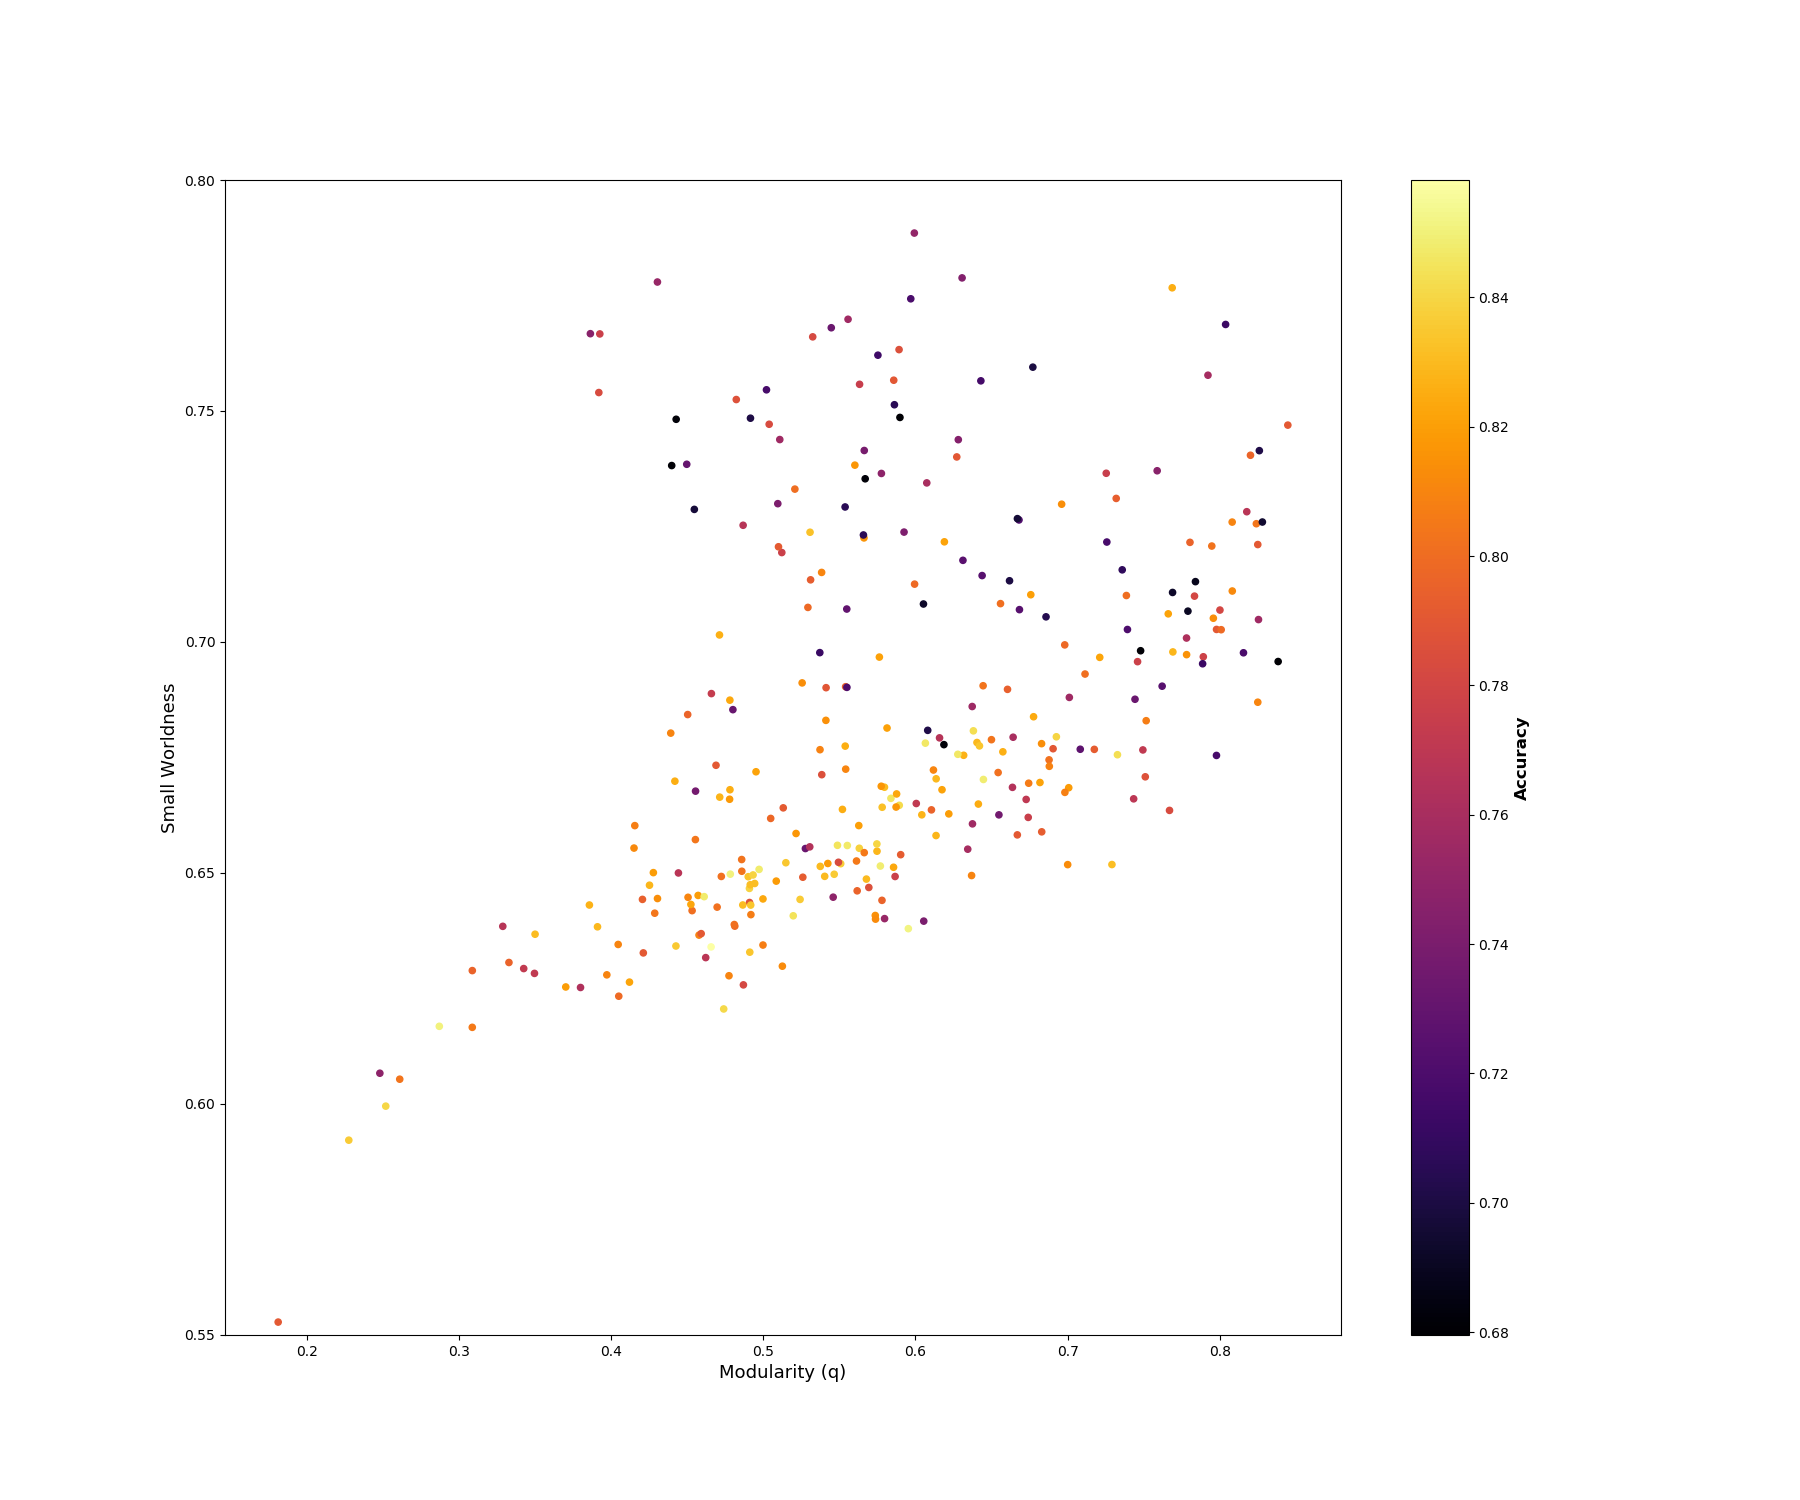

In [68]:
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig1=plt.figure(figsize=(18,15))

# ax = fig.gca(projection='3d')
Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]

for i in range(len(ASN300)):
    temp=[]
    for j in range(len(ASN300[i])):
        degree = [val for (node, val) in ASN300[i][j]['G'].degree()]
        Y.append(ASN300[i][j]['Graph Theory']['Small World'])
        X.append(ASN300[i][j]['Graph Theory']['Modularity Score'])    
        acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        
Y=np.asanyarray(Y)
X=np.asanyarray(X)

p=plt.scatter(X, Y,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Modularity (q)',fontsize=13)
plt.ylim(0.55,0.80)
cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)

cb.set_label(label='Accuracy', size='large', weight='bold')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/ASN_Modularity_vs_SmallWorldness_vs_LinearTransformationAccuracy',dpi=600)    

### Degree 12/05 - need to fix

In [1]:
# fig1=plt.figure(figsize=(15,20))

# ax=[None]*(len(ASN300)*len(ASN300[0]))
# axBig = fig1.add_subplot(111)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# axBig.set_frame_on(False)
# plt.title('Degree Distribution\nASN + C Elegans',fontsize=30,pad=30)
# plt.ylabel('Frequency',fontsize=30,labelpad=15)
# plt.xlabel('Degree',fontsize=30,labelpad=15)

# # plt.ylabel('MZ',fontsize=30,labelpad=15)
# meanDeg=[]
# countAX=0
# for i in range(len(ax)):
# #     if i == len(ax)-1:
# #     else:
#     fig1.subplots_adjust(hspace=.4)
#     dictionary2=dict(Elegans['Graph Theory']['Degree'])
#     dictionary=[]
#     meanDeg=[]
#     for j in range(len(ASN300[i])):
#         ax[countAX]=fig1.add_subplot(len(ax)/15, (len(ax))/20, countAX+1)
#         plt.hist(dictionary2.values(), color='b',label='Elegans')
#         dictionary=(dict(ASN300[i][j]['Graph Theory']['Degree']))
#         fig1.subplots_adjust(hspace=.3)
#     #     ax[i].set_title('ASN Network ' + str(i+1),fontsize=15)
#         meanDeg.append(np.mean(list(dictionary.values())))
#         plt.hist(dictionary.values(), color='r',label='ASN')
#         plt.text(0.5,0.6,'Avg DEG:'+"{0:.2f}".format(meanDeg[j]),transform=ax[countAX].transAxes,fontsize=10) #this plots Smallworldness as text in a relative position on each subplot
#         if i == 0:
#             plt.legend()
#         print(countAX)
#         countAX=countAX+1
        


# # plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\'Degree ASN vs C Elegans.jpg')


NameError: name 'plt' is not defined

### Small Worldness & Path Length

In [ ]:
# 2D Plots of Avg Path Length vs Avg Degree vs Accuracy
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig1=plt.figure(figsize=(6,5))

# ax = fig.gca(projection='3d')
Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]

for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        degree = [val for (node, val) in ASN300[i][j]['G'].degree()]
        Y.append(np.mean(degree))
        X.append(ASN300[i][j]['Graph Theory']['AvgPL'])
        acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        
Y=np.asanyarray(Y)
X=np.asanyarray(X)

p=plt.scatter(X, Y,cmap=plt.cm.inferno,c=acc,s=20,alpha=1)
plt.ylabel('Avg Degree',fontsize=13)
plt.xlabel('Avg PL',fontsize=13)
plt.title('Avg Path length vs Avg Degree vs Accuracy')
# plt.ylim(0.55,0.80)
cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)

cb.set_label(label='Accuracy', size='large', weight='bold')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/AvgPL_vs_AvgDEG_vs_LinearTransformationAccuracy',dpi=600)    

### Circuit Rank

In [ ]:
# Circuit rank = Edges - (Vertices - 1)

# 2D Plots of Avg Path Length vs Avg Degree vs Accuracy
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig1=plt.figure(figsize=(6,5))

# ax = fig.gca(projection='3d')
Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]

for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        cRank=ASN300[i][j]['number_of_junctions']-(ASN300[i][j]['number_of_wires']-1)
        X.append(cRank)
        acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        
# Y=np.asanyarray(Y)
X=np.asanyarray(X)

p=plt.scatter(X,acc, c='b',s=20,alpha=1)
plt.ylabel('Avg Degree',fontsize=13)
plt.xlabel('Avg PL',fontsize=13)
plt.title('Avg Path length vs Avg Degree vs Accuracy')
# plt.ylim(0.55,0.80)
# cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)

cb.set_label(label='Accuracy', size='large', weight='bold')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Circuit_Rank_vs_LinearTransformationAccuracy',dpi=600)    


## Node Level Measures

<IPython.core.display.Javascript object>


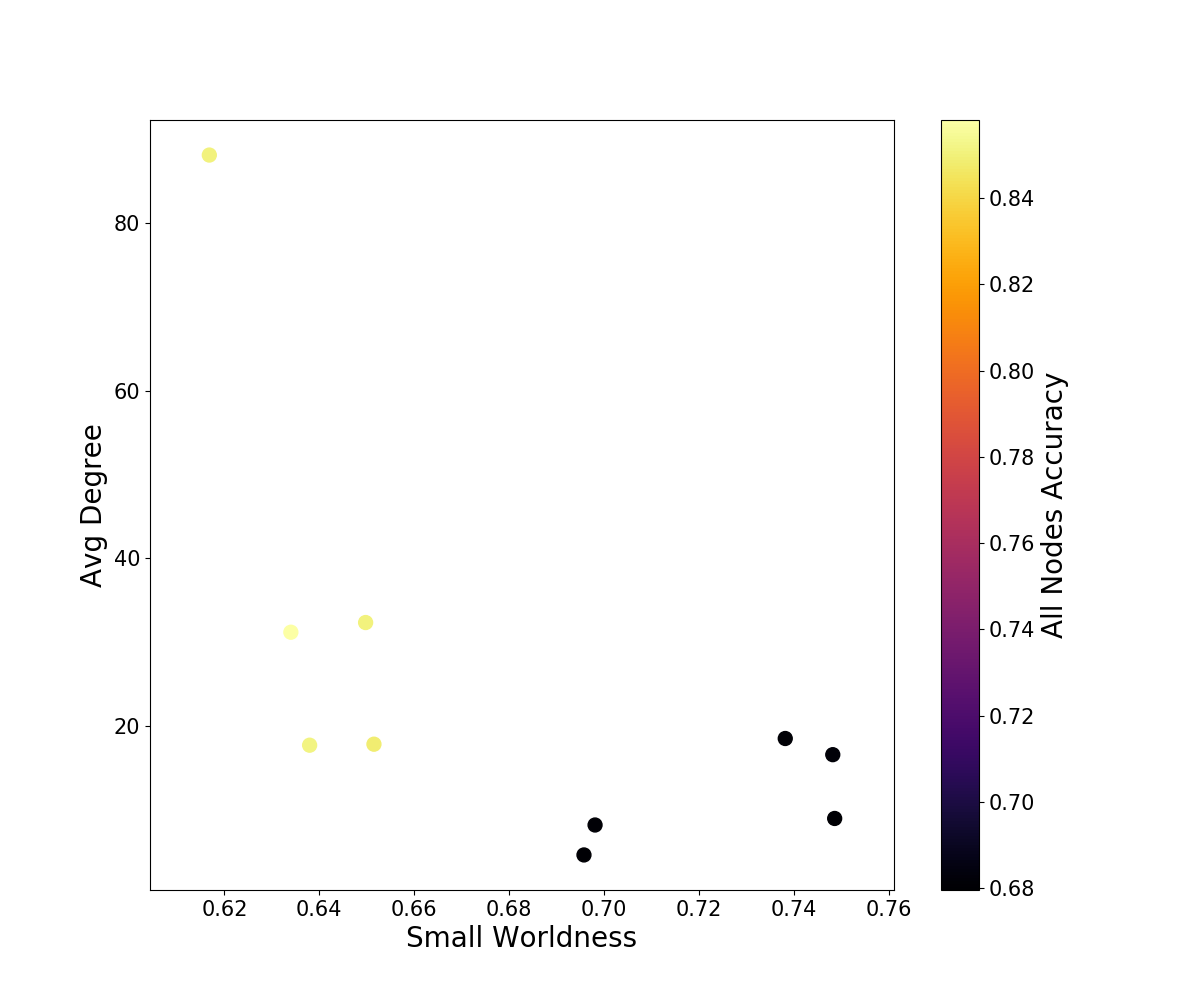

In [76]:
#Step 1: Find Top 5 best accuracy and 5 worst accuracy networks


#Find top 5 accuracy and bottom 5 accuracy networks
count=0
accuracy=[None]*300
for i in range(len(ASNaccuracy[-1])):
    for j in range(len(ASNaccuracy[-1][i])):
        accuracy[count]=ASNaccuracy[-1][i][j]
        count=count+1

idx_acc=np.argsort(accuracy)
accuracy2=np.sort(accuracy)
min_idx_acc=idx_acc[0:5]
min_accuracy=accuracy2[0:5]
max_idx_acc=idx_acc[-5:]
max_accuracy=accuracy2[-5:]

MaxAcc=[]        
for i in range(len(max_idx_acc)):
    if max_idx_acc[i] >= 100: 
        MaxAcc.append([int(float(max_idx_acc[i])/10),list(map(int, str(max_idx_acc[i])))[-1]])
    elif idx_acc[i] <10: 
        MaxAcc.append([0, list(map(int, str(idx_max_idx_accacc[i])))[-1]])
    else:
        MaxAcc.append(list(map(int, str(max_idx_acc[i]))))

MinAcc=[]        
for i in range(len(min_idx_acc)):
    if min_idx_acc[i] >= 100: 
        MinAcc.append([int(float(min_idx_acc[i])/10),list(map(int, str(min_idx_acc[i])))[-1]])
    elif min_idx_acc[i] <10: 
        MinAcc.append([0, list(map(int, str(min_idx_acc[i])))[-1]])
    else:
        MinAcc.append(list(map(int, str(min_idx_acc[i]))))
#3 Plot Networks on Graph:

%matplotlib notebook
fig1=plt.figure(figsize=(12,10))

X=[]
Y=[[None]*10 for i in range(5)]
col=[]
allCol=[None]*300
count=0
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        allCol[count]=(np.max(ASN300[i][j]['Accuracy']['Linear Transformation']))
        count=count+1
        
#MAX ACCURACY
        
for i in range(len(MaxAcc)):
    medDegree=np.median([val for (node, val) in ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G'].degree()])
    stdDegree=np.std([val for (node, val) in ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G'].degree()])
    minDegree=np.min([val for (node, val) in ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G'].degree()])
    maxDegree=np.max([val for (node, val) in ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G'].degree()])
    Y[1][i]=(medDegree)
    Y[2][i]=(stdDegree)
    Y[3][i]=(minDegree)
    Y[4][i]=(maxDegree)
    avgDegree=np.mean([val for (node, val) in ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G'].degree()])
    X.append([ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World']])
    Y[0][i]=(avgDegree)
    col.append(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation']))
                        
for i in range(len(MinAcc)):
    medDegree=np.median([val for (node, val) in ASN300[MinAcc[i][0]][MinAcc[i][1]]['G'].degree()])
    stdDegree=np.std([val for (node, val) in ASN300[MinAcc[i][0]][MinAcc[i][1]]['G'].degree()])
    minDegree=np.min([val for (node, val) in ASN300[MinAcc[i][0]][MinAcc[i][1]]['G'].degree()])
    maxDegree=np.max([val for (node, val) in ASN300[MinAcc[i][0]][MinAcc[i][1]]['G'].degree()])
    Y[1][i+5]=(medDegree)
    Y[2][i+5]=(stdDegree)
    Y[3][i+5]=(minDegree)
    Y[4][i+5]=(maxDegree)
    avgDegree=np.mean([val for (node, val) in ASN300[MinAcc[i][0]][MinAcc[i][1]]['G'].degree()])
    X.append([ASN300[MinAcc[i][0]][MinAcc[i][1]]['Graph Theory']['Small World']])
    Y[0][i+5]=(avgDegree)
    col.append(np.max(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Accuracy']['Linear Transformation']))
                        
X=np.asanyarray(X)
Y[0]=np.asanyarray(Y[0])

p=plt.scatter(X,Y[0],cmap=plt.cm.inferno,c=col,label='ASN',s=100)#,cmap=plt.cm.afmhot,c=col,s=20,alpha=1)
# cb=fig.colorbar(p)
plt.xlabel('Small Worldness (swp)',fontsize=20)
plt.ylabel('Avg Degree',fontsize=20)
# plt.title('Four Networks: 1) Min SW 2) Max SW 3) Min Accuracy 4) Max Accuracy ')
plt.clim(np.min(allCol),np.max(allCol))
cb=fig1.colorbar(p,ax=plt.gca())
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)

cb.set_label(label='All Nodes Accuracy', size=20)
cb.ax.tick_params(labelsize=15)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/5Best_5WorstAccuracies_Degree_vs_SmallWorldness_vs_LinearTransformationAccuracy',dpi=600)    

In [ ]:
fig1=plt.figure(figsize=(12,10))
mask1=[]
mask2=[]
X=np.hstack(X)
for j in range(len(col)):
        mask1.append(col[j] > 0.7)
        mask2.append(col[j] < 0.7)

p1=plt.scatter(X[mask1],np.array(col)[mask1],label='Max Acc Networks',s=100,c='r')#,cmap=plt.cm.afmhot,c=col,s=20,alpha=1)
p2=plt.scatter(X[mask2],np.array(col)[mask2],label='Min Acc Networks|',s=100,c='b')#,cmap=plt.cm.afmhot,c=col,s=20,alpha=1)

# cb=fig.colorbar(p)
plt.xlabel('Small Worldness (swp)',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
# plt.title('Four Networks: 1) Min SW 2) Max SW 3) Min Accuracy 4) Max Accuracy ')
# plt.clim(np.min(allCol),np.max(allCol))
# cb=fig1.colorbar(p,ax=plt.gca())
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)
plt.legend()
# cb.set_label(label='All Nodes Accuracy', size=20)
# cb.ax.tick_params(labelsize=15)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/5Best_5WorstAccuracies_SmallWorldness_vs_LinearTransformationAccuracy',dpi=600)

<IPython.core.display.Javascript object>


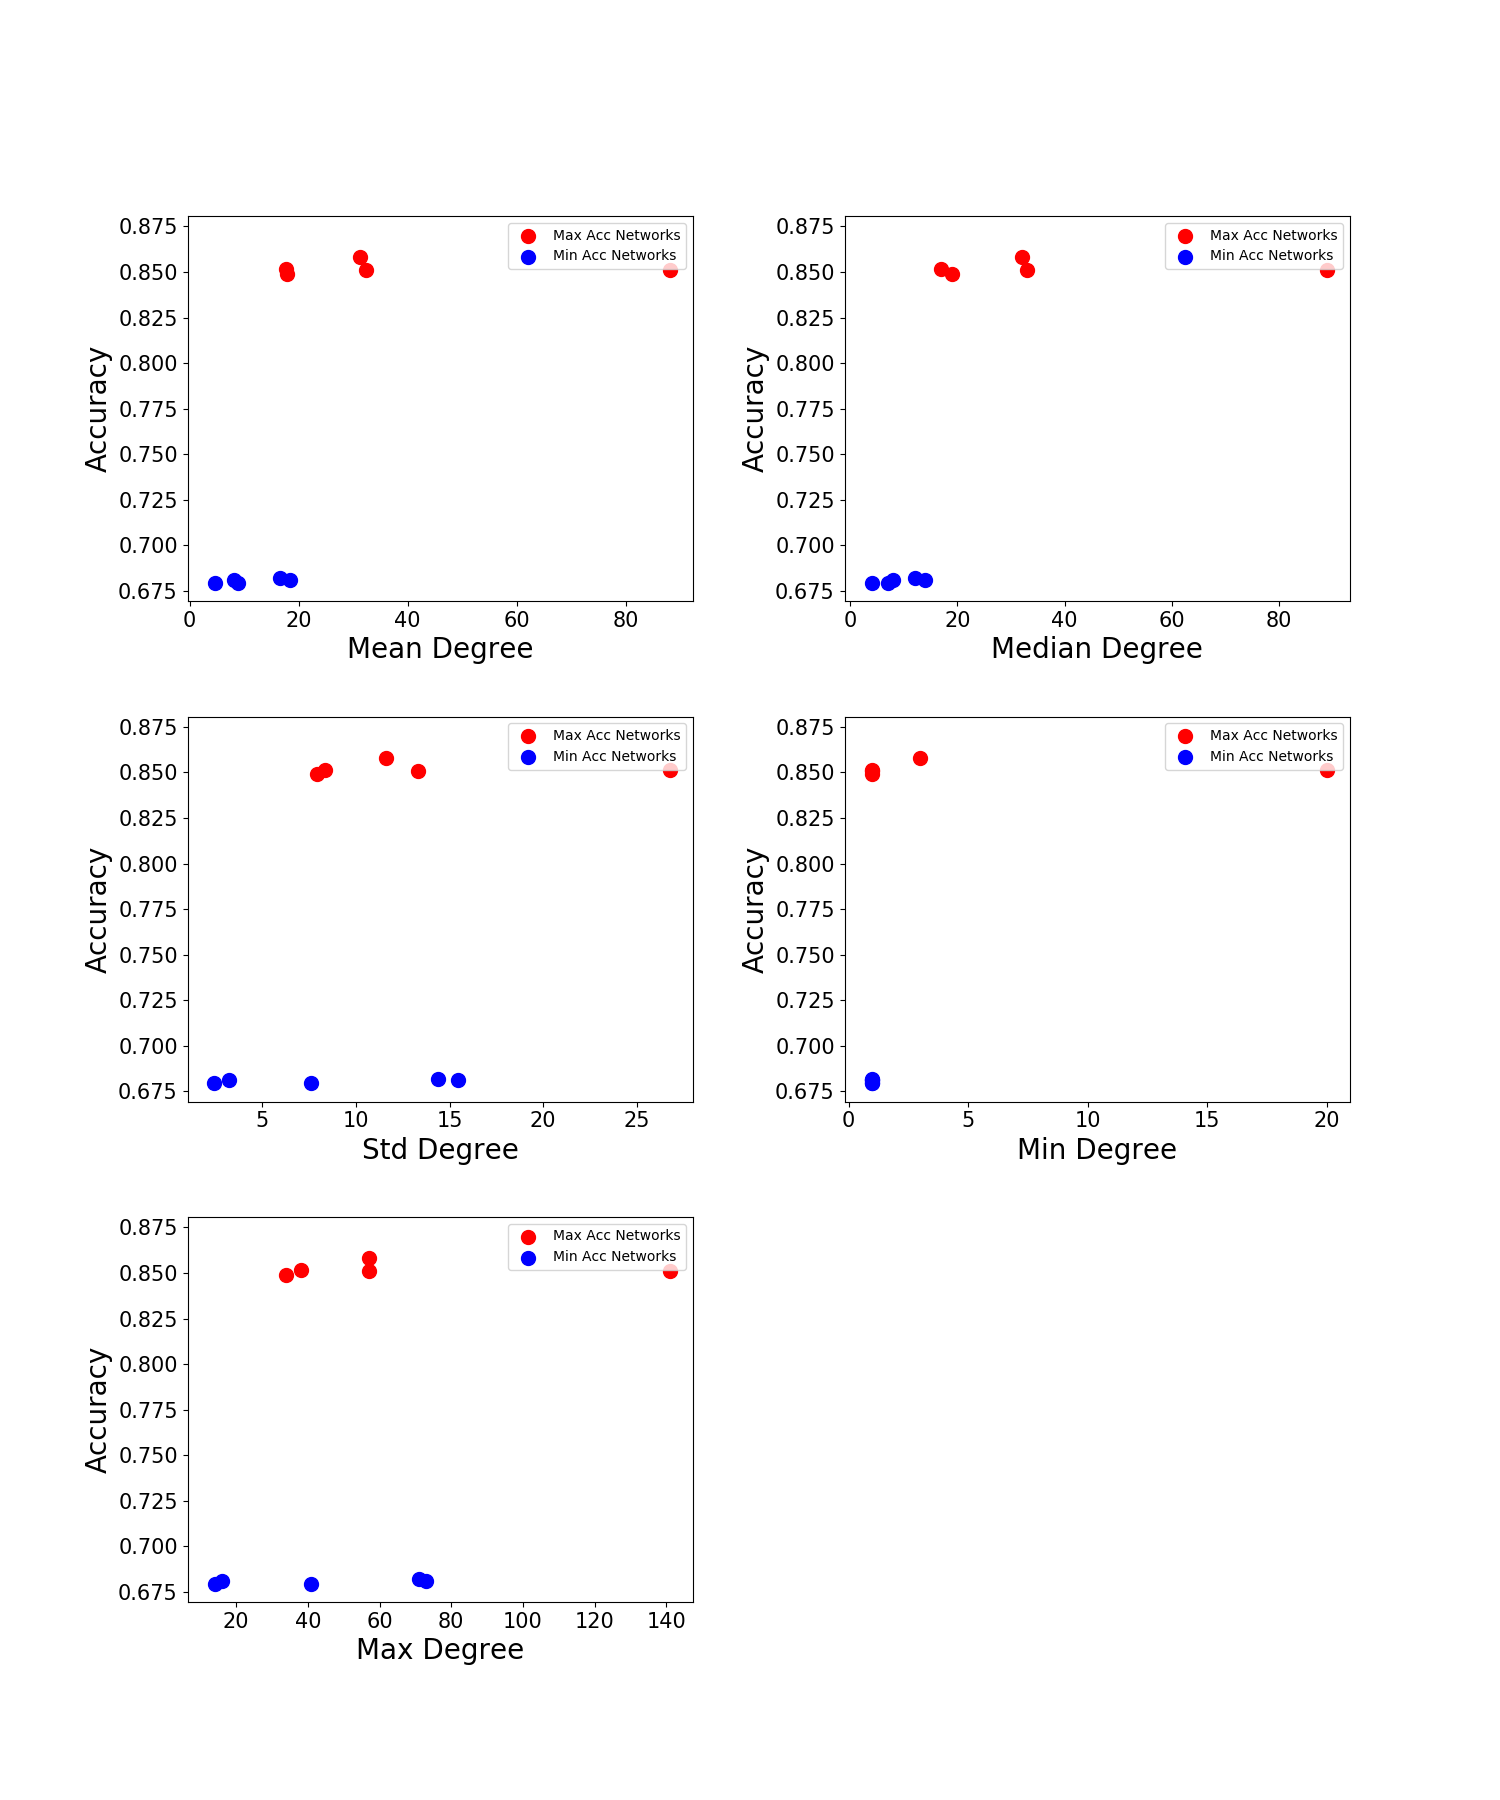

In [77]:
fig1=plt.figure(figsize=(15,18))
ax=[None]*5
fig1.subplots_adjust(hspace=.3)
fig1.subplots_adjust(wspace=.3)
for i in range(len(ax)):
    ax[i]=plt.subplot(3, 2, i+1)
    mask1=[];mask2=[]
    for j in range(len(col)):
        mask1.append(col[j] > 0.7)
        mask2.append(col[j] < 0.7)
    temp=Y[i]
    p=plt.scatter(np.array(temp)[mask1],np.array(col)[mask1],label='Max Acc Networks',s=100,c='r')#,cmap=plt.cm.afmhot,c=col,s=20,alpha=1)
    p=plt.scatter(np.array(temp)[mask2],np.array(col)[mask2],label='Min Acc Networks',s=100,c='b')#,cmap=plt.cm.afmhot,c=col,s=20,alpha=1)
    if i == 0:
        plt.xlabel('Mean Degree',fontsize=20)
    elif i==1:
        plt.xlabel('Median Degree',fontsize=20)
    elif i==2:
        plt.xlabel('Std Degree',fontsize=20)
    elif i==3:
        plt.xlabel('Min Degree',fontsize=20)
    elif i==4:
        plt.xlabel('Max Degree',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)

    ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
    ax[i].tick_params(axis='both', which='minor', labelsize=15)
    plt.legend()
    # cb.set_label(label='All Nodes Accuracy', size=20)
    # cb.ax.tick_params(labelsize=15)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/5Best_5WorstAccuracies_Degree_vs_LinearTransformationAccuracy',dpi=600)

### Participation Coefficient

In [ ]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [80]:
# Modularity, PCoeff, Small Worldness & MZ:
ci = {'Max Accuracy':[None]*len(MaxAcc),'Min Accuracy':[None]*len(MinAcc)}
q={'Max Accuracy':[None]*len(MaxAcc),'Min Accuracy':[None]*len(MinAcc)}
pcoeff= {'Max Accuracy':[None]*len(MaxAcc),'Min Accuracy':[None]*len(MinAcc)}
mz= {'Max Accuracy':[None]*len(MaxAcc),'Min Accuracy':[None]*len(MinAcc)}

for i in range(len(MaxAcc)):#for each network
    ci['Max Accuracy'][i],q['Max Accuracy'][i]=nct.community_louvain(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['adj_matrix'])
    pcoeff['Max Accuracy'][i]=bct.participation_coef(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['adj_matrix'],ci['Max Accuracy'][i])
    mz['Max Accuracy'][i]=bct.module_degree_zscore(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['adj_matrix'],ci['Max Accuracy'][i])

    ci['Min Accuracy'][i],q['Min Accuracy'][i]=nct.community_louvain(ASN300[MinAcc[i][0]][MinAcc[i][1]]['adj_matrix'])
    pcoeff['Min Accuracy'][i]=bct.participation_coef(ASN300[MinAcc[i][0]][MinAcc[i][1]]['adj_matrix'],ci['Min Accuracy'][i])
    mz['Min Accuracy'][i]=bct.module_degree_zscore(ASN300[MinAcc[i][0]][MinAcc[i][1]]['adj_matrix'],ci['Min Accuracy'][i])

<IPython.core.display.Javascript object>


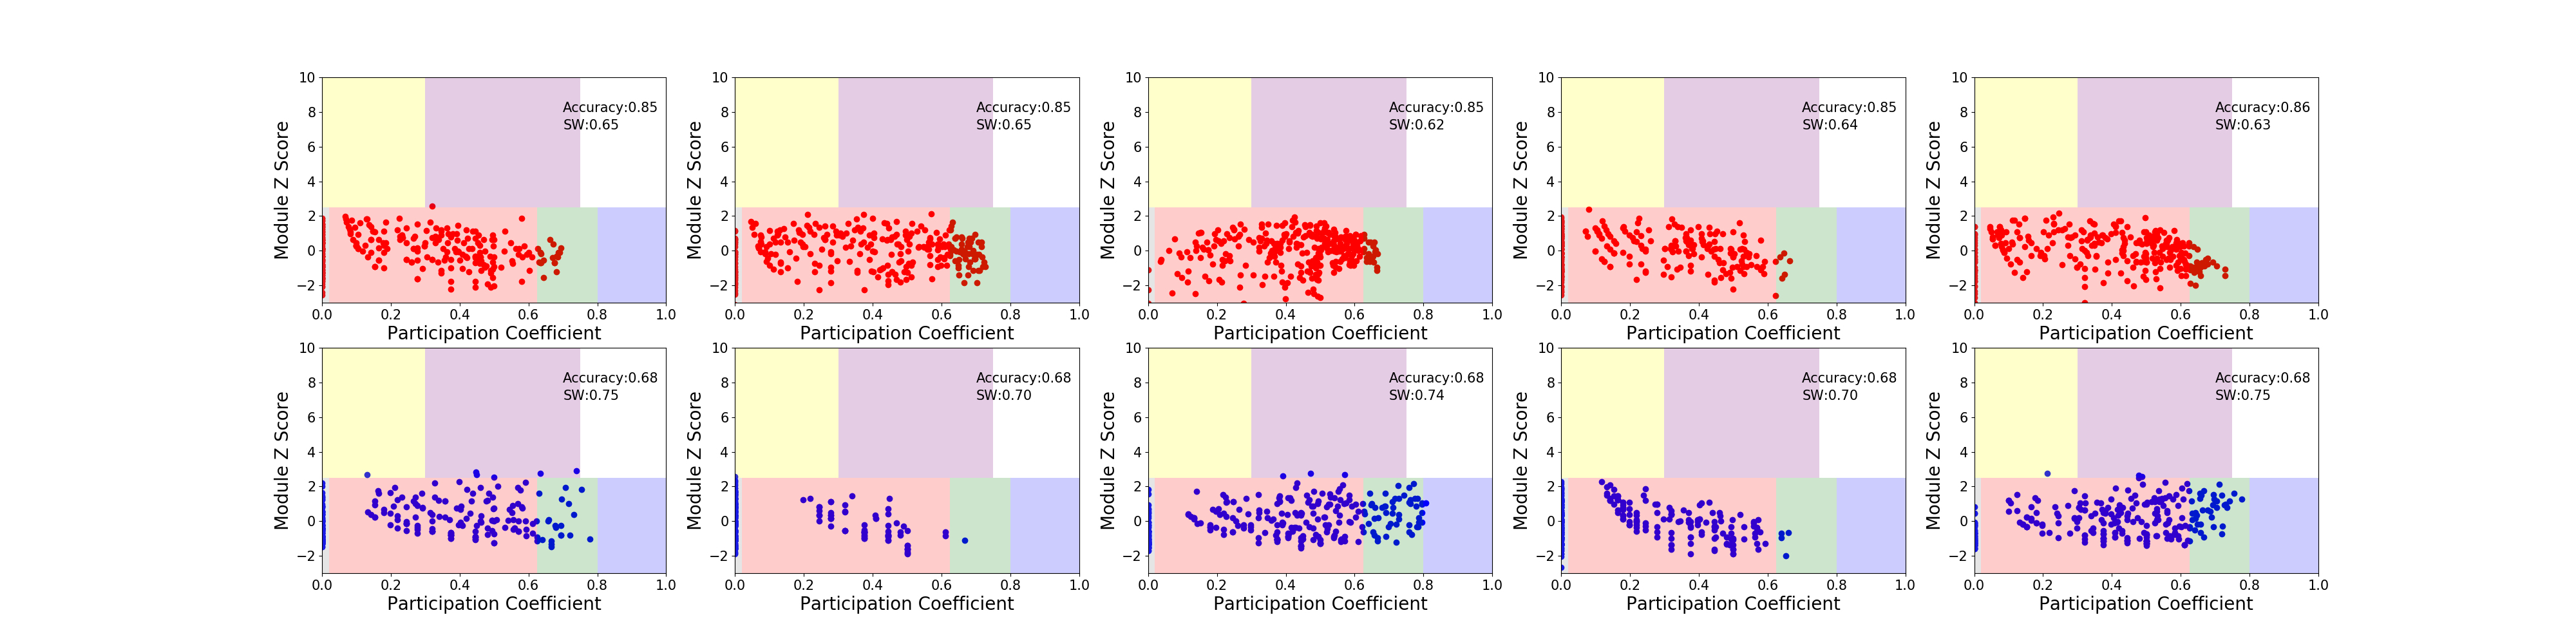

In [82]:
#PCOEFF MZ MAX ACCURACY
from edamame.analysis.misc import draw_zp_space

fig=plt.figure(figsize=(40,10))
ax=[None]*10
for i in range(len(ax)):
    if i < 5:
        ax[i]=plt.subplot(2,5, i+1)
        line = ax[i].scatter(pcoeff['Max Accuracy'][i],mz['Max Accuracy'][i],c='r')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,7,'SW:'+"{0:.2f}".format(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World']),fontsize=15)
        plt.text(0.7,8,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation'])),fontsize=15)
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

    else:
#PCOEFF MZ MIN ACCURACY
        ax[i]=plt.subplot(2, 5, i+1)
        line = ax[i].scatter(pcoeff['Min Accuracy'][i-5],mz['Min Accuracy'][i-5],c='b')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,7,'SW:'+"{0:.2f}".format(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Graph Theory']['Small World']),fontsize=15)
        plt.text(0.7,8,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Accuracy']['Linear Transformation'])),fontsize=15)
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)
    
fig.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/PCoeff vs Module Z Min Accuracy Networks.png',format='png',dpi=600)

In [ ]:
#Histograms for PCoeff:
fig = [None]*2
for i in range(2):
    fig[i]=plt.figure(figsize=(40,10))
    fig[i].subplots_adjust(hspace=.3)
    fig[i].subplots_adjust(wspace=.3)
    ax=[None]*10
    for j in range(len(ax)):
        ax[j]=plt.subplot(2, 5, j+1)
        if i == 0:
            if j < 5:
                plt.hist(mz['Max Accuracy'][j],color='r',label='Max Acc')            
                plt.ylabel('Frequency',fontsize=20)
                plt.xlabel('Within Degree Module z-Score',fontsize=20)
                plt.text(1.7,35,'SW:'+"{0:.2f}".format(ASN300[MaxAcc[j][0]][MaxAcc[j][1]]['Graph Theory']['Small World']),fontsize=13)
                plt.text(1.7,40,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[j][0]][MaxAcc[j][1]]['Accuracy']['Linear Transformation'])),fontsize=13)
                ax[j].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
                ax[j].tick_params(axis='both', which='minor', labelsize=15)
                ax[j].set_ylim(0, 70)
                ax[j].set_xlim(-4,4)
            else:
                plt.hist(mz['Min Accuracy'][j-5],color='b',label='Min Acc')
                plt.ylabel('Frequency',fontsize=20)
                plt.xlabel('Within Degree Module z-Score',fontsize=20)
                plt.text(1.7,35,'SW:'+"{0:.2f}".format(ASN300[MinAcc[j-5][0]][MinAcc[j-5][1]]['Graph Theory']['Small World']),fontsize=13)
                plt.text(1.7,40,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[j-5][0]][MinAcc[j-5][1]]['Accuracy']['Linear Transformation'])),fontsize=13)
                ax[j].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
                ax[j].tick_params(axis='both', which='minor', labelsize=15)
                ax[j].set_ylim(0, 70)
                ax[j].set_xlim(-4,4)
                
        elif i ==1:
            if j < 5:
                plt.hist(pcoeff['Max Accuracy'][j],color='r',label='Max Acc')            
                plt.ylabel('Frequency',fontsize=20)
                plt.xlabel('Participation Coefficient',fontsize=20)
                plt.text(0.7,85,'SW:'+"{0:.2f}".format(ASN300[MaxAcc[j][0]][MaxAcc[j][1]]['Graph Theory']['Small World']),fontsize=13)
                plt.text(0.7,100,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[j][0]][MaxAcc[j][1]]['Accuracy']['Linear Transformation'])),fontsize=13)
                ax[j].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
                ax[j].tick_params(axis='both', which='minor', labelsize=15)
                ax[j].set_ylim(0, 200)
                ax[j].set_xlim(0,1)
            else:
                plt.hist(pcoeff['Min Accuracy'][j-5],color='b',label='Min Acc')
                plt.ylabel('Frequency',fontsize=20)
                plt.xlabel('Participation Coefficient',fontsize=20)
                plt.text(0.7,85,'SW:'+"{0:.2f}".format(ASN300[MinAcc[j-5][0]][MinAcc[j-5][1]]['Graph Theory']['Small World']),fontsize=13)
                plt.text(0.7,100,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[j-5][0]][MinAcc[j-5][1]]['Accuracy']['Linear Transformation'])),fontsize=13)
                ax[j].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
                ax[j].tick_params(axis='both', which='minor', labelsize=15)
                ax[j].set_ylim(0, 200)
                ax[j].set_xlim(0,1)
        if j == 0 or j == 5:
            plt.legend(prop={'size': 15})

fig[0].savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/MZ Min_Max Accuracy Histograms.svg',format='svg',dpi=600)            
fig[1].savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/PCoeff Min_Max Accuracy Histograms.svg',format='svg',dpi=600)

<IPython.core.display.Javascript object>


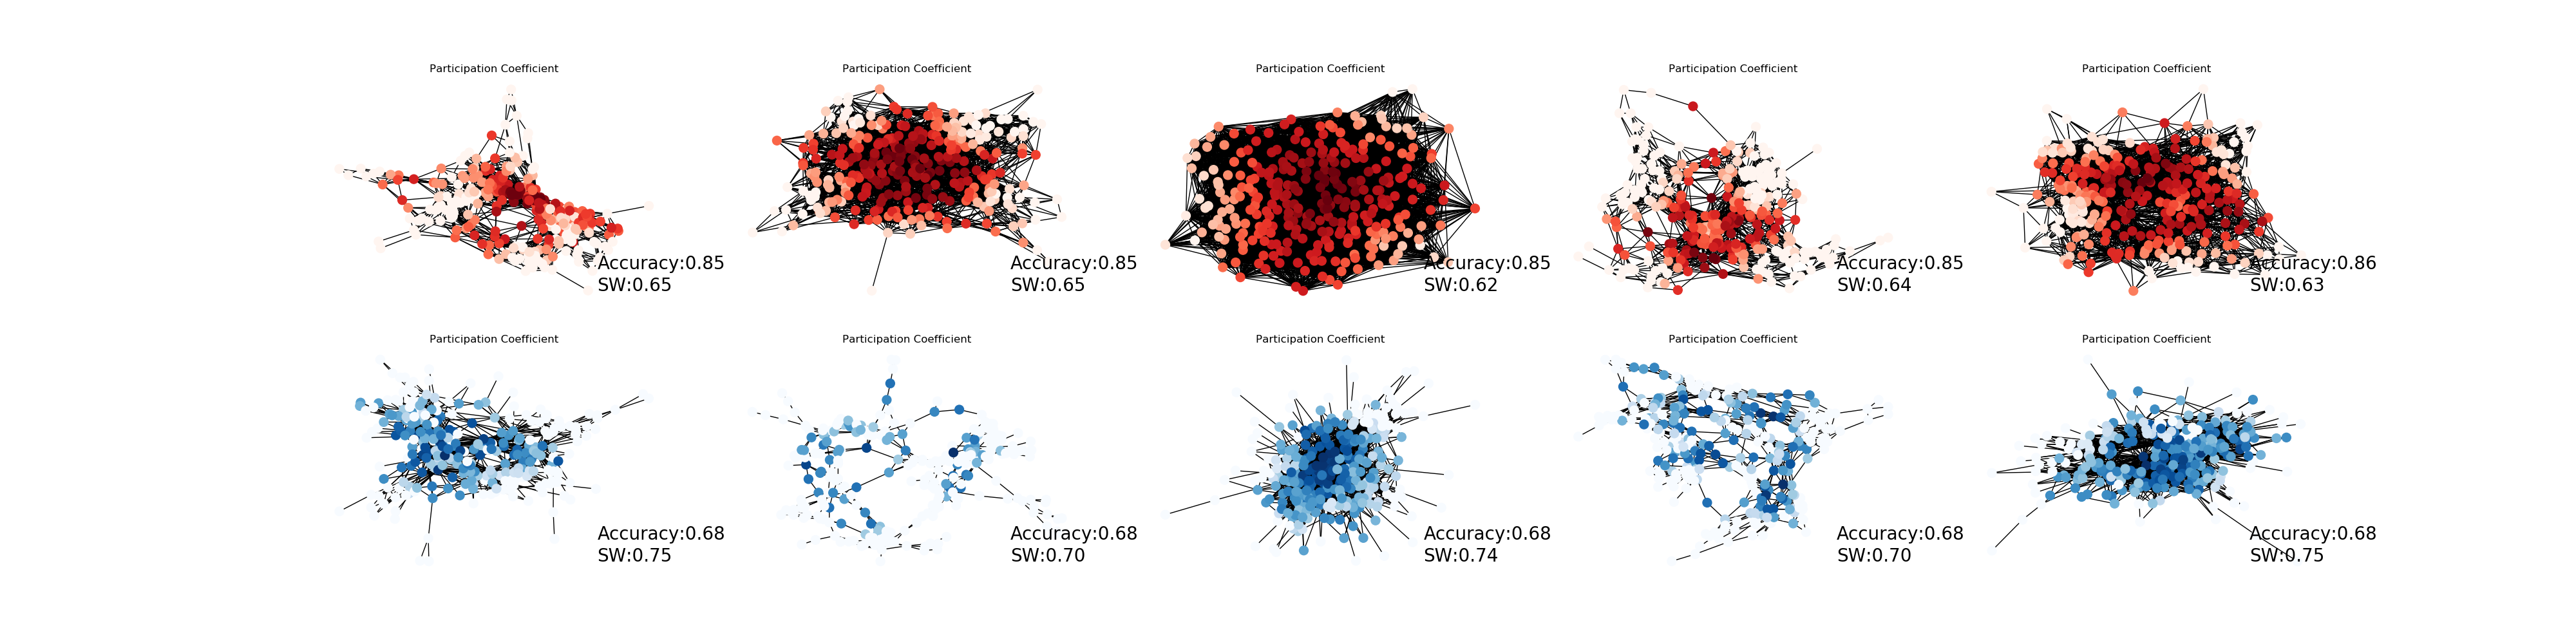

<IPython.core.display.Javascript object>


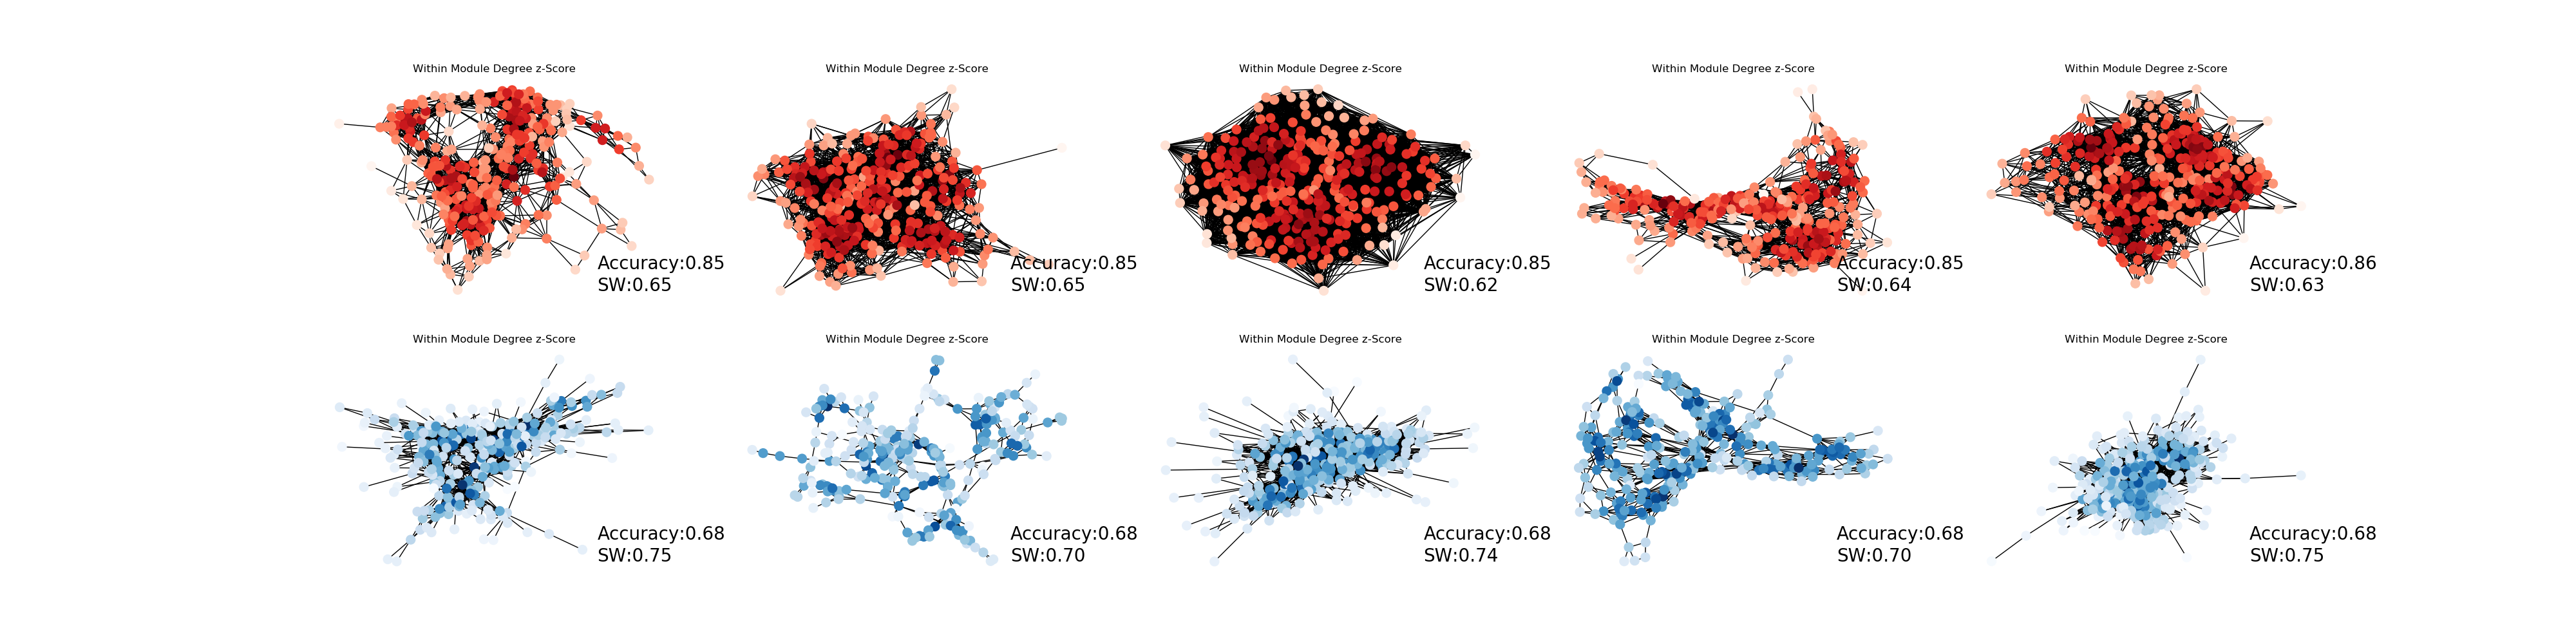

In [88]:
#Draw Participation Coefficient + Module Z for each Network:
from community import community_louvain
fig=plt.figure(figsize=(40,10))
ax=[None]*10
for i in range(len(ax)):
    if i < 5:
        g=ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G']
        partition = community_louvain.best_partition(g)
        pos = community_layout(g, partition)

        ax[i]=fig.add_subplot(2, 5, i+1)
        ax[i].set_title('Participation Coefficient')
        nx.draw(g,node_color=pcoeff['Max Accuracy'][i],cmap=plt.cm.Reds,node_size=100);
        plt.text(0.8,0.15,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
    else:
        g=ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['G']
        partition = community_louvain.best_partition(g)
        pos = community_layout(g, partition)
        
        ax[i]=fig.add_subplot(2, 5, i+1)
        ax[i].set_title('Participation Coefficient')
        nx.draw(g,node_color=pcoeff['Min Accuracy'][i-5],cmap=plt.cm.Blues,node_size=100);
        plt.text(0.8,0.15,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        
        
fig.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/MZ Min_Max Accuracy Graph View.png',format='png',dpi=600)            

fig2=plt.figure(figsize=(40,10))
ax=[None]*10
for i in range(len(ax)):
    if i < 5:
        g=ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G']
        partition = community_louvain.best_partition(g)
        pos = community_layout(g, partition)

        ax[i]=fig2.add_subplot(2, 5, i+1)
        ax[i].set_title('Within Module Degree z-Score')
        nx.draw(g,node_color=mz['Max Accuracy'][i],cmap=plt.cm.Reds,node_size=100);
        plt.text(0.8,0.15,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
    else:
        g=ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['G']
        partition = community_louvain.best_partition(g)
        pos = community_layout(g, partition)
        
        ax[i]=fig2.add_subplot(2, 5, i+1)
        ax[i].set_title('Within Module Degree z-Score')
        nx.draw(g,node_color=mz['Min Accuracy'][i-5],cmap=plt.cm.Blues,node_size=100);
        plt.text(0.8,0.15,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        


fig2.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/MZ Min_Max Accuracy Graph View.png',format='png',dpi=600)

### Centrality

In [ ]:
#Betweenness Centrality MAX SW
fig=plt.figure(figsize=(40,10))
ax=[None]*10
for i in range(len(ax)):
    if i < 5:
        cent=[]
        line=[]
        cent=list(nx.betweenness_centrality(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G']).values())
#         fig1.suptitle('Betweenness Centrality\nMax Acc',fontsize=30)
        ax[i]=plt.subplot(2,5, i+1)
        line = ax[i].hist(cent,bins=20,color='r',label='Max Acc')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('Betweenness Centrality',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('Frequency',fontsize=20)#,labelpad=5)
        ax[i].annotate('Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation'])), xy=(0.9, 0.9), xycoords='axes fraction',textcoords='offset points', fontsize=16,
                    horizontalalignment='right', verticalalignment='top')
        ax[i].annotate('SW:'+"{0:.2f}".format(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World']), xy=(0.9, 0.8), xycoords='axes fraction',textcoords='offset points', fontsize=16,
                    horizontalalignment='right', verticalalignment='top')
        ax[i].set_ylim([0,200])
        ax[i].set_xlim([0,0.05])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)    
    else:
#Betweenness Centrality MIN SW
        cent=[]
        line=[]
        ax[i]=plt.subplot(2, 5, i+1)
        cent=list(nx.betweenness_centrality(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['G']).values())
#         fig2.suptitle('Betweenness Centrality\nMin Acc',fontsize=30)
        line = ax[i].hist(cent,bins=20,color='b',label='Min Acc')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('Betweenness Centrality',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('Frequency',fontsize=20)#,labelpad=5)
        ax[i].set_ylim([0,200])
        ax[i].set_xlim([0,0.5])
        ax[i].annotate('Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Accuracy']['Linear Transformation'])), xy=(0.9, 0.9), xycoords='axes fraction',textcoords='offset points', fontsize=16,
                    horizontalalignment='right', verticalalignment='top')
        ax[i].annotate('SW:'+"{0:.2f}".format(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Graph Theory']['Small World']), xy=(0.9, 0.8), xycoords='axes fraction',textcoords='offset points', fontsize=16,
                    horizontalalignment='right', verticalalignment='top')
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)    
    if i == 0 or i == 5:
        plt.legend(loc='center right')

fig.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Betweenness Centrality Min_Max Accuracy Networks.svg',format='svg',dpi=600)        
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Betweenness Centrality Min Accuracy Networks',dpi=100)
    


<IPython.core.display.Javascript object>


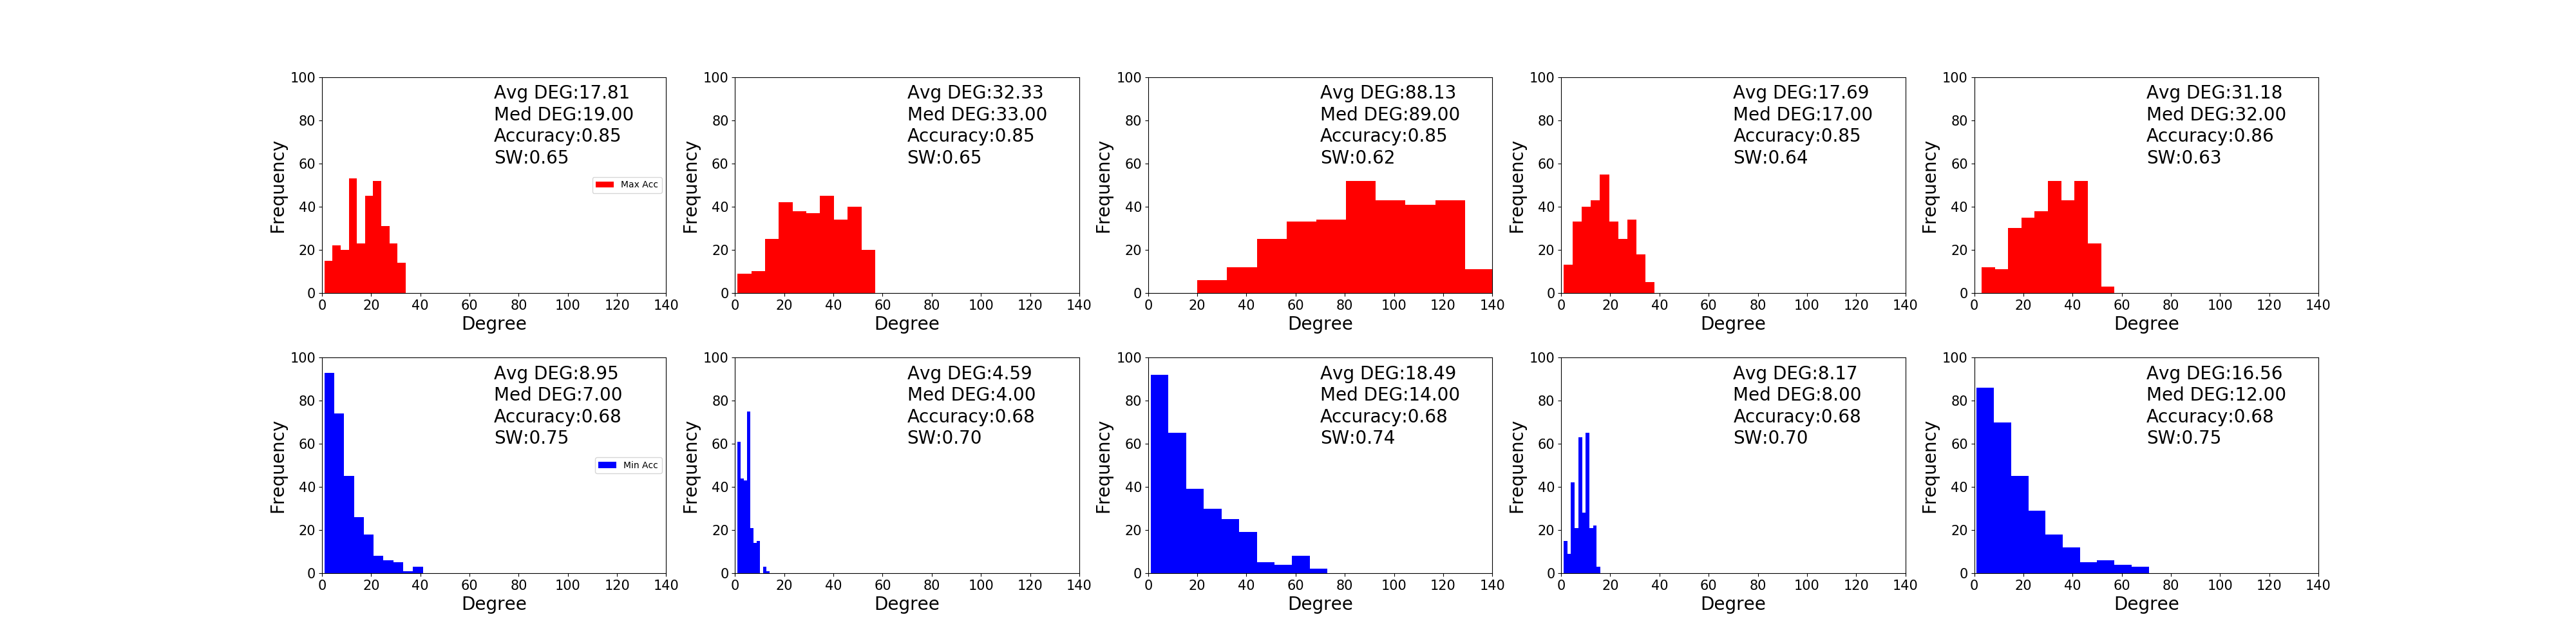

In [111]:
#Plot Degree Histogram MAXIMUM ACC

fig=plt.figure(figsize=(40,10))
ax=[None]*10
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
countAX=0
fig.subplots_adjust(hspace=.3)

for i in range(len(ax)):
    if i < 5:
        ax[i]=plt.subplot(2, 5, i+1)
        dictionary=dict(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Degree'])
        meanDeg=np.mean(list(dictionary.values()))
        medDeg=np.median(list(dictionary.values()))
        plt.text(0.5,0.9,'Avg DEG:'+"{0:.2f}".format(meanDeg),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.8,'Med DEG:'+"{0:.2f}".format(medDeg),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.7,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.6,'SW:'+"{0:.2f}".format(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.hist(dictionary.values(), color='r',label='Max Acc')
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)
        ax[i].set_xlabel('Degree',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('Frequency',fontsize=20)#,labelpad=5)
        ax[i].set_ylim([0,100])
        ax[i].set_xlim([0,140])

    #Plot Degree Histogram MINIMUM ACC
    else:
        ax[i]=plt.subplot(2, 5, i+1)
        dictionary=dict(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Graph Theory']['Degree'])
        meanDeg=np.mean(list(dictionary.values()))
        medDeg=np.median(list(dictionary.values()))
        plt.text(0.5,0.9,'Avg DEG:'+"{0:.2f}".format(meanDeg),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.8,'Med DEG:'+"{0:.2f}".format(medDeg),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.7,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.5,0.6,'SW:'+"{0:.2f}".format(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.hist(dictionary.values(), color='b',label='Min Acc')
        ax[i].set_ylim([0,100])
        ax[i].set_xlim([0,140])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)
        ax[i].set_xlabel('Degree',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('Frequency',fontsize=20)#,labelpad=5)
    if i == 0 or i == 5:
        plt.legend(loc='center right')
            
fig.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Degree Min_Max Accuracy Networks.png',format='png',dpi=600)


### Modularity

In [ ]:
### MODULARITY
from community import community_louvain
fig=plt.figure(figsize=(40,10))
ax=[None]*10
for i in range(len(ax)):
    if i < 5:
        g=ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G']
        partition = community_louvain.best_partition(g)
        pos = community_layout(g, partition)

        ax[i]=fig.add_subplot(2, 5, i+1)
        ax[i].set_title('Graphical Representation')
        nx.draw(g,node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=100);
        plt.text(0.8,0.15,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
    
    else:
        g=ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['G']
        partition = community_louvain.best_partition(g)
        pos = community_layout(g, partition)
        
        ax[i]=fig.add_subplot(2, 5, i+1)
        ax[i].set_title('Graphical Representation')
        nx.draw(g,node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=100);
        plt.text(0.8,0.15,'Accuracy:'+"{0:.2f}".format(np.max(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Accuracy']['Linear Transformation'])),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot
        plt.text(0.8,0.05,'SW:'+"{0:.2f}".format(ASN300[MinAcc[i-5][0]][MinAcc[i-5][1]]['Graph Theory']['Small World']),transform=ax[i].transAxes,fontsize=20) #this plots Smallworldness as text in a relative position on each subplot


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Modularity Min_Max Accuracy Networks.svg',format='svg',dpi=300)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Modularity Min Accuracy Networks',dpi=300)

## Functional Connectivity

### COMMUNICABILITY 12/05 - Need to fix

In [ ]:
#Assign weights to edges based on COMMUNICABILITY:

#Cluster 1:
G_C1=[]
weights_C1=[]
for i in range(len(cluster1)): #for each network
    G_C1.append([None]*len(cluster1[i]['Graph Theory']['COMM Mat']))
    weights_C1.append([None]*len(cluster1[i]['Graph Theory']['COMM Mat']))
    for j in range(len(cluster1[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_C1[i][j]=cluster1[i]['Graph Theory']['Subgraph'][j]
        weights_C1[i][j]=cluster1[i]['Graph Theory']['COMM Mat'][j]
        for e in G_C1[i][j].edges(): #for each edge pairing
            G_C1[i][j][e[0]][e[1]]['weight'] = weights_C1[i][j][e]
            
#Cluster 2:
G_C2=[]
weights_C2=[]
for i in range(len(cluster2)): #for each network
    G_C2.append([None]*len(cluster2[i]['Graph Theory']['COMM Mat']))
    weights_C2.append([None]*len(cluster2[i]['Graph Theory']['COMM Mat']))
    for j in range(len(cluster2[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_C2[i][j]=cluster2[i]['Graph Theory']['Subgraph'][j]
        weights_C2[i][j]=cluster2[i]['Graph Theory']['COMM Mat'][j]
        for e in G_C2[i][j].edges(): #for each edge pairing
            G_C2[i][j][e[0]][e[1]]['weight'] = weights_C2[i][j][e]
            
#Cluster 3:
G_C3=[]
weights_C3=[]
for i in range(len(cluster3)): #for each network
    G_C3.append([None]*len(cluster3[i]['Graph Theory']['COMM Mat']))
    weights_C3.append([None]*len(cluster3[i]['Graph Theory']['COMM Mat']))
    for j in range(len(cluster3[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_C3[i][j]=cluster3[i]['Graph Theory']['Subgraph'][j]
        weights_C3[i][j]=cluster3[i]['Graph Theory']['COMM Mat'][j]
        for e in G_C3[i][j].edges(): #for each edge pairing
            G_C3[i][j][e[0]][e[1]]['weight'] = weights_C3[i][j][e]
            
#C Elegans:
G_E=[]
weights_E=[]
temp=[None]
for i in range(len(temp)): #for each network
    temp[i]=Elegans
    G_E.append([None]*len(temp[i]['Graph Theory']['COMM Mat']))
    weights_E.append([None]*len(temp[i]['Graph Theory']['COMM Mat']))
    for j in range(len(temp[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_E[i][j]=temp[i]['Graph Theory']['Subgraph'][j]
        weights_E[i][j]=temp[i]['Graph Theory']['COMM Mat'][j]
        for e in G_E[i][j].edges(): #for each edge pairing
            G_E[i][j][e[0]][e[1]]['weight'] = weights_E[i][j][e]

In [ ]:
#Plot timeseries:
fig=plt.figure()
plt.plot(stimulus[0][0].signal)#Stimulus[electrode type][network number]
plt.xticks(range(50,151,50),labels=range(500,1501,500))
plt.axvline(50,linestyle='--',color='k')
plt.axvline(150,linestyle='--',color='k')

# PLOT SUBGRAPH ONLY:
fig1=plt.figure(figsize=(15,20))
# for i in range(len(cluster1)):
ax=[None]*(len(cluster1[0]['Graph Theory']['COMM Mat']))

#Find Maximum COMM
vmax1=[]
for i in range(len(G[0])):
    if bool(nx.get_edge_attributes(G[0][i],'weight')):
        edges,weights2 = zip(*nx.get_edge_attributes(G[0][i],'weight').items())
        vmax1.append(max(weights2))
    else:
        weights2=[]
        edges=[]
    
count1=0
times=range(time_index[0][0],time_index[0][1],time_index[0][2])
for j in range(len(cluster1[0]['Graph Theory']['COMM Mat'])): #for each timestamp
    ax[j]=fig1.add_subplot(7,3, j+1)
    ax[j].set_title('Cluster 1, NW 1, Timestamp ' + str(times[j]),fontsize=15)
    if bool(nx.get_edge_attributes(G[0][j],'weight')):
        edges,weights2 = zip(*nx.get_edge_attributes(G[0][j],'weight').items())
    else:
        weights2=[]
        edges=[]
        
    posSub=nx.drawing.layout.kamada_kawai_layout(G[0][j])
    # fig=plt.figure(figsize=(30,30))
    cmap=plt.cm.autumn_r
    vmin = 1
    vmax=max(vmax1)
    
    #NORMALIZE WEIGHTS:
    normalize=plt.Normalize(vmin = vmin, vmax=vmax)
    colors=[cmap(normalize(value)) for value in weights2]
    
    nx.draw(G[0][j],posSub,node_color='k',edgelist=edges,edge_color=colors, width=2,edge_cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []

    plt.colorbar(sm)
    
    count1=count1+1

In [ ]:
# #Plot timeseries:
# fig=plt.figure()
# plt.plot(stimulus[0][0].signal)#Stimulus[electrode type][network number]
# plt.xticks(range(50,151,50),labels=range(500,1501,500))
# plt.axvline(50,linestyle='--',color='k')
# plt.axvline(150,linestyle='--',color='k')
# # plt.xticks(range(0,501,50),labels=range(0,5001,500))

G=[]
clusterNum=3#'E' #CHANGE CLUSTER TO PLOT HERE, for elegans = 'E'
if clusterNum==1:
    G=G_C1
    cluster=cluster1
    accuracy=[[None]*len(cluster1accuracy) for i in range(len(cluster1accuracy[0]))]
    for i in range(len(cluster1accuracy)):
        for j in range(len(cluster1accuracy[i])):
            accuracy[j][i]=cluster1accuracy[i][j]
    count=0
elif clusterNum==2:
    G=G_C2
    cluster=cluster2
    accuracy=[[None]*len(cluster2accuracy) for i in range(len(cluster2accuracy[0]))]
    for i in range(len(cluster2accuracy)):
        for j in range(len(cluster2accuracy[i])):
            accuracy[j][i]=cluster2accuracy[i][j]
    count=len(cluster1)
elif clusterNum==3:
    G=G_C3
    cluster=cluster3
    accuracy=[[None]*len(cluster3accuracy) for i in range(len(cluster3accuracy[0]))]
    for i in range(len(cluster3accuracy)):
        for j in range(len(cluster3accuracy[i])):
            accuracy[j][i]=cluster3accuracy[i][j]
    count=len(cluster1)+len(cluster2)
elif clusterNum=='E':
    G=G_E
    cluster=[None]
    cluster[0]=Elegans
    accuracy=Elegans['Accuracy']['Linear Transformation']

    #Plot Figures
fig=[None]*len(G)
for i in tqdm(range(len(G))): #For Each Network
    #initialise variables:
    pos=[]
    sm=[]
    ax=[None]*(len(cluster[i]['Graph Theory']['COMM Mat']))
    
    #Find Maximum COMM
    vmax1=[]
    for j in range(len(G[i])):
        if bool(nx.get_edge_attributes(G[i][j],'weight')):
            edges,weights2 = zip(*nx.get_edge_attributes(G[i][j],'weight').items())
            vmax1.append(max(weights2))
        else:
            weights2=[]
            edges=[]

    #PLOT NETWORK + COMMUNICABILITY OVERLAYED
    fig[i]=plt.figure(figsize=(40,30))
    pos=nx.drawing.layout.kamada_kawai_layout(cluster[i]['G'])
    for j in range(len(cluster[i]['Graph Theory']['COMM Mat'])): #for each timestamp
        colors=[]
        ax[j]=fig[i].add_subplot(4,5, j+1) #CHANGE THIS FOR MORE/LESS TIMESTAMPS (rows, columns, subplot number)
        ax[j].set_title('Cluster ' + str(clusterNum)+ ', NW ' + str(i+1) + ' Timestamp ' + str(times[j]),fontsize=20)
        nx.draw_networkx(cluster[i]['G'],pos,edge_color='gray',alpha=0.1,with_labels=False,node_size=30)
        colors=range(20)
        cmap=plt.cm.autumn_r
        vmin = 1
        vmax=max(vmax1)

        #NORMALIZE WEIGHTS:
        normalize=plt.Normalize(vmin = vmin, vmax=vmax)
        colors=[cmap(normalize(value)) for value in weights2]
        if clusterNum=='E':
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[results[i].sources[0]],node_color='g',edgelist=[],with_labels=False)
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[results[i].drains[0]],node_color='r',edgelist=[],with_labels=False)
        else:
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[sources[count+i]],node_color='g',edgelist=[],with_labels=False)
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[drains[count+i]],node_color='r',edgelist=[],with_labels=False)
        nx.draw_networkx_edges(cluster[i]['G'],pos,edgelist=G[i][j].edges,edge_color=colors,alpha=0.8, width=3,edge_cmap=cmap)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []

        cb=plt.colorbar(sm)
        cb.set_label(label='Communicability', size='large', weight='bold')
        
        if j == 0:
            if clusterNum == 'E':
                plt.text(0.05,0.9,'Max LT Acc:'+"{0:.2f}".format(np.max(accuracy)),transform=ax[j].transAxes,fontsize=15) #this plots Smallworldness as text in a relative position on each subplot
            else:
                plt.text(0.05,0.9,'Max LT Acc:'+"{0:.2f}".format(np.nanmax(np.array(accuracy[i],dtype=float))),transform=ax[j].transAxes,fontsize=15) #this plots Smallworldness as text in a relative position on each subplot
    if clusterNum=='E':
        plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\Communicability\Communicability Conductance Subgraph Elegans.jpg')
    else:
        plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\Communicability\Communicability Conductance Subgraph Cluster '+ str(clusterNum) +' NW ' + str(i+1) + '.jpg')

### Voltage Sweep for Min and Max networks:

In [90]:
Max_Min_NWS=np.vstack([MaxAcc, MinAcc])
onAmp_MinMax=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]

In [95]:
if (not os.path.isfile(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/All_Max_Min_NWs_Simulations_Voltage_10')):
    for i in range(len(onAmp_MinMax)):
        results_minMax=[None]*len(Max_Min_NWS)
        for j in range(len(Max_Min_NWS)):
            stimulus=[[],[]]
            dt = 1e-2
            f=0.5
            Time=5

            #Choose Electrode Pattern

            stimulus[0].append((stimulus__(biasType='AC',onAmp=onAmp_MinMax[i],TimeVector=np.arange(0,Time,dt),f=f)))
            stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

            #Initialise Output Variables
            period=[]
            TimeVector=[]
            voltage=[]
            conductance=[]
            switches=[]
            # Voltage=[None]*len(ASN300)
            # Switches=[None]*len(ASN300)

            stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
            if j < 5:
                print('Voltage ' + str(onAmp_MinMax[i]) +', Max Accuracy ' + str(j))
            else:
                print('Voltage ' + str(onAmp_MinMax[i]) +', Min Accuracy'  + str(j))
            results_minMax[j]=runSim(connectivity__(wires_dict=ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp_MinMax[i], biasType='AC',f=f,junctionMode='tunneling')

            results_minMax[j].frequency=f
            results_minMax[j].dt=0.001
            period=1/f

            TimeVector=results_minMax[j].TimeVector
            voltage=results_minMax[j].wireVoltage
            conductance=results_minMax[j].conductance
            switches=results_minMax[j].junctionSwitch

        name= r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/All_Max_Min_NWs_Simulations_Voltage_' + str(onAmp_MinMax[i])
        print('Saving Simulations for Voltage ' +str(i+1))
        compressed_pickle([results_minMax],name)

    #     del nwSqu,ResultSqu,TimeVector
else:
    print('Simulations Loaded')

Simulations Loaded


In [ ]:
#Run Regressions
if (not os.path.isfile(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/All_Max_Min_NWs_Simulations_Voltage_10')):
    Acc={'Max':[],'Min':[]}
    Acc['Max']=[[[None]*6 for i in range(len(onAmp_MinMax))] for j in range(len(Max_Min_NWS)/2)]
    Acc['Min']=[[[None]*6 for i in range(len(onAmp_MinMax))] for j in range(len(Max_Min_NWS)/2)]
    for i in tqdm(range(len(onAmp_MinMax))): # Voltages
        print('Loading Voltage ' + str(i+1) +' - All Networks')
        check_memory()
        [results_minMax]=decompress_pickle(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/All_Max_Min_NWs_Simulations_Voltage_'+str(onAmp_MinMax[i]))
        check_memory()
        print('Loaded')
        nodesList_minMax=[[None]*len(Max_Min_NWS) for i in range(len(onAmp_MinMax))]
        for j in range(len(Max_Min_NWS)): #5 Max or 5 Min
    #         del temp
            nwSqu =[None]*numberOfNodeTests
            print('Regressing Voltage ' + str(i+1), ', Network ' + str(j+1))
            TimeVector=results_minMax[j].TimeVector
            voltage=results_minMax[j].wireVoltage
            conductance=results_minMax[j].conductance
            switches=results_minMax[j].junctionSwitch

            target1= (onAmp_MinMax[j] * (-np.sign(TimeVector % period - period/2)))
    #             target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
    #             target3[j] = (onAmp[i]/period * (TimeVector % period))
    #             target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))

            if len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 250:
                nodesList[i][j]=[50,100,150,200,250,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)
            elif len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 200 and len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) < 250:
                nodesList[i][j]=[50,100,150,200,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)  
            elif len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 150 and len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) < 200:
                nodesList[i][j]=[50,100,150,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)  
            elif len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 100 and len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) < 150:
                nodesList[i][j]=[50,100,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)

            countK=0
            for k in nodesList[i][j]: #loop through sets of nodes for regression
                print('Running Regression: ' + str(k) + ' nodes')
                ResultSqu=[]
                ResultSqu = nonLinearTrans(results_minMax[j],'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)

            # OLD WAY: NOKEVregression(target1[j],nwOutputs[j].T)[0]
            # OLD WAY: outputx=np.vstack((np.ones(len(target1[j])),nwOutputs[j].T)).T
            # temp=np.dot(outputx,ResultSqu)
            # MSE=np.mean((target1[j]-temp)**2)
            # rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
                nwSqu[countK]=ResultSqu['accuracy']
                if j == 0:
                    Acc['Max'][i][countK]=nwSqu[countK]
                else:
                    Acc['Min'][i][countK]=nwSqu[countK]
                countK=countK+1
    #Save networks so we don't have to run this every time   
    name='MaxMin_networks_LinearTransformation.pkl'
    print('Saving Max Min Accuracies')
    with open(name, 'wb') as f:
        pickle.dump([Acc], f)   
    print('Saved')

else:
    print('Regression Analysis Loaded')
    name='MaxMin_networks_LinearTransformation.pkl'
    print('Loading Max Min Accuracy')
    file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
    [Acc] = pickle.load(file)

    print('Max Min Accuracy Loaded')

In [ ]:
plt.figure()
maxAcc=[]
minAcc=[]
for i in range(len(Acc['Max'])):
    maxAcc.append(np.max(Acc['Max'][i]))
    minAcc.append(np.max(Acc['Min'][i]))
plt.plot(onAmp_MinMax,maxAcc,'-x',label='Max Accuracy network')
plt.plot(onAmp_MinMax,minAcc,'-x',label='Min Accuracy network')
plt.legend()
plt.xlabel('Input Voltage')
plt.ylabel('Accuracy')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Min Max Accuracy Networks Different Voltages.png',format='png',dpi=300)


## Watts-Strogatz Random + Grid

Take the top 5 accuracy networks and create random + grid networks based on the avg degree of those networks.
Then repeat with bottom 5 accuracy networks.

In [96]:
#Find average degree of top 5 max and bottom 5 min networks:
avgDegreeWS=[]
for i in max_idx_acc:
    avgDegreeWS.append(nwEdges300[i]/numNodes[i])
for i in min_idx_acc:
    avgDegreeWS.append(nwEdges300[i]/numNodes[i])
# avgDegree100=nwEdges100/100

In [ ]:
savemat('avgDegreeVals',dict(avgdeg=avgDegreeWS,numNodes=numNodes))

In [ ]:
#ANALYSIS PERFORMED IN (WS Linear Transformation.ipynb)

In [ ]:
#import analysis results:

In [97]:
cd "/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/"

/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity


In [98]:
smallworld_ws={'Grid':[],'Random':[]}
temp=loadmat(r'300_WS_smallworld.mat')
smallworld_ws['Grid']=temp['smallworld_grid']
smallworld_ws['Random']=temp['smallworld_random']
del temp

In [99]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [100]:
name='WS_networks_LinearTransformation.pkl'
print('Loading WS')
file = open(name, 'rb')
[WS_Grid,WS_Random] = pickle.load(file)
print('Loaded')

Loading WS
Loaded


#### Accuracy

In [101]:
grid_acc=[]
rand_acc=[]
max_acc=[]
min_acc=[]
for i in range(len(WS_Grid)):
    grid_acc.append(np.nanmax(WS_Grid[i]['Accuracy']['Linear Transformation']))
    rand_acc.append(np.nanmax(WS_Random[i]['Accuracy']['Linear Transformation']))
for i in range(len(MaxAcc)):
    max_acc.append(np.max(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation']))
    min_acc.append(np.max(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Accuracy']['Linear Transformation']))

<IPython.core.display.Javascript object>


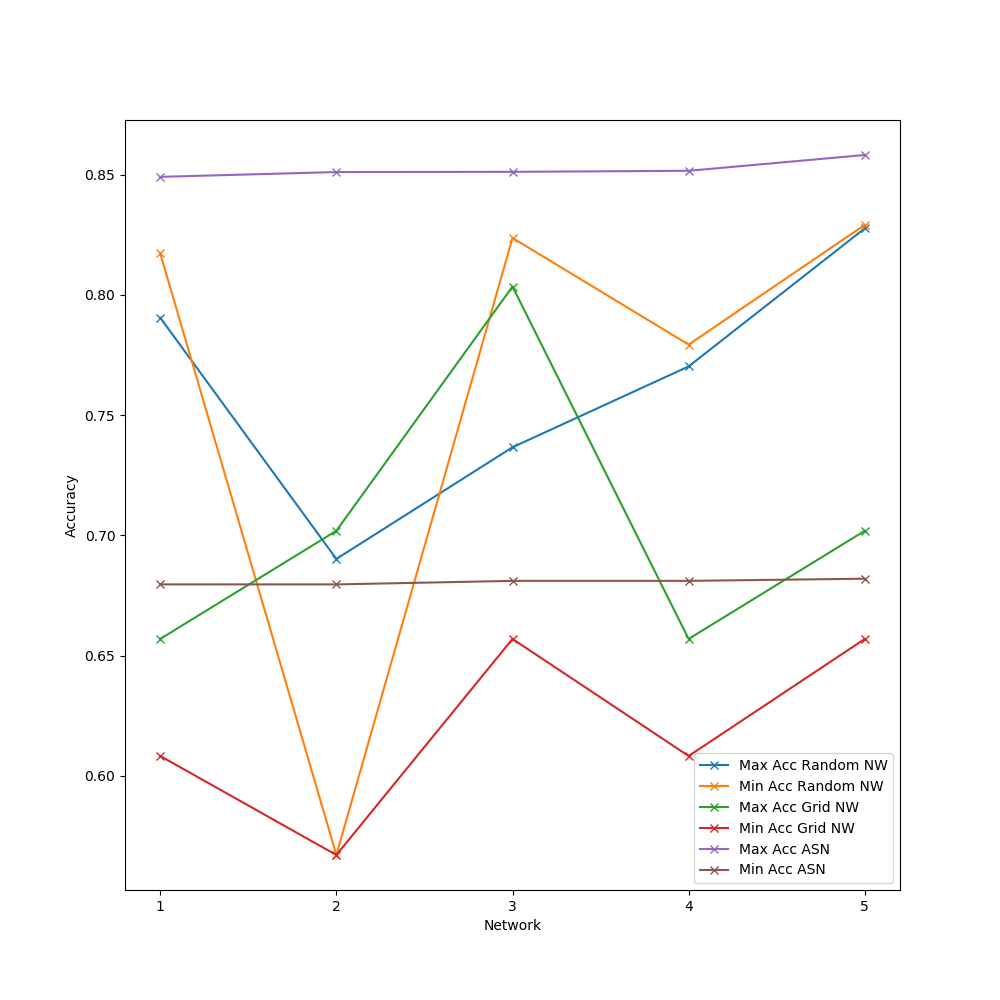

In [102]:
plt.figure(figsize=(10,10))
plt.plot(rand_acc[:5],'-x',label='Max Acc Random NW')
plt.plot(rand_acc[5:],'-x',label='Min Acc Random NW')
plt.plot(grid_acc[:5],'-x',label='Max Acc Grid NW')
plt.plot(grid_acc[5:],'-x',label='Min Acc Grid NW')
plt.plot(max_acc,'-x',label='Max Acc ASN')
plt.plot(min_acc,'-x',label='Min Acc ASN')
plt.legend(loc='lower right')
plt.xlabel('Network')
plt.ylabel('Accuracy')
plt.gca().set_xticks([0,1,2,3,4])
plt.gca().set_xticklabels([1,2,3,4,5])

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Min Max Accuracy vs WS Networks.png',format='png',dpi=300)

#### Modularity

In [103]:
#Modularity:
q_grid=[]
q_rand=[]
q_max=[]
q_min=[]
for i in range(len(WS_Grid)):
    q_grid.append(WS_Grid[i]['Graph Theory']['Modularity Score'])
    q_rand.append(WS_Random[i]['Graph Theory']['Modularity Score'])
for i in range(len(MaxAcc)):
    q_max.append(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Modularity Score'])
    q_min.append(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Graph Theory']['Modularity Score'])

<IPython.core.display.Javascript object>


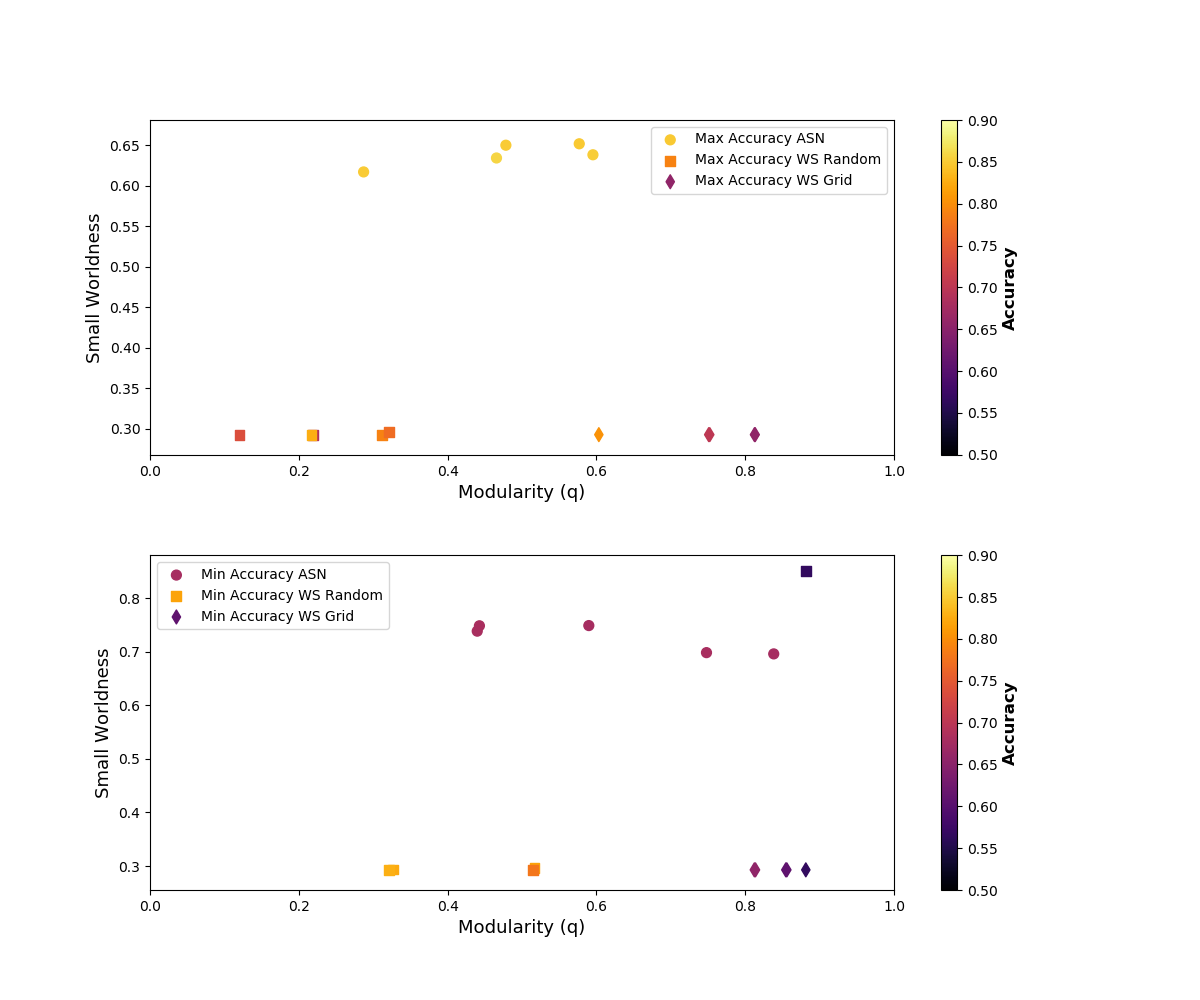

In [108]:
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig=plt.figure(figsize=(12,10))
ax=[None]*4
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
countAX=0
fig.subplots_adjust(hspace=.3)
# ax = fig.gca(projection='3d')

ax[0]=plt.subplot(2, 1, 1)

Y1=[]
X1=[]
acc1=[]

vmin=0.5
vmax=0.9

for i in range(int(len(WS_Random)/2)):
    Y1.append(WS_Random[i]['Graph Theory']['Small World'])
    X1.append(WS_Random[i]['Graph Theory']['Modularity Score'])    
    acc1.append(np.nanmax(WS_Random[i]['Accuracy']['Linear Transformation']))
        
Y1=np.asanyarray(Y1)
X1=np.asanyarray(X1)

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors1=[cmap(normalize(value)) for value in acc1]

Y2=[]#[[None]*10 for i in range(len(ASN300))]
X2=[]
acc2=[]

for i in range(int(len(WS_Grid)/2)):
    Y2.append(WS_Grid[i]['Graph Theory']['Small World'])
    X2.append(WS_Grid[i]['Graph Theory']['Modularity Score'])    
    acc2.append(np.nanmax(WS_Grid[i]['Accuracy']['Linear Transformation']))
        
Y2=np.asanyarray(Y2)
X2=np.asanyarray(X2)


normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors2=[cmap(normalize(value)) for value in acc2]

Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]
for i in range(len(MaxAcc)):
    degree = [val for (node, val) in ASN300[i][j]['G'].degree()]
    Y.append(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World'])
    X.append(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Modularity Score'])    
    acc.append(np.nanmax(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation']))
Y=np.asanyarray(Y)
X=np.asanyarray(X)

vmin=0.5
vmax=0.9

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors=[cmap(normalize(value)) for value in acc]

p=plt.scatter(X, Y,cmap=plt.cm.inferno,c=colors,s=50,alpha=1,label='Max Accuracy ASN',marker='o')
p2=plt.scatter(X1, Y1,cmap=plt.cm.inferno,c=colors1,s=50,alpha=1,label='Max Accuracy WS Random',marker='s')
p3=plt.scatter(X2, Y2,cmap=plt.cm.inferno,c=colors2,s=50,alpha=1,label='Max Accuracy WS Grid',marker='d')

plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Modularity (q)',fontsize=13)
plt.xlim(0,1)

# plt.ylim(0.55,0.80)

sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=plt.gca())
# cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)
plt.legend()

cb.set_label(label='Accuracy', size='large', weight='bold')

#Min Accuracy
ax[1]=plt.subplot(2, 1, 2)

Y1=[]
X1=[]
acc1=[]

vmin=0.5
vmax=0.9

for i in range(int(len(WS_Random)/2)):
    Y1.append(WS_Random[i+5]['Graph Theory']['Small World'])
    X1.append(WS_Random[i+5]['Graph Theory']['Modularity Score'])    
    acc1.append(np.nanmax(WS_Random[i+5]['Accuracy']['Linear Transformation']))
        
Y1=np.asanyarray(Y1)
X1=np.asanyarray(X1)

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors1=[cmap(normalize(value)) for value in acc1]

Y2=[]#[[None]*10 for i in range(len(ASN300))]
X2=[]
acc2=[]

for i in range(int(len(WS_Grid)/2)):
    Y2.append(WS_Grid[i+5]['Graph Theory']['Small World'])
    X2.append(WS_Grid[i+5]['Graph Theory']['Modularity Score'])    
    acc2.append(np.nanmax(WS_Grid[i+5]['Accuracy']['Linear Transformation']))
        
Y2=np.asanyarray(Y2)
X2=np.asanyarray(X2)


normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors2=[cmap(normalize(value)) for value in acc2]

Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]
for i in range(len(MinAcc)):
    Y.append(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Graph Theory']['Small World'])
    X.append(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Graph Theory']['Modularity Score'])    
    acc.append(np.nanmax(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Accuracy']['Linear Transformation']))
Y=np.asanyarray(Y)
X=np.asanyarray(X)

vmin=0.5
vmax=0.9

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors=[cmap(normalize(value)) for value in acc]

p=plt.scatter(X, Y,cmap=plt.cm.inferno,c=colors,s=50,alpha=1,label='Min Accuracy ASN',marker='o')
p2=plt.scatter(X1, Y1,cmap=plt.cm.inferno,c=colors1,s=50,alpha=1,label='Min Accuracy WS Random',marker='s')
p3=plt.scatter(X2, Y2,cmap=plt.cm.inferno,c=colors2,s=50,alpha=1,label='Min Accuracy WS Grid',marker='d')

plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Modularity (q)',fontsize=13)
plt.xlim(0,1)

# plt.ylim(0.55,0.80)

sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=plt.gca())
# cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)
plt.legend()

cb.set_label(label='Accuracy', size='large', weight='bold')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/MinMaxASN & WS Networks Modularity vs Small Worldness vs Linear Transform Accuracy.png',format='png',dpi=600)

<IPython.core.display.Javascript object>


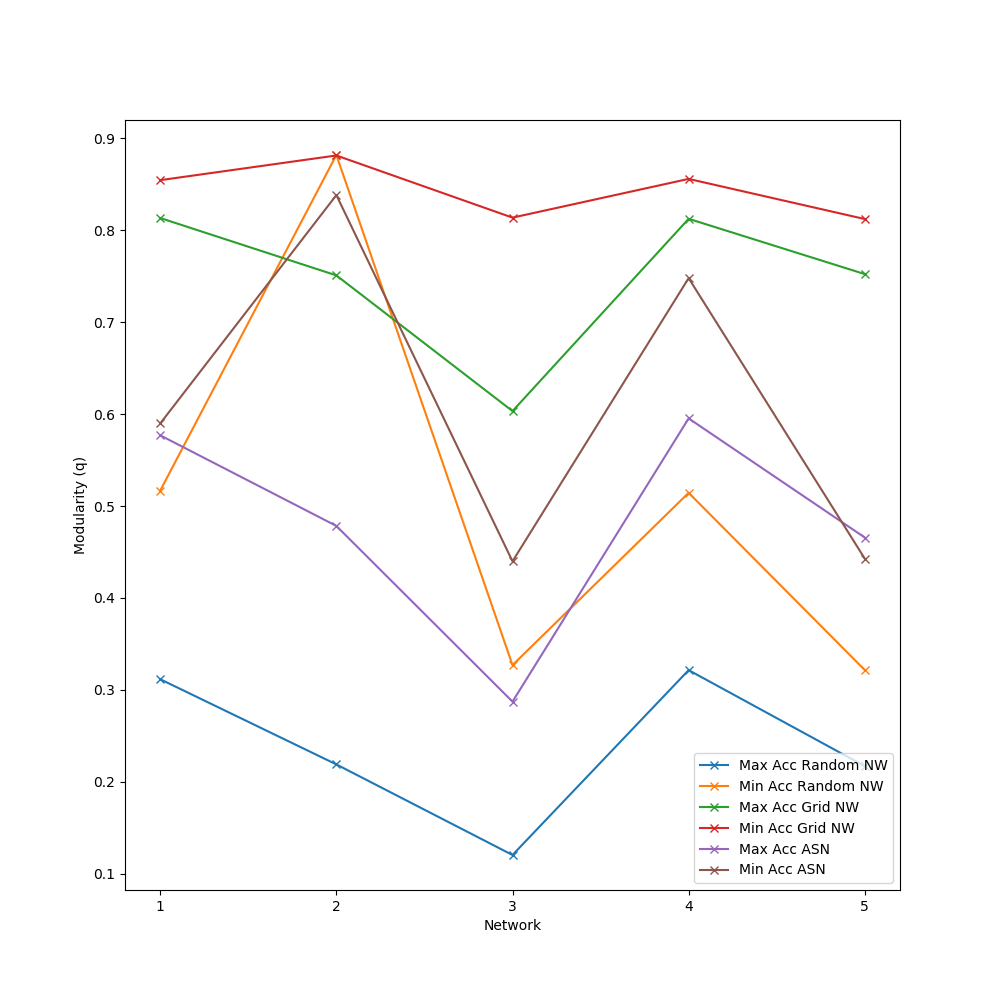

In [112]:
plt.figure(figsize=(10,10))
plt.plot(q_rand[:5],'-x',label='Max Acc Random NW')
plt.plot(q_rand[5:],'-x',label='Min Acc Random NW')
plt.plot(q_grid[:5],'-x',label='Max Acc Grid NW')
plt.plot(q_grid[5:],'-x',label='Min Acc Grid NW')
plt.plot(q_max,'-x',label='Max Acc ASN')
plt.plot(q_min,'-x',label='Min Acc ASN')
plt.xlabel('Network')
plt.ylabel('Modularity (q)')
plt.legend(loc='lower right')
plt.gca().set_xticks([0,1,2,3,4])
plt.gca().set_xticklabels([1,2,3,4,5])

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Modularity MinMaxASN vs WS Networks.png',format='png',dpi=300)

#### Degree

<IPython.core.display.Javascript object>


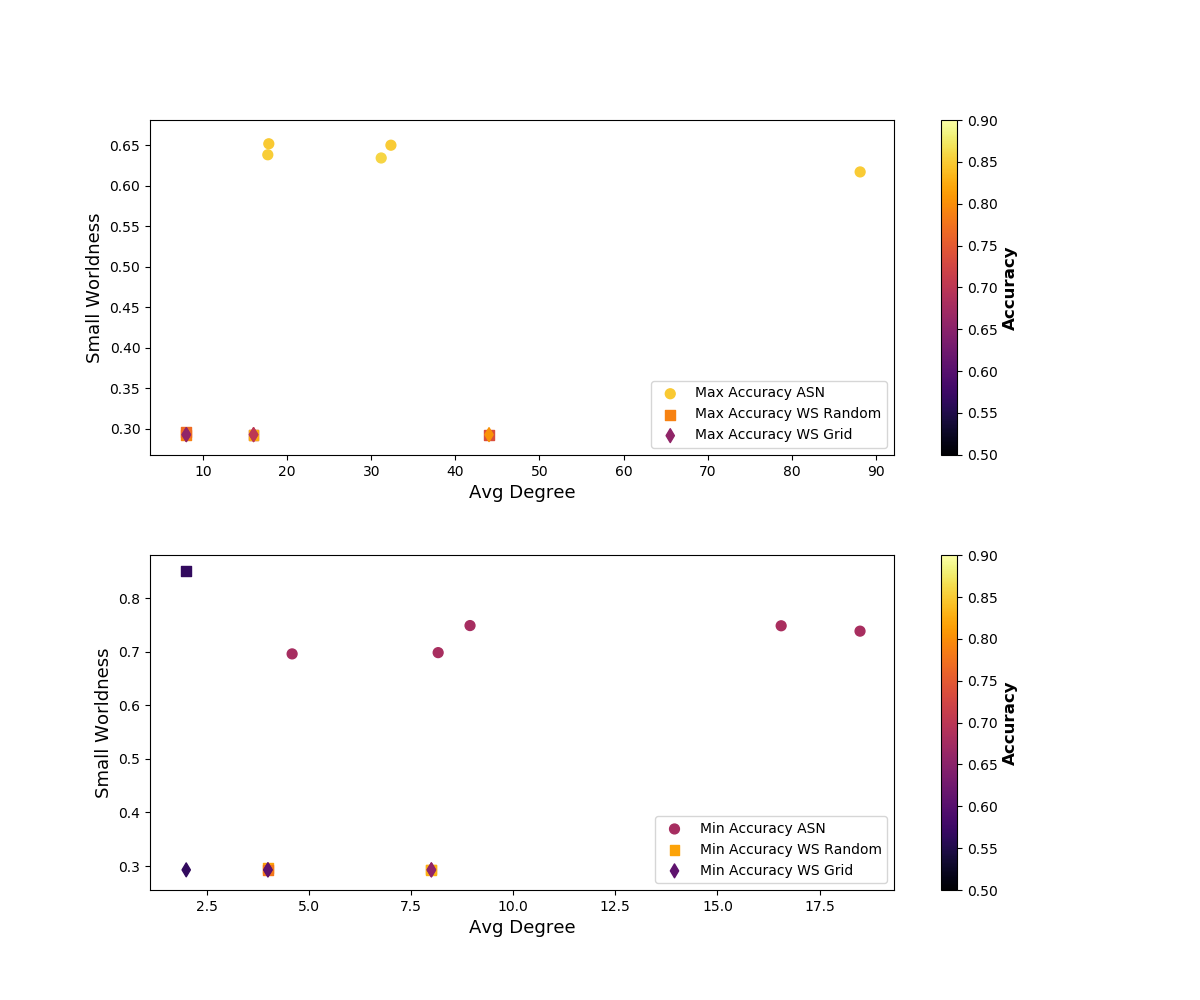

In [109]:
%matplotlib notebook
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  

fig=plt.figure(figsize=(12,10))
ax=[None]*4
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
countAX=0
fig.subplots_adjust(hspace=.3)
# ax = fig.gca(projection='3d')

ax[0]=plt.subplot(2, 1, 1)

Y1=[]
X1=[]
acc1=[]

vmin=0.5
vmax=0.9

for i in range(int(len(WS_Random)/2)):
    degree = [val for (node, val) in WS_Random[i]['G'].degree()]
    Y1.append(WS_Random[i]['Graph Theory']['Small World'])
    X1.append(np.mean(degree))    
    acc1.append(np.nanmax(WS_Random[i]['Accuracy']['Linear Transformation']))
        
Y1=np.asanyarray(Y1)
X1=np.asanyarray(X1)

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors1=[cmap(normalize(value)) for value in acc1]

Y2=[]#[[None]*10 for i in range(len(ASN300))]
X2=[]
acc2=[]

for i in range(int(len(WS_Grid)/2)):
    degree = [val for (node, val) in WS_Grid[i]['G'].degree()]
    Y2.append(WS_Grid[i]['Graph Theory']['Small World'])
    X2.append(np.mean(degree))    
    acc2.append(np.nanmax(WS_Grid[i]['Accuracy']['Linear Transformation']))
        
Y2=np.asanyarray(Y2)
X2=np.asanyarray(X2)


normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors2=[cmap(normalize(value)) for value in acc2]

Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]
for i in range(len(MaxAcc)):
    degree = [val for (node, val) in ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['G'].degree()]
    Y.append(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Graph Theory']['Small World'])
    X.append(np.mean(degree))    
    acc.append(np.nanmax(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['Accuracy']['Linear Transformation']))
Y=np.asanyarray(Y)
X=np.asanyarray(X)

vmin=0.5
vmax=0.9

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors=[cmap(normalize(value)) for value in acc]

p=plt.scatter(X, Y,cmap=plt.cm.inferno,c=colors,s=50,alpha=1,label='Max Accuracy ASN',marker='o')
p2=plt.scatter(X1, Y1,cmap=plt.cm.inferno,c=colors1,s=50,alpha=1,label='Max Accuracy WS Random',marker='s')
p3=plt.scatter(X2, Y2,cmap=plt.cm.inferno,c=colors2,s=50,alpha=1,label='Max Accuracy WS Grid',marker='d')

plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Avg Degree',fontsize=13)
# plt.xlim(0,1)

# plt.ylim(0.55,0.80)

sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=plt.gca())
# cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)
plt.legend()

cb.set_label(label='Accuracy', size='large', weight='bold')

#Min Accuracy
ax[1]=plt.subplot(2, 1, 2)

Y1=[]
X1=[]
acc1=[]

vmin=0.5
vmax=0.9

for i in range(int(len(WS_Random)/2)):
    degree = [val for (node, val) in WS_Random[i+5]['G'].degree()]
    Y1.append(WS_Random[i+5]['Graph Theory']['Small World'])
    X1.append(np.mean(degree))    
    acc1.append(np.nanmax(WS_Random[i+5]['Accuracy']['Linear Transformation']))
        
Y1=np.asanyarray(Y1)
X1=np.asanyarray(X1)

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors1=[cmap(normalize(value)) for value in acc1]

Y2=[]#[[None]*10 for i in range(len(ASN300))]
X2=[]
acc2=[]

for i in range(int(len(WS_Grid)/2)):
    degree = [val for (node, val) in WS_Grid[i+5]['G'].degree()]
    Y2.append(WS_Grid[i+5]['Graph Theory']['Small World'])
    X2.append(np.mean(degree))    
    acc2.append(np.nanmax(WS_Grid[i+5]['Accuracy']['Linear Transformation']))
        
Y2=np.asanyarray(Y2)
X2=np.asanyarray(X2)


normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors2=[cmap(normalize(value)) for value in acc2]

Y=[]#[[None]*10 for i in range(len(ASN300))]
X=[]
acc=[]
for i in range(len(MinAcc)):
    degree = [val for (node, val) in ASN300[MinAcc[i][0]][MinAcc[i][1]]['G'].degree()]
    Y.append(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Graph Theory']['Small World'])
    X.append(np.mean(degree))    
    acc.append(np.nanmax(ASN300[MinAcc[i][0]][MinAcc[i][1]]['Accuracy']['Linear Transformation']))
Y=np.asanyarray(Y)
X=np.asanyarray(X)

vmin=0.5
vmax=0.9

normalize=plt.Normalize(vmin = vmin, vmax=vmax)
cmap=plt.cm.inferno
colors=[cmap(normalize(value)) for value in acc]

p=plt.scatter(X, Y,cmap=plt.cm.inferno,c=colors,s=50,alpha=1,label='Min Accuracy ASN',marker='o')
p2=plt.scatter(X1, Y1,cmap=plt.cm.inferno,c=colors1,s=50,alpha=1,label='Min Accuracy WS Random',marker='s')
p3=plt.scatter(X2, Y2,cmap=plt.cm.inferno,c=colors2,s=50,alpha=1,label='Min Accuracy WS Grid',marker='d')

plt.ylabel('Small Worldness (swp)',fontsize=13)
plt.xlabel('Avg Degree',fontsize=13)
# plt.xlim(0,1)

# plt.ylim(0.55,0.80)

sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=plt.gca())
# cb=fig.colorbar(p,ax=plt.gca())
# ax.set_zlabel('Accuracy',fontsize=13)
plt.legend()

cb.set_label(label='Accuracy', size='large', weight='bold')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/MinMaxASN & WS Networks Avg Degree vs Small Worldness vs Linear Transform Accuracy.png',format='png',dpi=600)


In [ ]:
#TO DO:

# configuration model random network
# edge swapping random network
# network x - other measures

# sweep through voltages for min and max networks